In [2]:
import pandas as pd
import numpy as np
import os as os
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.util import ngrams
import nltk
import acessos as ac
from arabica import arabica_freq
from unidecode import unidecode
import re
import plotly.express as px
import texthero as hero
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.naive_bayes import BernoulliNB
import spacy
import re
import nlp
import warnings
import statsmodels.api as sm
from statsmodels.formula.api import ols


warnings.simplefilter(action='ignore', category=FutureWarning)

2023-08-08 10:47:53.539777: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 10:47:53.837265: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 10:47:53.838920: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 10:47:55.634338: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Query

In [3]:
query = """

select * 
, aberturas / cast(clientes as double) as taxa_abertura 
, cliques / cast(aberturas as double) as taxa_clique
from (
select 
activityname --jornada campanha
, journeyname --campanha
, substring(activityname, 12,10) as tema
, subject
, 'Salesforce' as ferramenta
, count(email) as clientes
, sum(nr_click) as cliques
, sum(nr_open) as aberturas
, max(dt_envio) as dt_envio
from 
martech_curated_zone.retorno_email_sfmc
where eventtype = 'Sent'
and tipo <> 'Transacional'
group by 1,2,3,4
union all 
select 
communication_name as activityname --jornada campanha
, communication_name as journeyname --campanha
, ''   as tema
, subject
, 'Infobip' as ferramenta
, SUM(messages_count) as clientes
, sum(clicks) as cliques
, sum(opens) as aberturas
, max(send_at) as dt_envio
from 
martech_curated_zone.log_infobip_email_pag p
where status = 'Delivered'
group by 1,2,3,4
)
where clientes > 10
and lower(journeyname) not like '%%cobranca%%'
and lower(journeyname) not like '%%cobrança%%'
and lower(journeyname) not like '%%aquisicao%%'
and lower(journeyname) not like '%%aquisição%%'
and lower(subject) not like '%%willclipping%%' 
and lower(subject) not like '%%relatório%%'
and lower(subject) not like '%%boletim%%'
and lower(subject) not like '%%correios%%'
and lower(subject) not like '%%newsletter%%'
and lower(journeyname) not like '%%teste%%'
and lower(subject) not like '%%teste%%'
and lower(journeyname) not like '%%pesquisa%%'
and lower(journeyname) not like '%%comunicação interna%%'
and lower(journeyname) not like '%%café%%'
and lower(journeyname) not like '%%cxm%%'
and lower(journeyname) not like '%%acesso%%'
and lower(subject) not like '%%[will bank e pag%%'
and lower(subject) not like '%%[willbank]%%'
and lower(subject) not like '%%[meu pag]%%'
and lower(subject) not like '%%[meupag]%%'
and lower(subject) not like '%%[will bank]%%'
and lower(subject) not like '%%pag amarelo%%'
and lower(journeyname) not like '%%unresolved communication%%'
and lower(subject) not like '%%certificado%%'
and lower(journeyname) not like '%%ri_pessoas%%'
and lower(subject) not like '%%will em um minuto%%'
and lower(subject) not like '%%chegaram os vouchers%%'
order by cliques desc

"""

df = ac.df_athena('flavia-costa', query)

In [4]:
len(df)

774

## Funções de tratamento

In [5]:
stopwords_will= ['da', 'em', 'você', 'de', 'ao', 'os', 'que', 'e', 'eu', 'o', 'estou', 'ele','ela','pra', 'pro', 'entao', 'para', 'voce',
                 'pra', 'tá', 'né', 'ah', 'aí', 'dá', 'ó', 'mim', 'então', 'aqui', 'tô', 'pro',
            'seu', 'sua', 'por', 'sobre', 'mais', 'uma', 'um','como', 'meu', 'com', 'outro','outra','das','dos','foi', 'fiz','pelo','tem','mas',
            'este', 'esse','ta', 'to', 'ai', 'la', 'lo', 'lhe', 'ne','pra', 'tá', 'né', 'ah', 'aí', 'dá', 'ó', 'mim', 'então', 'aqui', 'tô', 'pro', 'isso']

In [6]:
def classif_emoji(text):
    '''
    Replace emojis with word emoji
    '''
    regrex_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                "]+", flags=re.UNICODE)
    return regrex_pattern.sub(r'emoji ', str(text))

def clean_text(x):
    x = unidecode(x)
    x = x.strip()
    x = x.lower()
    x = re.sub(r'\t', ' ', x)
    x = re.sub(r'http\S+', '', x)  # remove url
    x = re.sub(r'screenshot sent', 'screenshotsent', x)
    x = re.sub(r'will bank', 'willbank', x)
    x = re.sub(r'(nbsp\;|[rl]dquo\;|quot\;|acute\;|tilde\;|circ\;|grave\;|cedil\;|\&|\/)', '', x)  # replace special characters
    
    x = x.replace('&ccedil;','ç')
    x = x.replace('&atilde;;','ã')
    x = x.replace('&otilde;;','õ')
    x = re.sub(r'(\d{1,}|\!|\?|\,|\.|\\n|\:|\;|\`|\´|\-|\_)', ' ', x)  # replace punctuation and remove numbers
    x = x.replace('  ',' ')
    x = x.replace('\n','')
    x = x.strip()
    return x

def retira_saudacoes(text):
       
   regex_list = [
        'bo[ma] (dia|tarde|noite)',
        'agradeco', 'agradecido',
        '(tu?do?|esta|tah?) (b[eo]m|cert(inh)?[oa]|ok)',
        'ok', 'okay', 'sim',
        'oi{1,}e{0,}', 'ola', 'opa',
        'beleza', 'blz',
        'compreendi(do)?',
        'entendi(do)?',
        'tendi(do)?',
        '(muito|mt)? ?(obrigad[oa]|obg|b[oe]m)',
        'b?a{1,10}h?',
        'abracos?',
        '(por|de) na?da?',
        'por (favor|gentileza)'
    ]
   
   regex_list += stopwords_will
   pattern = r'\b(' + '|'.join(regex_list) + r')\b'
   text = re.sub(pattern, '', str(text))
   text = text.replace('  ',' ')
   return text

## Avaliando a target

<AxesSubplot:xlabel='taxa_abertura'>

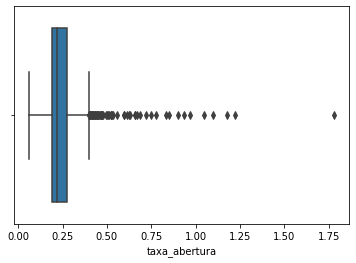

In [7]:
sns.boxplot(data = df, x = 'taxa_abertura')

<AxesSubplot:xlabel='taxa_abertura', ylabel='ferramenta'>

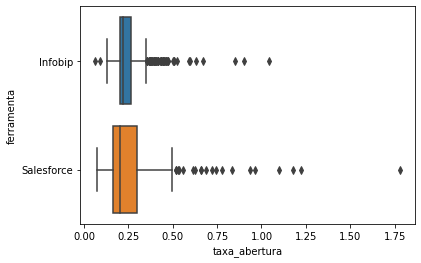

In [9]:
sns.boxplot(data = df, x = 'taxa_abertura', y = 'ferramenta')

In [10]:
df.query('taxa_abertura > 1')

,activityname,journeyname,tema,subject,ferramenta,clientes,cliques,aberturas,dt_envio,taxa_abertura,taxa_clique
316,EMAIL_CARTOES_AUMENTO_LIMITE_BELVO,201_PMM_CARTOES_05072023_AUMENTO_LIMITE_BELVO,ES_AUMENTO,Uhuuu! Chegou limite novo pra vc! ...,Salesforce,1557,532.0,1903.0,2023-07-05 12:11:38.000,1.222222,0.279559
448,20230329 - Segue a sua senha para resgatar os ...,20230329 - Segue a sua senha para resgatar os ...,,Segue a sua senha para resgatar os vouchers!,Infobip,316,165.0,330.0,2023-03-29 09:02:05.000,1.044304,0.500000
638,EMAIL_CARTOES_LIMITE_SURPRESA_PADRAO,201_PMM_CARTOES_04082023_EMAIL_LIMITE_SURPRESA,ES_LIMITE_,Tem um LIMITE SURPRESA neste e-mail ...,Salesforce,291,32.0,319.0,2023-08-04 18:08:38.000,1.096220,0.100313
709,EMAIL_CARTOES_AUMENTO_LIMITE_GAMI_PARA_BAU,201_PMM_CARTOES_03082023_AUMENTO_LIMITE_GAME,ES_AUMENTO,"ei, vem ver seu novo limite. 😍 ...",Salesforce,17,7.0,20.0,2023-08-03 12:04:56.000,1.176471,0.350000
732,TemplateTesteAnexo,New Journey - October 24 2022 at 2.09 PM,teAnexo,Email com anexo ...,Salesforce,18,3.0,32.0,2022-11-01 09:57:33.233,1.777778,0.093750


In [11]:
df = df.query('taxa_abertura < 1')

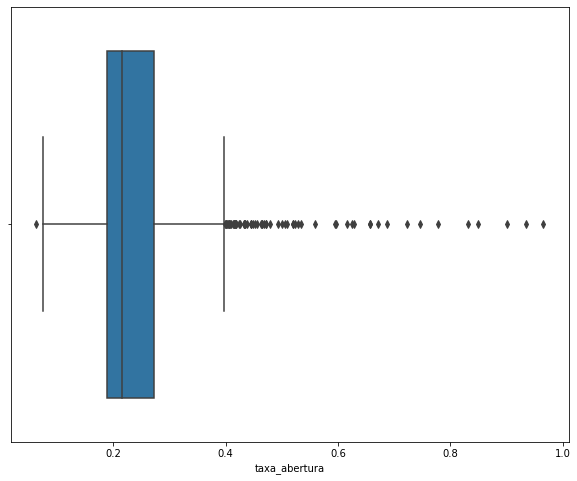

In [25]:
plt.figure(figsize = (10,8))
sns.boxplot(data = df, x = 'taxa_abertura')
plt.show()

In [12]:
len(df)

755

In [26]:
len(df.query('taxa_abertura > 0.4'))

62

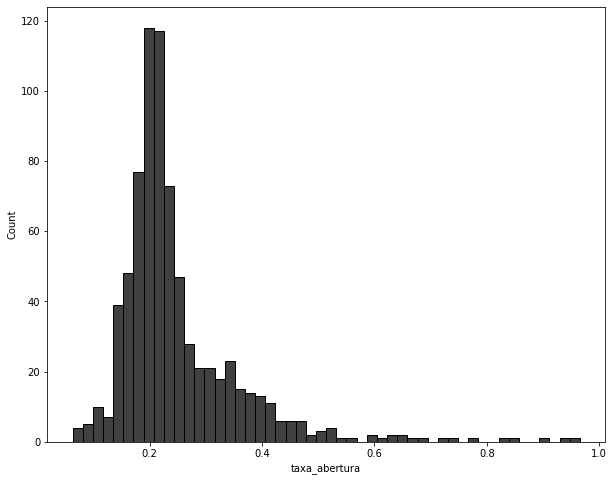

In [29]:
plt.figure(figsize = (10,8))
sns.histplot(data = df, x = 'taxa_abertura', color = 'black')
plt.show()

## Flags de palavras e termos

In [13]:
## caracteristicas da campanha ##
df['flag_cobranca'] = np.where((df['activityname'].str.contains("_COBR_") | df['activityname'].str.contains("_COBRANCA_")), 1, 0)

df['flag_cobranca'].value_counts()

0    654
1    101
Name: flag_cobranca, dtype: int64

<AxesSubplot:xlabel='taxa_abertura'>

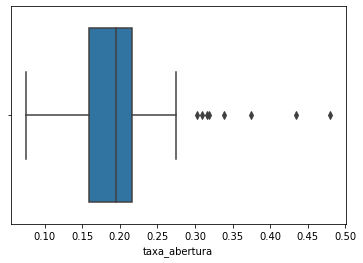

In [18]:
sns.boxplot(data = df.query('flag_cobranca == 1'), x = 'taxa_abertura')

<AxesSubplot:xlabel='taxa_abertura'>

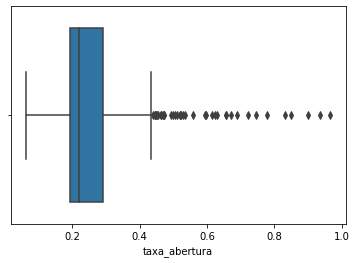

In [19]:
sns.boxplot(data = df.query('flag_cobranca == 0'), x = 'taxa_abertura')

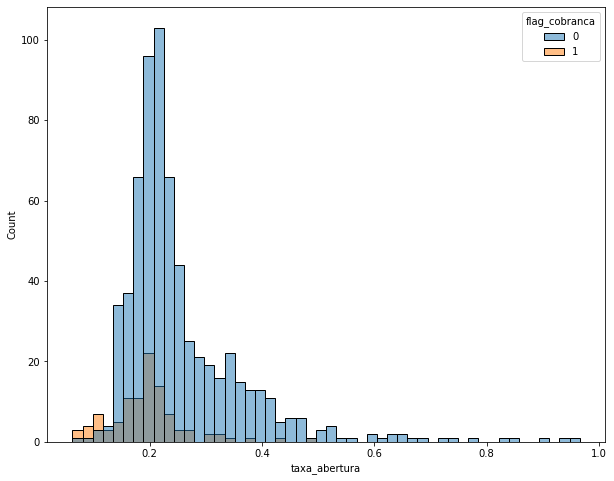

In [30]:
plt.figure(figsize = (10,8))
sns.histplot(data = df, x = 'taxa_abertura', color = 'black', hue = 'flag_cobranca')
plt.show()

In [20]:
df[['flag_cobranca', 'taxa_abertura', 'taxa_clique']].groupby('flag_cobranca').mean()

,taxa_abertura,taxa_clique
flag_cobranca,,
0,0.257426,0.080333
1,0.194964,0.078794


In [21]:
df[['flag_cobranca', 'taxa_abertura', 'taxa_clique']].groupby('flag_cobranca').median()

,taxa_abertura,taxa_clique
flag_cobranca,,
0,0.221088,0.027119
1,0.194694,0.062050


In [39]:
## característica da mensagem ##

# tem emoji
df['ds_message_tratada'] = df['subject'].apply(classif_emoji)
df['flag_emoji'] = np.where((df['ds_message_tratada'].str.contains("emoji")), 1, 0)

#contém exclamações e perguntas
df['flag_exclamacao'] = np.where((df['subject'].str.contains("!")), 1, 0)

# menciona dinheiro
df['flag_dinheiro'] = np.where((df['subject'].str.contains("R$") | df['subject'].str.contains("reais") | df['subject'].str.contains("REAIS") | df['subject'].str.contains("dinheiro") | df['subject'].str.contains("dindin")), 1, 0)

# palavras fatura ou limite
df['flag_fatura'] = np.where((df['subject'].str.contains("fatura") | df['subject'].str.contains("FATURA") | df['subject'].str.contains("Fatura")), 1, 0)
df['flag_limite'] = np.where((df['subject'].str.contains("limite") | df['subject'].str.contains("LIMITE") | df['subject'].str.contains("Limite")), 1, 0)

# palavra cashback
df['flag_cashback'] = np.where((df['subject'].str.contains("cashback") | df['subject'].str.contains("CASHBACK") | df['subject'].str.contains("Cashback")), 1, 0)

# %%nome%% 
df['flag_nome'] = np.where((df['subject'].str.contains('%nome%') ), 1, 0)

In [32]:
df['flag_nome'].value_counts()

0    754
1      1
Name: flag_nome, dtype: int64

## Tratamento e contagem de palavras

In [33]:
## Tratando texto da mensagem
df['ds_message_tratada'] = df['ds_message_tratada'].apply(clean_text)
df['ds_message_tratada'] = df['ds_message_tratada'].apply(retira_saudacoes)
df_clean = df.query('ds_message_tratada != " "').query('ds_message_tratada != "  "').query('ds_message_tratada != ""').query('ds_message_tratada != "   "')
df_clean = df_clean.query('flag_cobranca == 0')


#tamanho do texto
df_clean['n_palavras'] = df['ds_message_tratada'].str.count(' ')


## Palavras chave: fatura, limite, cashback, dinheiro

In [40]:
df_clean['flag_fatura'].value_counts(normalize = 'True')

0    0.93578
1    0.06422
Name: flag_fatura, dtype: float64

In [41]:
df_clean['flag_limite'].value_counts(normalize = 'True')

0    0.666667
1    0.333333
Name: flag_limite, dtype: float64

In [42]:
df_clean['flag_cashback'].value_counts(normalize = 'True')

0    0.963303
1    0.036697
Name: flag_cashback, dtype: float64

In [43]:
df_clean['flag_dinheiro'].value_counts(normalize = 'True')

0    0.992355
1    0.007645
Name: flag_dinheiro, dtype: float64

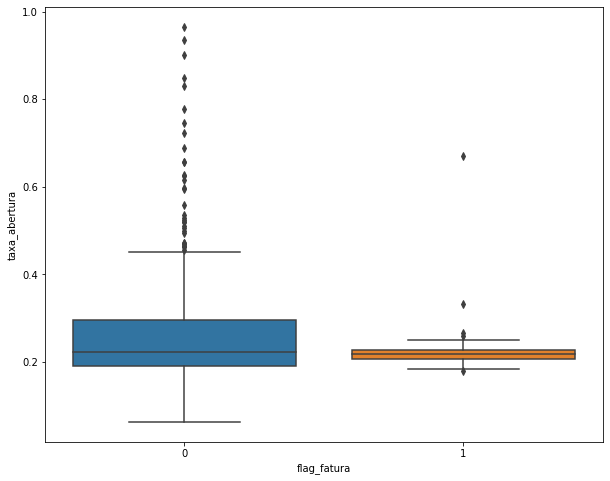

In [49]:
plt.figure(figsize = (10,8))
sns.boxplot(data = df_clean, y = 'taxa_abertura', x = 'flag_fatura')
plt.show()

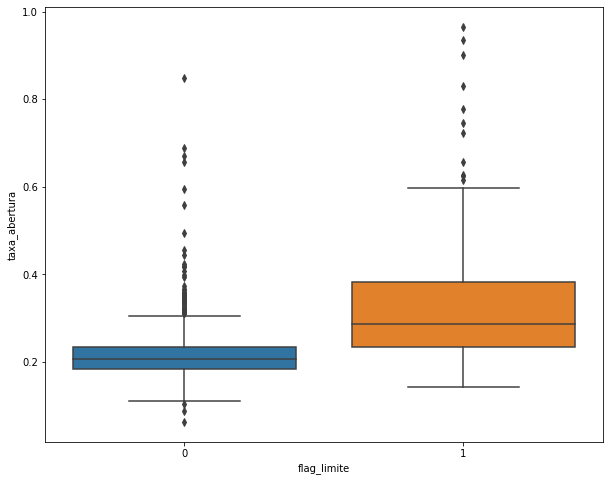

In [50]:
plt.figure(figsize = (10,8))
sns.boxplot(data = df_clean, y = 'taxa_abertura', x = 'flag_limite')
plt.show()

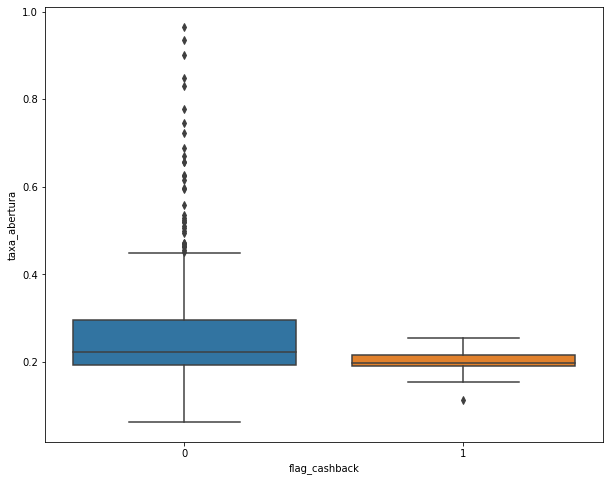

In [51]:
plt.figure(figsize = (10,8))
sns.boxplot(data = df_clean, y = 'taxa_abertura', x = 'flag_cashback')
plt.show()

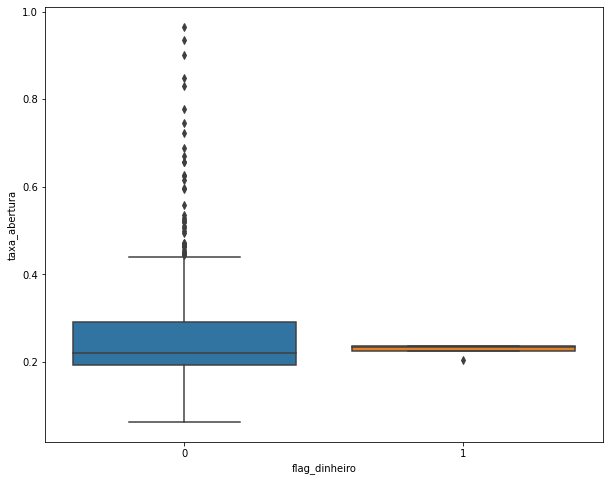

In [52]:
plt.figure(figsize = (10,8))
sns.boxplot(data = df_clean, y = 'taxa_abertura', x = 'flag_dinheiro')
plt.show()

In [170]:
df_clean['flag_emoji'].value_counts(normalize = True)

0    0.749235
1    0.250765
Name: flag_emoji, dtype: float64

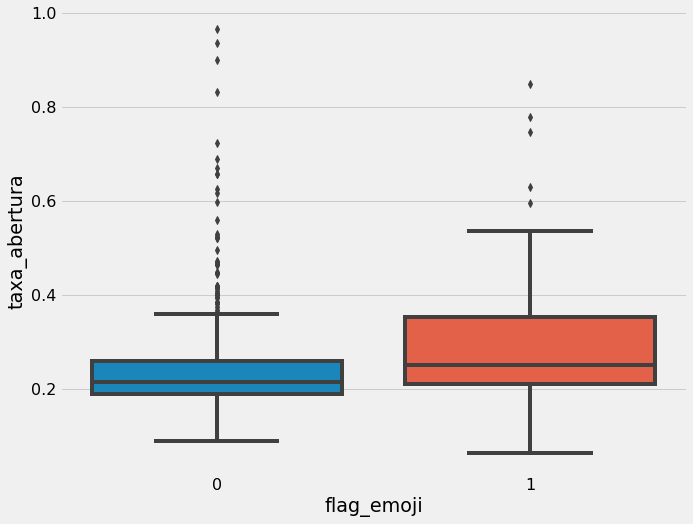

In [168]:
plt.figure(figsize = (10,8))
sns.boxplot(data = df_clean, y = 'taxa_abertura', x = 'flag_emoji')
plt.show()

## Nr de palavras

<AxesSubplot:xlabel='n_palavras', ylabel='Count'>

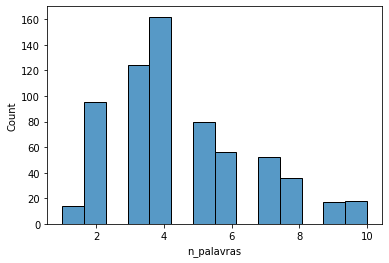

In [108]:
sns.histplot(df_clean['n_palavras'])

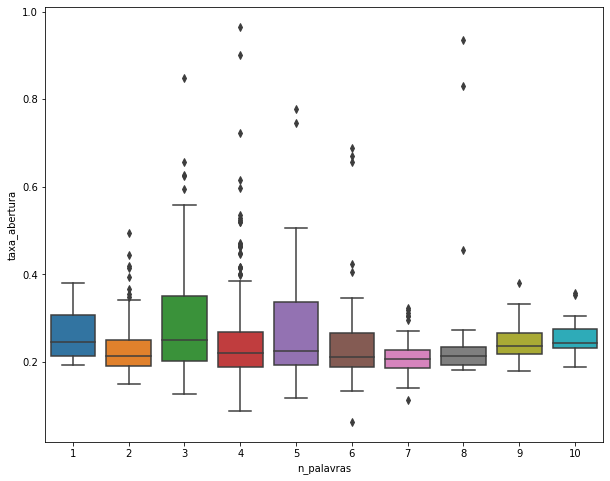

In [109]:
plt.figure(figsize = (10,8))
sns.boxplot(data = df_clean, y = 'taxa_abertura', x = 'n_palavras')
plt.show()

In [112]:
print(df_clean[df_clean['n_palavras']  == 1]['subject'].unique())

['⭐Você escolhe'
 'Aumentei seu limite!                                                                                                                                                                                    '
 'Imprevistos acontecem' 'organize sua grana' 'PIX é bom.']


In [113]:
print(df_clean[df_clean['n_palavras']  == 10]['subject'].unique())

['Chegou a hora de usar seu cartão will e garantir as compras de natal com dindim de volta!                                                                                                               '
 'Seu limite não aumentou na campanha Limite Back desta vez 😕']


## Análise de sentimento Vader

In [531]:
#!pip install leIA-br

     |████████████████████████████████| 130 kB 6.4 MB/s eta 0:00:01


In [34]:
#nltk.downloader.download('vader_lexicon')

from LeIA import SentimentIntensityAnalyzer 


# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
# Create a new column in the dataframe to store the sentiment scores
df_clean["sentiment"] = 0.0

# Iterate over the rows of the dataframe
for index, row in df_clean.iterrows():
  # Use the analyzer to predict the sentiment of the text
  scores = analyzer.polarity_scores(row["ds_message_tratada"])
  # Store the compound score in the new column
  df_clean.at[index, "sentiment"] = scores["compound"]

In [35]:
df_clean['sentiment'].describe()

count    654.00000
mean       0.15179
std        0.23559
min       -0.59940
25%        0.00000
50%        0.00000
75%        0.36120
max        0.76500
Name: sentiment, dtype: float64

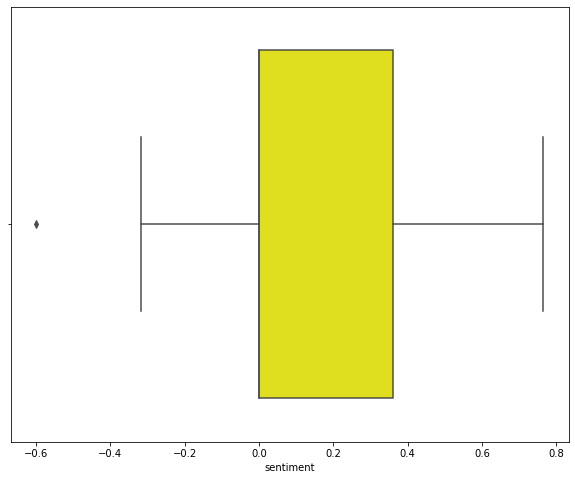

In [36]:
plt.figure(figsize = (10,8))
sns.boxplot(x = df_clean['sentiment'], color = 'yellow')
plt.show()

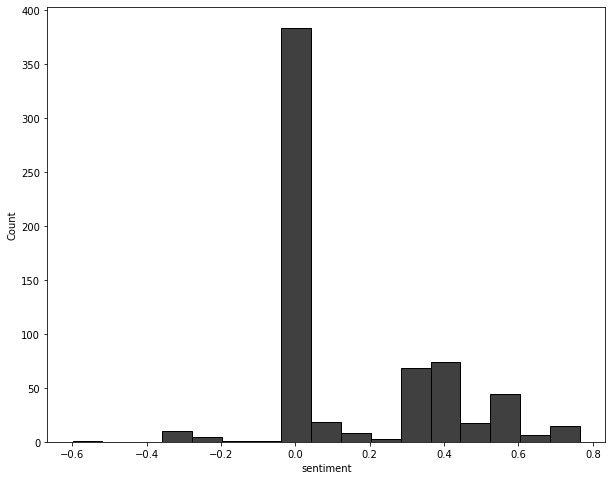

In [53]:
plt.figure(figsize = (10,8))
sns.histplot(x = df_clean['sentiment'], color = 'black')
plt.show()

In [62]:
print(df_clean[df_clean['sentiment'] < 0]['subject'].unique())

['Adiante seu FGTS! Falta pouco                                                                                                                                                                           '
 'Falta pouco pra antecipar seu dindim 💛                                                                                                                                                                 '
 'Apareceu um imprevisto? Antecipa o saque-aniversário                                                                                                                                                    '
 'Essa você não pode deixar passar 🤩'
 'quer comprar nas suas lojas favoritas e não pagar por nada?'
 'com uma promo dessa é impossível não amar o amarelinho nas comprinhas!'
 'vai perder o Limite Surpresa turbinado do dia das mães?'
 ' essa promo é igual comida gostosa. Não dá pra perder'
 'Falta pouco pra receber seu dindim 🤑                                                            

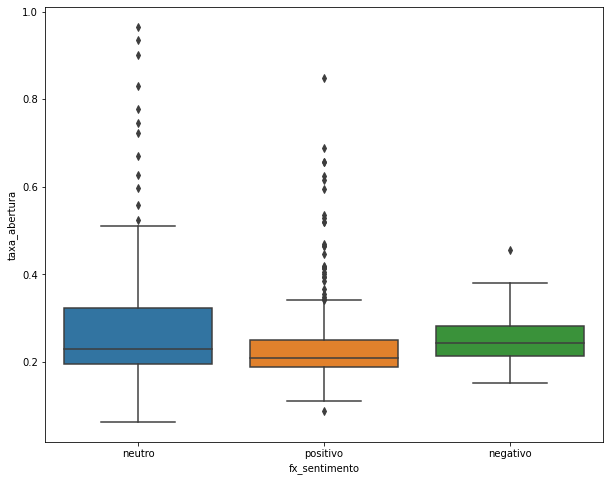

In [64]:
df_clean['fx_sentimento'] = np.where(df_clean['sentiment'] < 0, 'negativo', 
                            np.where(df_clean['sentiment'] == 0, 'neutro', 'positivo'))

plt.figure(figsize = (10,8))
sns.boxplot(data = df_clean, y = 'taxa_abertura', x = 'fx_sentimento')
plt.show()

## Análise de sentimento modelo com base de exemplos de bots

In [65]:
base_treinamento = [('Mais uma chance pra eu tentar te ajudar 😊', 'bom'),
        ('Beleza, seu protocolo é', 'neutro'),
        ('Trouxe alguns assuntos pra você Escolhe um deles', 'neutro'),
        ('Vi que sua fatura tá atrasada', 'ruim'),
        ('Poxa que pena que teve um problema', 'ruim'),
        ('Trouxe alguns assuntos pra você Escolhe um deles', 'neutro'),
        ('Beleza Se tiver mais dúvidas tô por aqui', 'bom'), 
        ('O cartão virtual do will é tudo Muito seguro já vem liberado pra compras online', 'bom'),
        ('ui não dá pra pedir aumento de limite', 'ruim'),
        ('Às vezes o sistema demora um pouco pra saber se entregaram seu cartão', 'ruim'),
        ('Poxa seu cartão sumiu durante a entrega', 'ruim'),
        ('Aguarde 💛', 'neutro'),
        ('Ah, te reconheci: você tem a nossa conta digital com o cartão de débito.', 'neutro'),
        ('Você anotou o código do erro que apareceu na página?', 'neutro'),
        ('Você já usa a conta digital will?', 'neutro'),
        ('Você recebe o código de rastreio quando o cartão sai pra entrega.', 'neutro'),
        ('Tenta contratar de novo. Aí anota esse número do erro e volta aqui, beleza?', 'ruim'),
        ('Tenho aqui um artigo que mostra certinho como que contrata:', 'neutro'),
        ('Tenho uma coisa importante pra te falar sobre fatura 🤓', 'neutro'),
        ('Que legal! Você tá participando da nossa campanha de aumento de limite.', 'bom'),
        ('O sistema tá instável, sem reconhecer alguns pagamentos.', 'ruim'),
        ('O sistema tá com problemas', 'ruim'),
        ('Beleza! Se tiver mais dúvidas, tô por aqui', 'bom'),
        ('Depois disso, segue usando seu cartão que mais limite pode vir 😉', 'bom'),
        ('Essas são as dicas pra conseguir mais limite no will:', 'bom'),
        ('Eu vi aqui que essa oferta de empréstimo ainda não tá disponível pra você.', 'ruim'),
        ('Isso vai gerar alguns encargos, tá?', 'ruim'),
        ('Nesse caso, pode ter acontecido alguma instabilidade no FGTS.', 'ruim'),
        ('pode antecipar até 7 saques do seu saque-aniversário de uma vez só. Nada de esperar 7 anos! 🤑', 'bom'),
        ('O dindim do empréstimo costuma entrar na sua conta em até 1 dia útil 🤑', 'bom'),
        ('O pessoal tentou entregar seu cartão e não conseguiu.', 'ruim'),
        ('O serviço ainda tá em fase de teste. Logo, logo a gente libera pra mais pessoas, beleza?', 'ruim'),
        ('Ok, já chamo alguém pra te atender.', 'neutro'),
        ('No forninho! Seu cartão tá em produção e chega em até dias úteis.', 'bom'),
        ('Ótimo! Se precisar de mim, pode me chamar', 'bom'),
        ('Tá com fatura atrasada, né? O valor atual é de', 'ruim'),
        ('Bom demais! Se precisar de mim, pode me chamar. Sempre 🤗', 'bom'),
        ('O saque-aniversário permite que a pessoa saque parte do Fundo de Garantia do Tempo de Serviço (FGTS).', 'neutro'),
        ('Ah, então pode ser isso!', 'neutro'),
        ('Você pode consultar seu saldo no aplicativo do FGTS.', 'neutro'),
        ('Vi que sua fatura fechou em com vencimento no dia', 'neutro'),
        ('Tecnologia é demais, né? Mas pode digitar manualmente, se quiser. Não julgo 😊', 'bom'),
        ('Seu limite vai crescer assim', 'neutro'),
        ('Mas vai dar certo! ', 'bom'),
        ('Desculpa! Foi um problema nosso e vamos te mandar outro.', 'ruim'),
        ('aumento vem dias úteis dia beleza pagar adiantado', 'neutro'),
        ('O que mais você precisa? 🤗', 'bom'),
        ('O que prefere agora?', 'bom'),
        ('No geral, não dá pra pagar boleto nem passar na maquininha.', 'ruim'),
        ('Como te ajudo agora?', 'bom'),
        ('A loja will também tem cupons de desconto.', 'bom'),
        ('Se precisar do seu, é só chamar alguém do meu time pra te enviar, belezinha?', 'bom'),
        ('Perfeito pra movimentar aquele dinheiro que tá lá parado juntando poeira 😅', 'bom'),
        ('O time will tá correndo pra resolver, e em até 72 horas tudo volta ao normal.', 'ruim'),
        ('Sem boletos por aqui, sua fatura tá zero 🎉', 'bom'),
        ('Foi um prazer falar com você! Volte sempre que precisar.', 'bom'),
        ('Beleza, vamos tentar descobrir o que tá acontecendo.', 'bom'),
        ('Antes, conta um pouco mais do que precisa.', 'neutro'),
        ('Antes, conta um pouco mais do que precisa.', 'neutro'),
        ('Aí você paga menos juros sobre as parcelas que adiantar. Um descontinho é sempre bem-vindo, né? 😅', 'bom'),
        ('Vamos descobrir juntos o que aconteceu!', 'bom'),
        ('Certo. Já vou chamar uma pessoa da nossa equipe para te responder o mais rápido possível! 😀', 'bom'),
        ('Beleza. Vou te ajudar com a loja will.', 'bom'),
        ('Show! Toda vez que precisar, me chama 🤗', 'bom'),
        ('Quero te ajudar mais. O que você precisa?', 'bom'),
        ('Seu protocolo é. O will nunca pede documento por rede social, tá? Só por aqui.', 'neutro'),
        ('Hoje você tem pra usar e sua fatura vence dia.', 'neutro'),
        ('Ah, sábados, domingos e feriados não contam nesses 5 dias.', 'neutro'),
        ('Aqui não dá pra pedir aumento de limite. Mas o will sempre faz análises pra te conhecer melhor 😉', 'ruim'),
        ('Aí coloca sua senha e pronto.', 'neutro'),
        ('Baixa ele na loja de apps do seu celular. Depois que se cadastrar, entra no app e vai em “Saldo Total do FGTS”.', 'neutro'),
        ('Ah, então ainda tá em tempo de seu limite aumentar.', 'ruim'),
        ('Você quer saber mais sobre:', 'neutro'),
        ('Você recebe o código de rastreio quando o cartão sai pra entrega.', 'neutro'),
        ('Logo você recebe o novo código de rastreio por email.', 'neutro'),
        ('Poxa, vi aqui que sua fatura venceu no dia. Então não dá mais pra aumentar seu limite.', 'ruim'),
        ('coisa importante falar sobre fatura:', 'neutro'),
        ('digita linha:', 'neutro'),
        ('Isso vai gerar alguns encargos, tá?', 'ruim'),
        ('Você tem uma fatura em atraso, né. Às vezes acontece.', 'ruim'),
        ('Sempre no mês do seu aniversário', 'neutro'),
        ('Vai abrir a tela onde tem a data que a fatura fecha e, mais pra baixo, o dia do vencimento.', 'neutro'),
        ('Ueba, fico feliz! Se precisar de mim, tô sempre aqui.', 'bom'),
        ('Você quer que seu cartão will chegue logo, acertei? 🤓', 'bom'),
        ('Desculpa! O sistema tá com problema e isso tá afetando o Pix.', 'ruim'),
        ('Às vezes não passa porque teve erro pra preencher os dados. Ou porque o cartão virtual foi excluído.', 'ruim'),
        ('Como o pedido do cartão já foi feito, não dá pra mudar o endereço agora.', 'ruim'),
        ('Espera mais um pouquinho. ', 'ruim'),
        ('Poxa! Você seguiu todas as regras quando fez a compra?', 'ruim'),
        ('Mas tenho um desconto! Hoje, ela sai por à vista.', 'bom'),
        ('Nosso tempo de espera está um pouco maior que o normal, mas estamos trabalhando a todo vapor para te atender quanto antes', 'ruim'),
        ('Por causa disso, só dá pra negociar a pendência depois do dia', 'ruim'),
        ('Seu cartão tá no caminho! ', 'bom'),
        ('Seu cartão tá no caminho! Leva até 15 dias úteis para chegar', 'bom'),
        ('Seu cartão tá no caminho! Leva até 20 dias úteis para chegar', 'bom'),
        ('Ok, anota seu protocolo. O will só pede documento por aqui e pelo whats oficial, tá?', 'neutro'),
        ('Uhuu, seu cartão chegou! Agora é só desbloquear e usar 🎉', 'bom'),
        ('Tranquilo, vou chamar alguém do time will pra te atender.', 'neutro'),
        ('Tentamos entregar seu cartão, mas não deu certo. Você precisa buscar lá nos Correios.', 'ruim'),
        ('CDI é uma taxa que os bancos usam.', 'neutro'),
        ('Com Pix, você pode enviar e receber dindim na hora e sem tarifas 😉', 'bom'),
        ('Na loja will, você pode fazer compras e ganhar de volta uma parte do dinheiro que gastar.', 'bom'),
        ('Na tela inicial, escolhe "Ver perfil".', 'neutro'),
        ('Não precisa fazer nada. O dinheiro cresce sozinho!', 'bom'),
        ('E olha que legal! O dindim na sua conta rende mais que a poupança.', 'bom'),
        ('Você tem fatura atrasada, né? Tô aqui pra te ajudar a negociar 💛', 'bom'),
        ('A conta will é grátis e tem um mundo de coisas pra deixar sua vida mais prática.', 'bom'),
        ('É alguma dessas dúvidas?', 'neutro'),
        ('Você pagou foi com boleto?', 'neutro'),
        ('Preciso fazer algumas perguntas pra achar o problema. Pode ser?', 'neutro'),
        ('Por causa disso, só dá pra negociar a pendência depois do dia .', 'ruim'),
        ('Mas isso pode levar até 5 dias úteis a partir do pagamento', 'ruim'),
        ('Ainda não dá pra pedir aumento de limite.', 'ruim'),
        ('Às vezes não passa porque teve erro pra preencher os dados. Ou porque o cartão virtual foi excluído.', 'ruim'),
        ('O que prefere?', 'neutro'),
        ('Ainda não dá pra fazer Pix com limite do cartão de crédito. Mas só por enquanto, tá?', 'ruim'),
        ('Aguarde', 'neutro'),
        ('Por enquanto, tá? Não posso prometer, mas aí vai uma dica:', 'neutro'),
        ('Hoje você tem R de limite pra usar. O valor da sua compra foi maior que isso?', 'neutro'),
        ('Certo! Veja se uma dessas opções é o que você precisa saber:', 'neutro'),
        ('O que aconteceu com seu cartão físico?', 'neutro'),
        ('Poxa, que pena que teve um problema', 'ruim'),
        ('Ok, vou chamar alguém da nossa equipe aqui.', 'neutro'),
        ('Vou chamar alguém da nossa equipe aqui.', 'neutro'),
        ('Confirma o que você precisa:', 'neutro'),
        ('Pra isso, você precisa ter o dinheiro da devolução na conta will.', 'neutro'),
        ('Aqui pra mim, seu endereço tá esse, ó:', 'neutro'),
        ('Se o cancelamento der certo, o estorno pode levar até 15 dias pra cair.', 'neutro'),
        ('O cartão libera limite conforme você paga as parcelas.', 'neutro'),
        ('E com seu cartão, você pode fazer compras no débito e saques na rede banco24horas.', 'neutro'),
        ('Isso significa que você não precisa se preocupar com boletos! O will vai debitar automaticamente da sua conta do FGTS 🥳', 'bom'),
        ('Isso vai gerar alguns encargos, tá?', 'ruim'),
        ('Mas vai dar certo! Ele tá voltando pro will e em breve você pode pedir pra reenviar.', 'bom'),
        ('Se puder, contesta mas paga a fatura pra evitar encargos.', 'ruim'),
        ('Se você cancelou a assinatura e continuam te cobrando, é importante confirmar com a empresa.', 'ruim'),
        ('Logo você volta a usar seu amarelinho 💛', 'bom'),
        ('Mas tenho um desconto! Hoje, ela sai por à vista.', 'bom'),
        ('Promete que volta? 🤞🏽', 'bom'),
        ('Tá com fatura atrasada, né? O valor atual é de R', 'ruim'),
        ('Você tem fatura atrasada mas a atual tá em fechamento, né?', 'ruim'),
        ('Seu crédito veio zerado porque sua conta tá aprovada só como débito', 'ruim'),
        ('A conta é assim: valor gasto na compra X 0,10 = dindim de volta.', 'neutro'),
        ('Ó, tem algumas coisas que podem rolar nas compras com o cartão virtual.', 'neutro'),
        ('Ó, tem algumas coisas que podem rolar nas compras com o cartão virtual.', 'neutro'),
        ('Ó, tem algumas coisas que podem rolar nas compras com o cartão virtual.', 'neutro'),
        ('Desculpe, Desculpa', 'ruim'),
        ('Certo! tô sempre aqui.E Desculpa mais uma vez!', 'ruim'),
        ('E Desculpa mais uma vez!', 'ruim'),
        ('E Desculpa mais uma vez!', 'ruim'),
        ('E Desculpa mais uma vez!', 'ruim'),
        ('E Desculpa mais uma vez!', 'ruim'),
        ('E Desculpa mais uma vez!', 'ruim'),
        ('E Desculpa mais uma vez!', 'ruim'),
        ('Depois que você paga leva até 3 dias úteis pra compensar', 'neutro'),
        ('Você cadastrou seu cartão em algum site que não costuma usar?', 'neutro'),
        ('Seu cartão voltou pro Will, mas você ja pode pedir o reenvio', 'neutro'),
        ('Seu cartão voltou pro Will, mas você ja pode pedir o reenvio', 'neutro'),
        ('Ah então ainda tá em tempo do seu limite aumentar', 'bom'),
        ('Nosso tempo de espera está um pouco maior que o normal', 'ruim'),
        ('Se já tiver com o cartão, clica nessa opção e o botão de desbloquear aparece.', 'neutro'),
        ('Depois de fazer o pedido, o cartão leva até 20.0 dias úteis pra chegar.', 'neutro'),
        ('Pra enviar um Pix, abre o app do will e clica em “Central Pix”, no fim da tela.', 'neutro'),
        ('São 15 dias úteis pro cartão chegar no Centro-Oeste ou no Sul.', 'neutro'),
        ('O will ainda não oferece serviço de empréstimo. Mas logo isso muda.', 'ruim'),
        ('Aí quando o aumento acontecer, a gente avisa por e-mail.', 'neutro'),
        ('Aí quando o aumento acontecer, a gente avisa por e-mail.', 'neutro'),
        ('Você já fez alguma compra nesse lugar?', 'neutro'),
        ('Por isso, o atendimento', 'neutro'),
        ('Usa bastante! Isso pode ajudar a liberar o crédito pra você, tá bom?', 'bom')]

exemplo_base = pd.DataFrame(base_treinamento)
exemplo_base.columns = ['Frase', 'Sentimento']
exemplo_base['Frase'] = exemplo_base['Frase'].fillna("").apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_will]))
## retirando sinais de pontuação
exemplo_base['Frase'] = exemplo_base['Frase'].str.replace('[^\w\s]','')
## colocando todas as letras das mensagens em letras minúsculas
exemplo_base['Frase'] = exemplo_base['Frase'].str.lower() 

## Análise de sentimento
vetorizador = CountVectorizer()

X = vetorizador.fit_transform(exemplo_base['Frase'])

y = exemplo_base.Sentimento

clf = BernoulliNB()
clf = clf.fit(X,y)

def sentimentos(df, ds_message_tratada):
    df['sentimento'] = clf.predict(vetorizador.transform(df[ds_message_tratada].fillna('')))
    return df

In [66]:
sentimento_2 = sentimentos(df_clean, 'subject')

In [67]:
df_clean['sentiment_2'] = sentimento_2['sentimento']

In [68]:
df_clean['sentiment_2'].value_counts()

neutro    582
ruim       39
bom        33
Name: sentiment_2, dtype: int64

In [70]:
print(df_clean[df_clean['sentiment_2'] == "ruim"]['subject'].unique())

['quer aumentar suas chances de ter um novo limite?'
 'a fatura está perto de fechar? Deixa que eu pago!'
 'Essa você não pode deixar passar 🤩'
 'Como aumentar o limite: pesquisar 👇                                                                                                                                                                    '
 'Você está muito perto de ter um novo limite... Confira aqui!                                                                                                                                            '
 'Aumentar o limite nunca foi tão fácil!                                                                                                                                                                  '
 'Não vai ficar sem falar, né?                                                                                                                                                                            '
 'Seu limite ainda não aumentou na campan

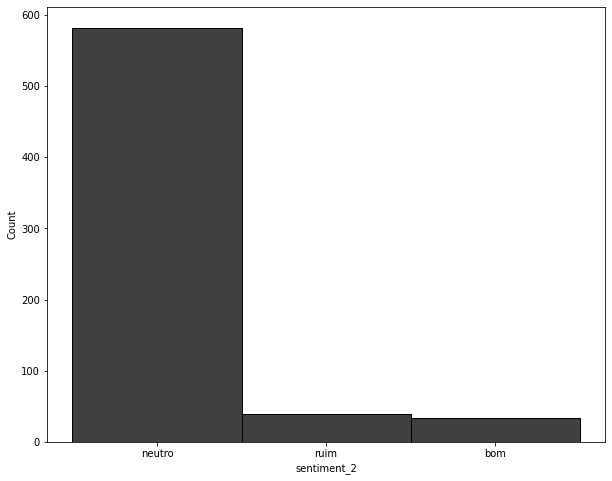

In [71]:
plt.figure(figsize = (10,8))
sns.histplot(x = df_clean['sentiment_2'], color = 'black')
plt.show()

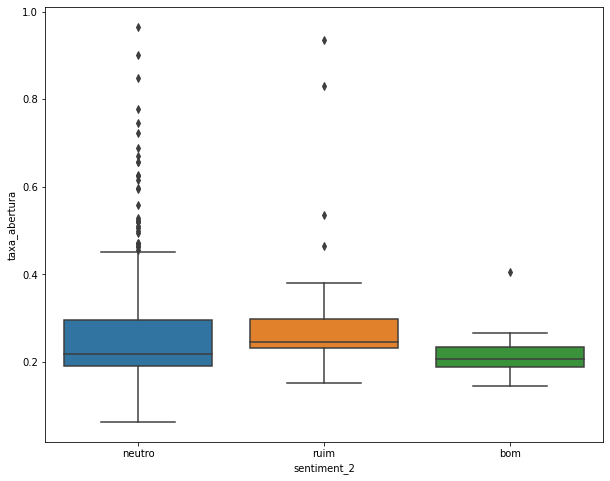

In [72]:
plt.figure(figsize = (10,8))
sns.boxplot(data = df_clean, y = 'taxa_abertura', x = 'sentiment_2')
plt.show()

In [73]:
print(df_clean[df_clean['sentiment_2'] == "bom"]['subject'].unique())

['sabia que tem um jeito de usar o cartão will sem precisar pagar a fatura?'
 'Mais dindim, crédito e um cartão will na sua mão                                                                                                                                                        '
 'Como usar o limite com mais consciência - pesquisar.                                                                                                                                                    '
 'Faz um pix com seu limite do cartão 🤑'
 'Quer mais limite pra chegar com tudo na Black Friday?                                                                                                                                                   '
 'viaje com will e ganhe dindim de volta!'
 'se faltar limite no seu cartão, a gente pode te ajudar!                                                                                                                                                 '
 'Seu dinheiro rendendo

In [538]:
df_clean.query('sentiment > 0.7')['subject'].head(20)

6                       última chance de ganhar R$1.000!
12           você aceita ganhar uma fatura paga do will?
19             parabéns! acabei de aumentar o seu limite
36     🔮 ainda tô vendo crédito chegando na sua fatur...
37     É indicação que fala? Aumente as chances de ap...
47             parabéns! acabei de aumentar o seu limite
76     super novidade will: pix no cartão de crédito....
99     Bora me indicar e aumentar as chances de aprov...
103          você aceita ganhar uma fatura paga do will?
118    Bora me indicar pra 3 pessoas e aumentar as ch...
121    Mensagem do dia: sua indicação ajuda a aumenta...
126    🚨 última chamada: me indica pra ganhar crédito...
137            parabéns! acabei de aumentar o seu limite
154    C de confiança: quem você me indicar tem mais ...
155    Bora me indicar pra 3 pessoas e aumentar as ch...
161    imagina ganhar R$1.000 para gastar nos seus re...
173            parabéns! acabei de aumentar o seu limite
183    É indicação que fala? Au

## Análise sintática

In [391]:
#!python3 -m spacy download pt_core_news_md

In [74]:
#Testando o spacy
import spacy
from spacy.lang.pt.examples import sentences 

nlp = spacy.load("pt_core_news_md")
doc = nlp(sentences[0])

In [75]:
doc

Apple está querendo comprar uma startup do Reino Unido por 100 milhões de dólares

In [76]:
def sintaxe(df, ds_message_tratada):
    df['classe'] = df[ds_message_tratada].apply(lambda x: [spacy.explain(y.pos_) for y in nlp(str(x))])
    classe = pd.DataFrame(df.classe.explode())
    classe['group'] = classe.index
    classe = classe.groupby(by = ['classe', 'group'], as_index = False).size()
    classe = classe.pivot_table(index=['group'],columns='classe',values='size',aggfunc='sum')
    classe[ds_message_tratada] = df[ds_message_tratada]
    classe = classe.groupby(by=[ds_message_tratada], as_index = False).sum()
    return classe

In [77]:
classe = sintaxe(df_clean, 'ds_message_tratada')

In [78]:
df_clean = df_clean.set_index('ds_message_tratada').join(classe.set_index('ds_message_tratada'), how = 'left', on = 'ds_message_tratada')
df_clean = df_clean.reset_index()

In [107]:
pd.crosstab(df_clean['fx_sentimento'], df_clean['n_palavras'], normalize="columns").iloc[:1,2:]

n_palavras,3,4,5,6,7,8,9,10
fx_sentimento,,,,,,,,
negativo,0.024194,0.030864,0.0375,0.0,0.038462,0.333333,0.705882,0.944444


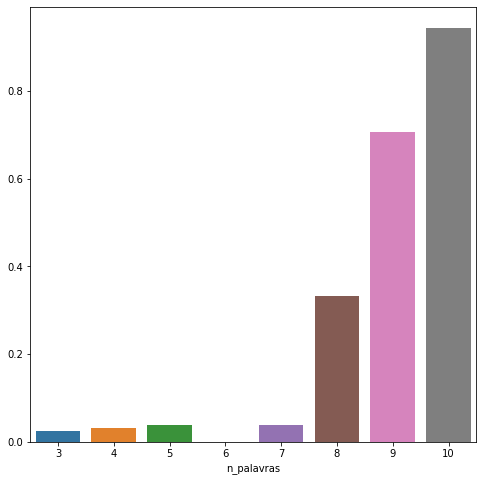

In [105]:
plt.figure(figsize=(8,8))
sns.barplot(data = pd.crosstab(df_clean['fx_sentimento'], df_clean['n_palavras'], normalize="columns").iloc[:1,2:])
plt.show()

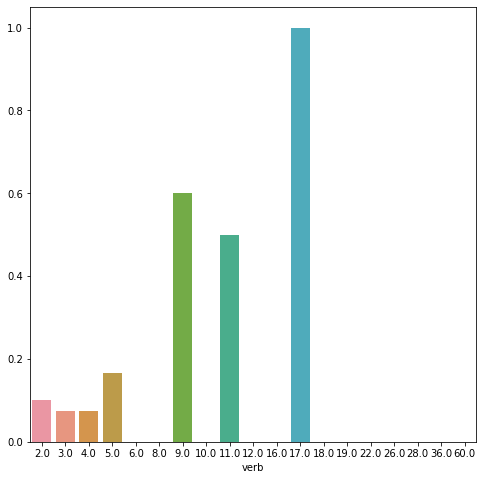

In [102]:
plt.figure(figsize=(8,8))
sns.barplot(data = pd.crosstab(df_clean['fx_sentimento'], df_clean['verb'], normalize="columns").iloc[:1,2:])
plt.show()

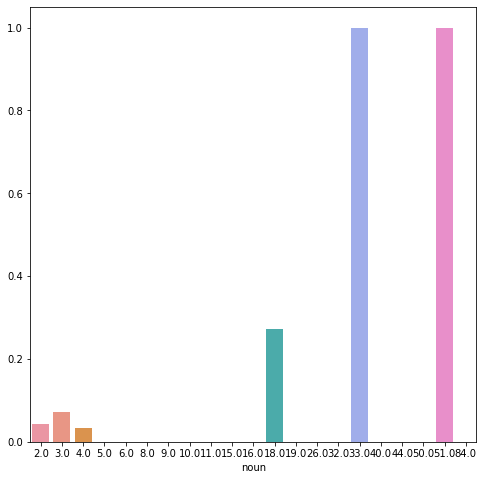

In [104]:
plt.figure(figsize=(8,8))
sns.barplot(data = pd.crosstab(df_clean['fx_sentimento'], df_clean['noun'], normalize="columns").iloc[:1,2:])
plt.show()

## Grupos de mensagens por análise sintática

In [171]:
df_clean.columns

Index(['ds_message_tratada', 'activityname', 'journeyname', 'tema', 'subject',
       'ferramenta', 'clientes', 'cliques', 'aberturas', 'dt_envio',
       'taxa_abertura', 'taxa_clique', 'flag_cobranca', 'flag_emoji',
       'flag_exclamacao', 'flag_dinheiro', 'flag_fatura', 'flag_limite',
       'flag_cashback', 'flag_nome', 'n_palavras', 'sentiment',
       'fx_sentimento', 'sentimento', 'sentiment_2', 'classe', 'adjective',
       'adposition', 'adverb', 'auxiliary', 'coordinating conjunction',
       'determiner', 'interjection', 'noun', 'numeral', 'other', 'pronoun',
       'proper noun', 'punctuation', 'space', 'subordinating conjunction',
       'symbol', 'verb', 'pca', 'pca_1', 'pca_2', 'cluster_hero',
       'cluster_dbscan', 'pca_1_tsne', 'pca_2_tsne', 'cluster_dbscan_tsne',
       'ano', 'dia', 'mes', 'dia_semana', 'hora'],
      dtype='object')

In [172]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score

In [177]:
k = 10
features_cluster = ['adjective', 'adposition', 'adverb',
       'auxiliary', 'coordinating conjunction', 'determiner', 'interjection',
       'noun', 'numeral', 'other', 'pronoun', 'proper noun', 'punctuation',
       'space', 'subordinating conjunction', 'symbol', 'verb']

base_cluster = df_clean[features_cluster]

for i in base_cluster.columns:
    base_cluster[i] = base_cluster[i].fillna(0.0)

kmeans = KMeans(n_clusters = k, random_state=0).fit(base_cluster)

cluster = kmeans.predict(base_cluster)

base_cluster['cluster'] = cluster
df_clean['cluster'] = cluster


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [178]:
print("---------------VOLUMETRIA ------------------")
print(base_cluster['cluster'].value_counts())
print(base_cluster['cluster'].value_counts(normalize = True))
print("---------------SILHOUETTE SCORE ------------")
print(silhouette_score(base_cluster[features_cluster], base_cluster['cluster']))

---------------VOLUMETRIA ------------------
0    434
5     32
3     32
6     28
8     26
1     25
2     22
7     20
4     18
9     17
Name: cluster, dtype: int64
0    0.663609
5    0.048930
3    0.048930
6    0.042813
8    0.039755
1    0.038226
2    0.033639
7    0.030581
4    0.027523
9    0.025994
Name: cluster, dtype: float64
---------------SILHOUETTE SCORE ------------
0.7493979824379331


In [179]:
print("---------------MEDIAS POR CLUSTER ------------")
cl_col = ['cluster']
totalfeat = features_cluster + cl_col
df_clean[totalfeat].groupby('cluster').mean()

---------------MEDIAS POR CLUSTER ------------


,adjective,adposition,adverb,auxiliary,coordinating conjunction,determiner,interjection,noun,numeral,other,pronoun,proper noun,punctuation,space,subordinating conjunction,symbol,verb
cluster,,,,,,,,,,,,,,,,,
0,1.504608,0.783410,0.631336,0.239631,0.004608,0.571429,0.004608,4.131336,0.182028,0.228111,0.476959,1.006912,0.016129,1.490783,0.057604,0.430876,3.864055
1,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000
3,32.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,0.000000,0.000000,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,36.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.843750,0.000000,0.000000,0.000000,0.000000,0.000000,21.843750,0.000000,0.000000,21.843750
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,84.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,28.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000
8,10.538462,7.769231,4.653846,0.000000,0.000000,0.000000,0.000000,24.346154,0.000000,0.000000,3.115385,18.307692,0.000000,7.769231,0.000000,0.000000,7.769231


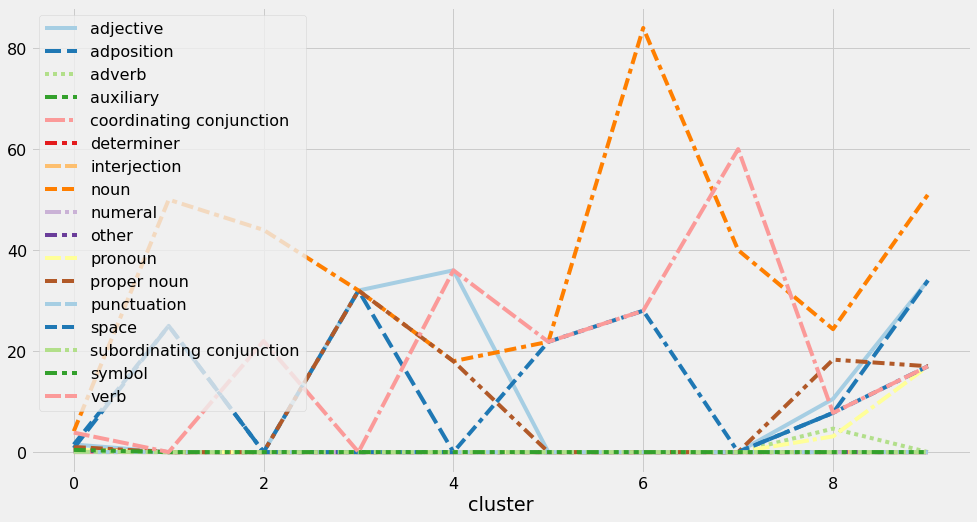

In [202]:
plt.figure(figsize=(15,8))
sns.lineplot(data = df_clean[totalfeat].groupby('cluster').mean(), palette = 'Paired')
plt.show()

In [181]:
df_clean[['taxa_abertura', 'cluster']].groupby('cluster').mean()

,taxa_abertura
cluster,
0,0.251107
1,0.219261
2,0.221680
3,0.378878
4,0.428491
5,0.189602
6,0.312260
7,0.199892
8,0.231477


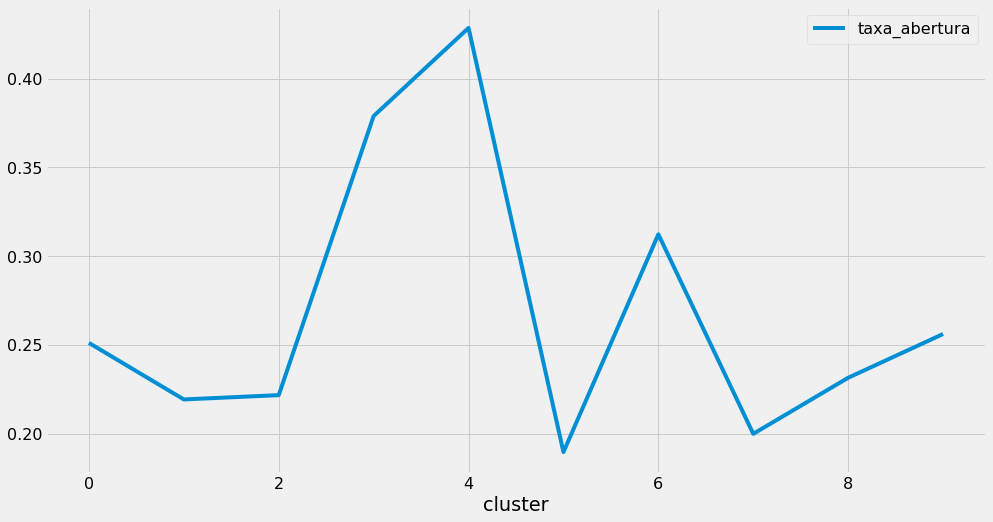

In [214]:
plt.figure(figsize=(15,8))
sns.lineplot(data = df_clean[['taxa_abertura', 'cluster']].groupby('cluster').mean())
plt.show()

In [203]:
print(df_clean[df_clean['cluster']  == 4]['subject'].unique())

['ei, vem ver seu novo limite. 😍'
 'ei, vem ver seu novo limite. 😍                                                                                                                                                                         ']


In [204]:
print(df_clean[df_clean['cluster']  == 3]['subject'].unique())

['Limite novo no 💳']


In [205]:
print(df_clean[df_clean['cluster']  == 6]['subject'].unique())

['Dicas pro seu limite aumentar de verdade.                                                                                                                                                               '
 'Dicas pro seu limite aumentar de verdade!'
 'Dicas pro seu limite aumentar de verdade.']


In [206]:
print(df_clean[df_clean['cluster']  == 0]['subject'].unique())

['o will tem R$1.000 para você' 'o will vai pagar MIL REAIS da sua fatura'
 'E se o will pagar a sua fatura deste mês?' 'Vontade de mais limite?'
 'Saiu a lista de ganhadores da #FaturaTurbinada!'
 'última chance de ganhar R$1.000!'
 'quer aumentar suas chances de ter um novo limite?'
 'Mais limite pro seu 💳?'
 'ela voltou: concorra a mil reais de desconto na fatura agora!'
 'você aceita ganhar uma fatura paga do will?'
 'concorra a R$1.000 usando o seu cartão agora!'
 'chegou no will: pix e boleto no crédito.                                                                                                                                                                '
 'a fatura está perto de fechar? Deixa que eu pago!'
 'parabéns! acabei de aumentar o seu limite'
 'Presente da sua mãe pago pelo will!'
 'concorra a R$ 1.000 toda semana usando o seu cartão will!'
 'Vem ver quem já ganhou R$1.000 do will                                                                                     

In [207]:
print(df_clean[df_clean['cluster']  == 9]['subject'].unique())

['Seu limite não aumentou na campanha Limite Back desta vez 😕']


In [215]:
print(df_clean[df_clean['cluster']  == 7]['subject'].unique())

['Compre, acumule pontos e troque por benefícios!                                                                                                                                                         '
 ' Compre, acumule pontos e troque por benefícios!']


In [208]:
print(df_clean[df_clean['cluster']  == 5]['subject'].unique())

['Como usar o limite com mais consciência - pesquisar.                                                                                                                                                    '
 'tá querendo mais facilidade?                                                                                                                                                                            '
 'tá querendo mais facilidade?'
 'Como usar o limite com mais consciência - pesquisar.']


## Vetorização TFID

In [114]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese') 
tfidf = TfidfVectorizer(max_df=0.99, min_df=1, stop_words=stopwords , ngram_range=(3,4), lowercase=True)
dtm = tfidf.fit_transform(df_clean['ds_message_tratada'])
nmf_model = TruncatedSVD(n_components=10, n_iter=5, random_state=0)
nmf_model.fit_transform(dtm)
single_topic = nmf_model.components_[0]
single_topic.argsort()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/flavia.costa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array([ 47, 362,  48, 727, 363, 728, 364, 250, 249, 596, 617, 616,   0,
       225, 224, 295, 897, 507, 508,  14,  13,  24,  23,  75, 863, 121,
       827, 538, 539, 247, 248, 828, 899,  88,  89, 511, 512, 485, 484,
       652,  96, 399, 398, 651, 302, 301, 252, 473, 106, 107, 892, 720,
       891, 190, 226, 189, 553, 554, 721, 464, 465, 829, 258, 493, 492,
       306, 259, 781, 782, 117, 483, 366, 729, 365,  49, 564, 441, 440,
       785, 786, 744, 867, 866, 565, 149, 805, 148, 497, 804, 307, 260,
       694, 312, 311, 644, 645,  44, 597, 204, 791, 853, 451, 852, 452,
       203, 755, 621, 622, 633, 632,  97, 197, 767, 335,  67,  66, 253,
       560, 359, 566, 567, 360, 412, 411, 525, 768, 503, 504, 778, 490,
       489, 144, 145, 705, 704, 797, 187, 395, 813, 396, 814, 186, 293,
       294,  79,  78, 115, 573, 574, 319, 269, 177, 885, 320, 141, 884,
       268, 176, 221, 161, 393, 394, 160, 410, 409, 243, 711, 413, 769,
       433, 434, 735, 741, 742, 456, 407, 406, 457, 734,   7,   

In [115]:
for index,topic in enumerate(nmf_model.components_):
    print(f'TOP WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-20:]])
    print('\n')

TOP WORDS FOR TOPIC #0
['feriado vem conferir servicos', 'feriado vem conferir', 'conferir servicos disponiveis', 'vem conferir servicos disponiveis', 'precisando dindim antecipa fgts', 'precisando dindim antecipa', 'dindim antecipa fgts', 'concorra toda semana', 'usando cartao will', 'semana usando cartao will', 'toda semana usando', 'toda semana usando cartao', 'concorra toda semana usando', 'semana usando cartao', 'ipva escola resolver', 'iptu ipva escola resolver', 'iptu ipva escola', 'vem conhecer emoji', 'dindim volta quer', 'limite novo emoji']


TOP WORDS FOR TOPIC #1
['precisar pagar fatura', 'jeito usar cartao', 'sabia jeito usar cartao', 'sabia jeito usar', 'usar cartao will precisar', 'will precisar pagar', 'will precisar pagar fatura', 'precisando dindim antecipa', 'precisando dindim antecipa fgts', 'dindim antecipa fgts', 'grana extra bora antecipar', 'precisando grana extra', 'extra bora antecipar fgts', 'extra bora antecipar', 'precisando grana extra bora', 'bora anteci

## VETORIZAÇÃO TEXT HERO

In [116]:
import texthero as hero

df_clean['pca'] = (
   df_clean['ds_message_tratada']
   .pipe(hero.clean)
   .pipe(hero.tfidf)
   .pipe(hero.pca)
)

df_clean['pca_1'] = df_clean['pca'].astype('string').str.split(",").str[1]
df_clean['pca_2'] = df_clean['pca'].astype('string').str.split(",").str[0]

for i in ['pca_1','pca_2']:
    df_clean[i] = df_clean[i].str.replace(']','').str.replace('[','').astype("float")

kmeans = KMeans(n_clusters=15).fit(df_clean[['pca_1','pca_2']])
cluster = kmeans.predict(df_clean[['pca_1','pca_2']])

df_clean['cluster_hero'] = cluster

In [117]:
df_clean['cluster_hero'].value_counts()

6     176
2      74
9      66
1      44
0      37
12     35
5      32
10     29
4      28
8      27
14     25
3      25
11     24
7      23
13      9
Name: cluster_hero, dtype: int64

In [275]:
print(df_clean[df_clean['cluster_hero']  == 4]['subject'].unique())

['Dicas pro seu limite aumentar de verdade.                                                                                                                                                               '
 'Dicas pro seu limite aumentar de verdade!'
 'Dicas pro seu limite aumentar de verdade.']


In [276]:
print(df_clean[df_clean['cluster_hero']  == 11]['subject'].unique())

['ei, vem ver seu novo limite. 😍'
 'ei, vem ver seu novo limite. 😍                                                                                                                                                                         '
 'ei, vem ver seu novo limite.']


## Criando Grupos (clusters) em cima da vetorização text hero

In [118]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps = 0.03).fit(X)
cluster_dbscan = clustering.fit_predict(df_clean[['pca_1','pca_2']])

In [119]:
df_clean['cluster_dbscan'] = cluster_dbscan

In [120]:
df_clean['cluster_dbscan'].value_counts()

 0     312
 1      37
-1      35
 4      35
 17     32
 8      28
 18     28
 5      25
 9      22
 2      18
 6      13
 11     12
 19      9
 3       8
 10      7
 7       6
 12      6
 14      6
 13      5
 15      5
 16      5
Name: cluster_dbscan, dtype: int64

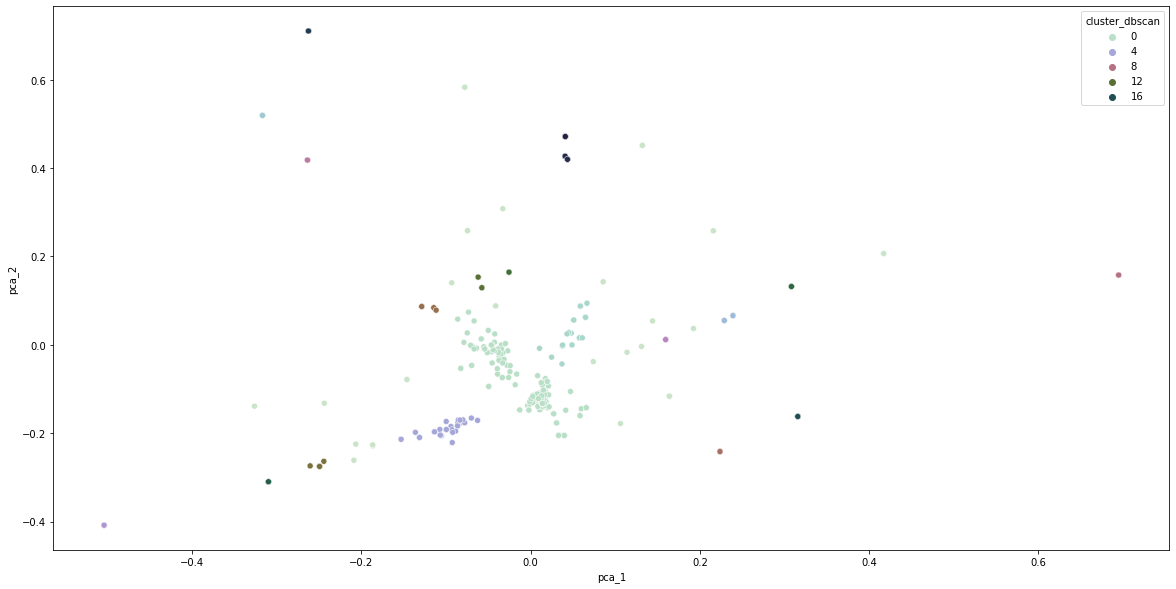

In [121]:
plt.figure(figsize=(20,10))
sns.scatterplot(data = df_clean, x = 'pca_1', y = 'pca_2',  hue = 'cluster_dbscan', palette="ch:s=1,rot=-2")
plt.show()

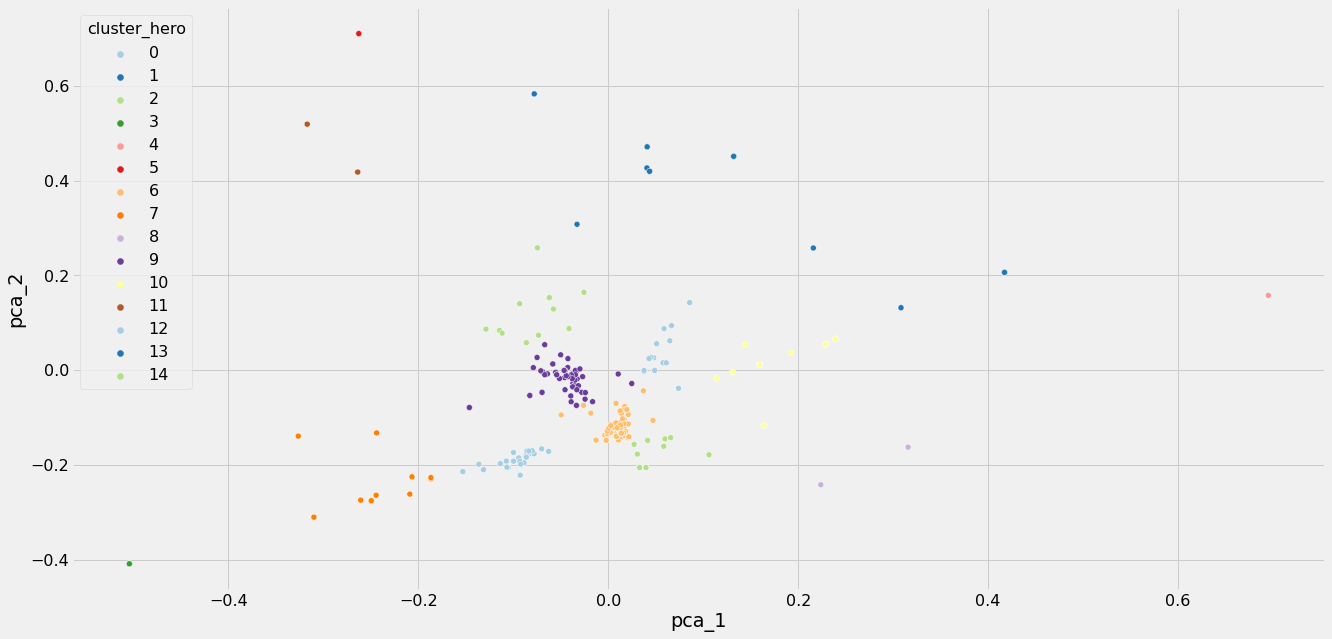

In [235]:
plt.figure(figsize=(20,10))
sns.scatterplot(data = df_clean, x = 'pca_1', y = 'pca_2', hue='cluster_hero', palette="Paired", legend = "full")
plt.show()

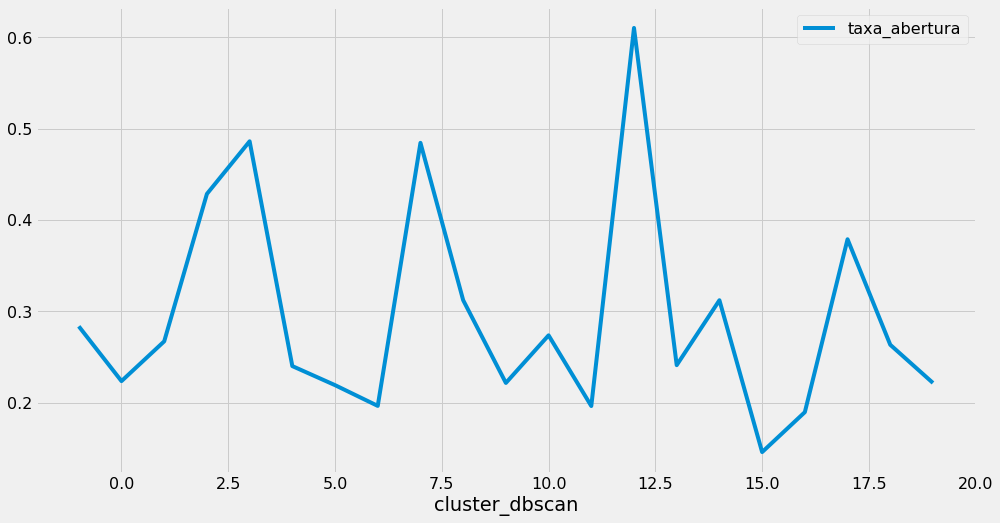

In [231]:
plt.figure(figsize=(15,8))
sns.lineplot(data = df_clean[['taxa_abertura', 'cluster_dbscan']].groupby('cluster_dbscan').mean())
plt.show()

In [273]:
print(df_clean[df_clean['cluster_dbscan']  == 12]['subject'].unique())

['limite novo pra deixar o dia das mães turbinado'
 'Uhuuu! Chegou limite novo pra vc!'
 'Uhuuu! Chegou limite novo pra vc!                                                                                                                                                                       ']


In [274]:
print(df_clean[df_clean['cluster_dbscan']  == 13]['subject'].unique())

['Alô, aumento de limite?  🚨                                                                                                                                                                             ']


In [277]:
print(df_clean[df_clean['cluster_dbscan']  == 14]['subject'].unique())

['Quer aumentar seu limite?                                                                                                                                                                               ']


In [284]:
print(df_clean[df_clean['cluster_dbscan']  == 0]['subject'].unique())

['o will tem R$1.000 para você' 'o will vai pagar MIL REAIS da sua fatura'
 'E se o will pagar a sua fatura deste mês?'
 'Saiu a lista de ganhadores da #FaturaTurbinada!'
 'última chance de ganhar R$1.000!'
 'ela voltou: concorra a mil reais de desconto na fatura agora!'
 'você aceita ganhar uma fatura paga do will?'
 'concorra a R$1.000 usando o seu cartão agora!'
 'chegou no will: pix e boleto no crédito.                                                                                                                                                                '
 'a fatura está perto de fechar? Deixa que eu pago!'
 'Presente da sua mãe pago pelo will!'
 'concorra a R$ 1.000 toda semana usando o seu cartão will!'
 'Vem ver quem já ganhou R$1.000 do will                                                                                                                                                                  '
 'contas no fim do mês? antecipe seu FGTS                              

In [232]:
print(df_clean[df_clean['cluster_dbscan_tsne']  == 3]['subject'].unique())

['Mais limite pro seu 💳?'
 'Mais limite, sim!                                                                                                                                                                                       '
 'Mais limite, sim!'
 'Seu limite ainda não aumentou na campanha Limite Back 😕'
 'Seu limite não aumentou na campanha Limite Back desta vez 😕'
 'Seu limite não aumentou na campanha Limite Back 😕']


In [236]:
print(df_clean[df_clean['cluster_dbscan_tsne']  == 7]['subject'].unique())

['sabia que tem um jeito de usar o cartão will sem precisar pagar a fatura?'
 'tá querendo um programa de benéficos?                                                                                                                                                                   '
 'Dicas pra melhor uso do seu cartão de crédito will!'
 'amarelinho no débito: vantagens mil!                                                                                                                                                                    '
 'Já conheceu as vantagens de ter o will na mão?                                                                                                                                                          '
 'Vontade de ter + benefícios?'
 'faltou algum item da fármacia aí? Use o amarelinho e concorra a uma fatura paga!'
 'conheça as vantagens do seu débito will.                                                                                                  

In [239]:
print(df_clean[df_clean['cluster_dbscan_tsne']  == 6]['subject'].unique())

['Vem ver quem já ganhou R$1.000 do will                                                                                                                                                                  '
 '💵extra em 30 min?                                                                                                                                                                                      '
 'Vem ver quem já ganhou R$1.000 do will'
 'Dia dos ❤️ com até 30% cashback 🥰💸'
 'Dia dos Pais: quero saber sua opinião 💛'
 '🤑 Tem um LIMITE SURPRESA neste e-mail.'
 'Falta pouco pra antecipar seu dindim 💛                                                                                                                                                                 '
 'Mega promo nas Casas Bahia e no Ponto 💥'
 '🚨Aumentou! Boticário tá com 10% de cashback!🚨'
 '🚨SÓ HOJE: Magalu c/ 13% de cashback 🚨'
 '🚨SÓ HOJE: Magalu c/ 13% de cashback🚨                                                      

In [240]:
print(df_clean[df_clean['cluster_dbscan_tsne']  == 9]['subject'].unique())

['Compre, acumule pontos e troque por benefícios!                                                                                                                                                         '
 ' Compre, acumule pontos e troque por benefícios!'
 'tá querendo mais facilidade?                                                                                                                                                                            '
 'tá querendo mais facilidade?']


In [238]:
print(df_clean[df_clean['cluster_dbscan_tsne']  == 17]['subject'].unique())

[]


## Ajustando a vetorização para método TSNE

In [123]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_t = tsne.fit_transform(df_clean[['pca_1','pca_2']])


In [124]:
pca_tsne = pd.DataFrame(X_t, columns = ['pca_1', 'pca_2'])

In [125]:
df_clean['pca_1_tsne'] = pca_tsne['pca_1']
df_clean['pca_2_tsne'] = pca_tsne['pca_2']

## Clusters nos vetores ajustados TSNE

In [126]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps = 4).fit(X)
cluster_dbscan_tsne = clustering.fit_predict(df_clean[['pca_1_tsne','pca_2_tsne']])
df_clean['cluster_dbscan_tsne'] = cluster_dbscan_tsne
df_clean['cluster_dbscan_tsne'].value_counts()

2     98
6     97
0     70
8     58
3     43
1     40
7     39
9     39
5     34
13    32
11    28
12    27
10    25
4     24
Name: cluster_dbscan_tsne, dtype: int64

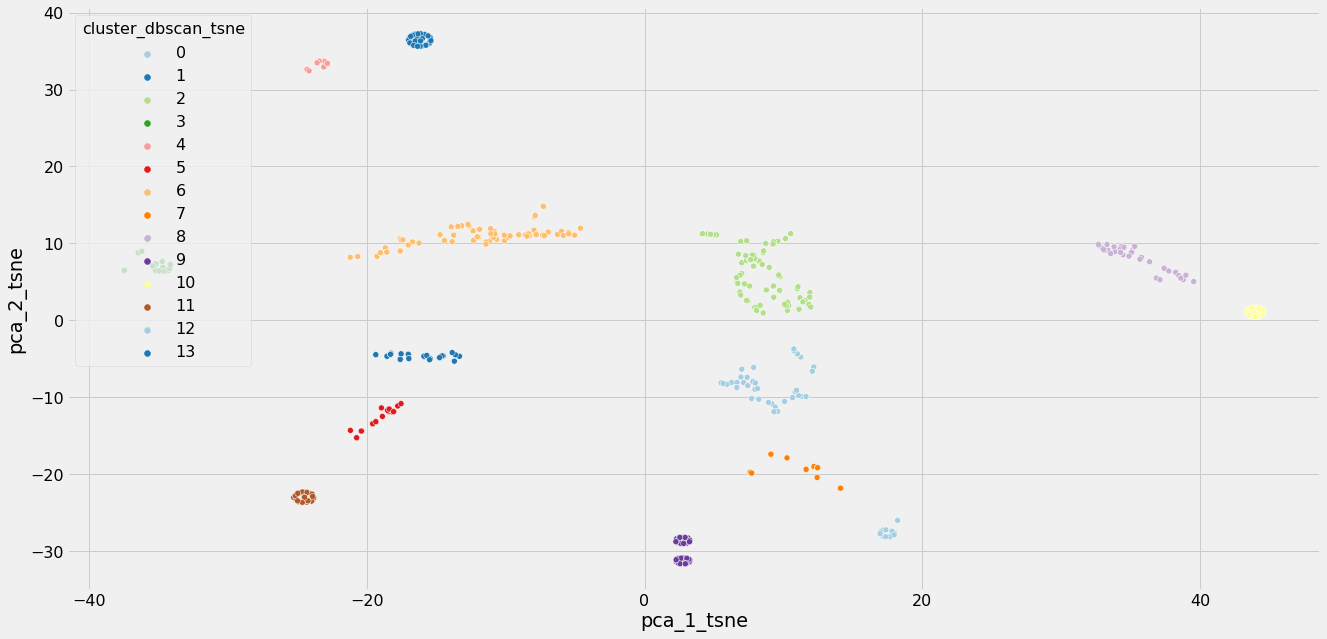

In [237]:
plt.figure(figsize=(20,10))
sns.scatterplot(data = df_clean, x = 'pca_1_tsne', y = 'pca_2_tsne', hue='cluster_dbscan_tsne', palette="Paired", legend = "full")
plt.show()

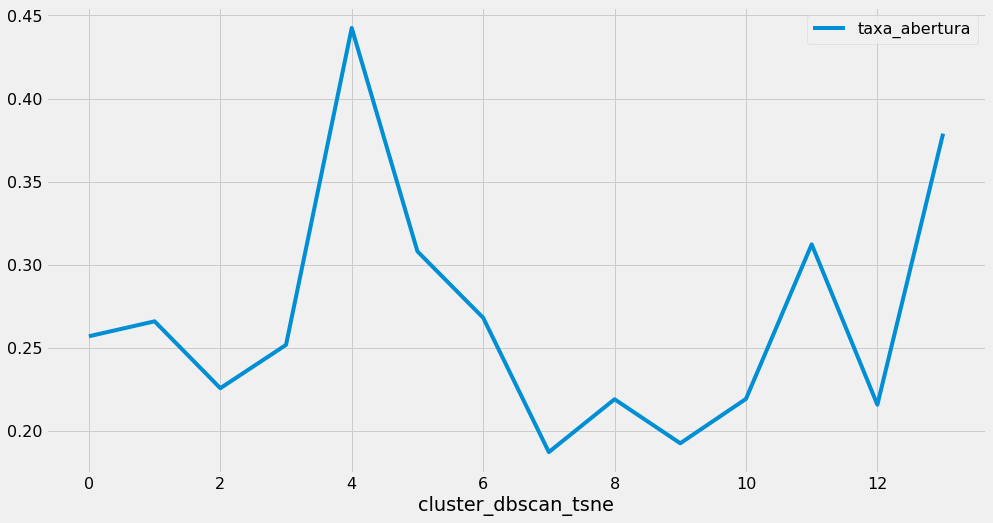

In [223]:
plt.figure(figsize=(15,8))
sns.lineplot(data = df_clean[['taxa_abertura', 'cluster_dbscan_tsne']].groupby('cluster_dbscan_tsne').mean())
plt.show()

In [224]:
print(df_clean[df_clean['cluster_dbscan_tsne']  == 4]['subject'].unique())

['ei, vem ver seu novo limite. 😍'
 'ei, vem ver seu novo limite. 😍                                                                                                                                                                         '
 'ei, vem ver seu novo limite.']


In [225]:
print(df_clean[df_clean['cluster_dbscan_tsne']  == 11]['subject'].unique())

['Dicas pro seu limite aumentar de verdade.                                                                                                                                                               '
 'Dicas pro seu limite aumentar de verdade!'
 'Dicas pro seu limite aumentar de verdade.']


In [226]:
print(df_clean[df_clean['cluster_dbscan_tsne']  == 13]['subject'].unique())

['Limite novo no 💳']


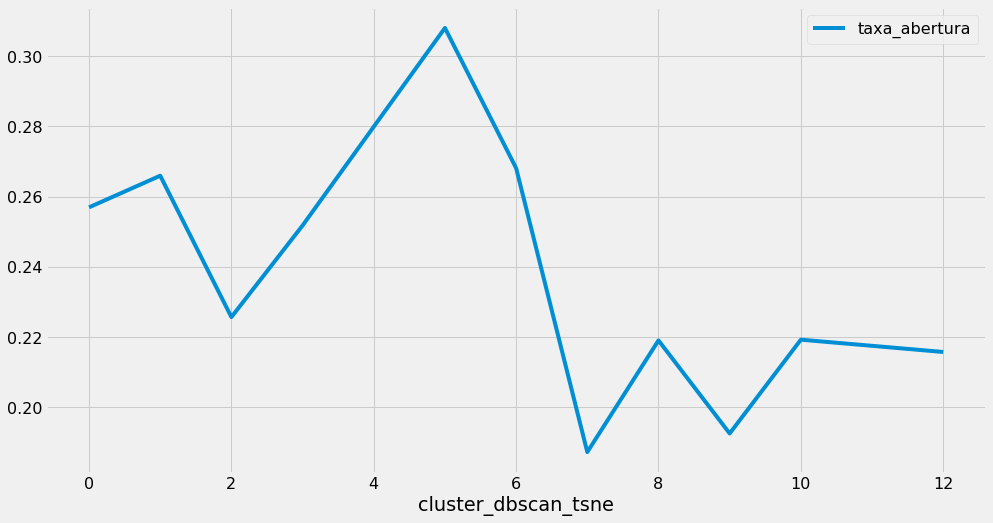

In [227]:
plt.figure(figsize=(15,8))
sns.lineplot(data = df_clean.query('cluster_dbscan_tsne != 4').query('cluster_dbscan_tsne != 11').query('cluster_dbscan_tsne != 13')[['taxa_abertura', 'cluster_dbscan_tsne']].groupby('cluster_dbscan_tsne').mean())
plt.show()

In [228]:
print(df_clean[df_clean['cluster_dbscan_tsne']  == 5]['subject'].unique())

['parabéns! acabei de aumentar o seu limite'
 'Bora jogar pra aumentar seu limite!                                                                                                                                                                     '
 'Como usar o limite com mais consciência - pesquisar.                                                                                                                                                    '
 'Como aumentar o limite: pesquisar 👇                                                                                                                                                                    '
 'Quer aumentar seu limite?                                                                                                                                                                               '
 'Aumentar o limite nunca foi tão fácil!                                                                                                    

In [229]:
print(df_clean[df_clean['cluster_dbscan_tsne']  == 1]['subject'].unique())

['Vontade de mais limite?'
 'quer aumentar suas chances de ter um novo limite?'
 'Ninguém te dá mais limite?                                                                                                                                                                              '
 'Ter limite é bom demais <3                                                                                                                                                                              '
 'Aumentei seu limite!                                                                                                                                                                                    '
 'Tá afim de mais limite no seu will? Então bora jogar!                                                                                                                                                   '
 'Limite sobrando no seu amarelinho pra você aproveitar o natal!                                        

In [230]:
print(df_clean[df_clean['cluster_dbscan_tsne']  == 7]['subject'].unique())

['sabia que tem um jeito de usar o cartão will sem precisar pagar a fatura?'
 'tá querendo um programa de benéficos?                                                                                                                                                                   '
 'Dicas pra melhor uso do seu cartão de crédito will!'
 'amarelinho no débito: vantagens mil!                                                                                                                                                                    '
 'Já conheceu as vantagens de ter o will na mão?                                                                                                                                                          '
 'Vontade de ter + benefícios?'
 'faltou algum item da fármacia aí? Use o amarelinho e concorra a uma fatura paga!'
 'conheça as vantagens do seu débito will.                                                                                                  

In [241]:
print(df_clean[df_clean['cluster_dbscan_tsne']  == 6]['subject'].unique())

['Vem ver quem já ganhou R$1.000 do will                                                                                                                                                                  '
 '💵extra em 30 min?                                                                                                                                                                                      '
 'Vem ver quem já ganhou R$1.000 do will'
 'Dia dos ❤️ com até 30% cashback 🥰💸'
 'Dia dos Pais: quero saber sua opinião 💛'
 '🤑 Tem um LIMITE SURPRESA neste e-mail.'
 'Falta pouco pra antecipar seu dindim 💛                                                                                                                                                                 '
 'Mega promo nas Casas Bahia e no Ponto 💥'
 '🚨Aumentou! Boticário tá com 10% de cashback!🚨'
 '🚨SÓ HOJE: Magalu c/ 13% de cashback 🚨'
 '🚨SÓ HOJE: Magalu c/ 13% de cashback🚨                                                      

In [242]:
print(df_clean[df_clean['cluster_dbscan_tsne']  == 0]['subject'].unique())

['o will tem R$1.000 para você' 'o will vai pagar MIL REAIS da sua fatura'
 'E se o will pagar a sua fatura deste mês?'
 'você aceita ganhar uma fatura paga do will?'
 'concorra a R$1.000 usando o seu cartão agora!'
 'chegou no will: pix e boleto no crédito.                                                                                                                                                                '
 'concorra a R$ 1.000 toda semana usando o seu cartão will!'
 'contas no fim do mês? antecipe seu FGTS                                                                                                                                                                 '
 'vai deixar de ganhar uma fatura paga?'
 'Precisando de grana extra? Bora antecipar o FGTS!                                                                                                                                                       '
 'super novidade will: pix no cartão de crédito.                      

In [244]:
print(df_clean[df_clean['cluster_dbscan_tsne']  == 7]['subject'].unique())

['sabia que tem um jeito de usar o cartão will sem precisar pagar a fatura?'
 'tá querendo um programa de benéficos?                                                                                                                                                                   '
 'Dicas pra melhor uso do seu cartão de crédito will!'
 'amarelinho no débito: vantagens mil!                                                                                                                                                                    '
 'Já conheceu as vantagens de ter o will na mão?                                                                                                                                                          '
 'Vontade de ter + benefícios?'
 'faltou algum item da fármacia aí? Use o amarelinho e concorra a uma fatura paga!'
 'conheça as vantagens do seu débito will.                                                                                                  

## Checando vocábulos por clusters

In [128]:
cl = df_clean['cluster_dbscan'].unique()

for i in cl:
    print("================= CLUSTER " + str(i) + "===========")
    print(df_clean[['cluster_dbscan','ds_message_tratada']][df_clean['cluster_dbscan'] == i].value_counts(normalize=True))

================= CLUSTER 0===========
cluster_dbscan  ds_message_tratada                                  
0               compre acumule pontos troque beneficios                 0.064103
                 querendo facilidade                                    0.060897
                 querendo programa beneficos                            0.035256
                vontade ter + beneficios                                0.028846
                seguranca praticidade comprar                           0.025641
                                                                          ...   
                fofoca aceito nova versao do app will chegando emoji    0.003205
                 will vai pagar mil reais  fatura                       0.003205
                fez compra no mercado gente pode pagar fatura quer      0.003205
                $$ extra  perto do  imagina                             0.003205
                  hoje pago                                             0.003205
L

In [129]:
cl = df_clean['cluster_dbscan_tsne'].unique()

for i in cl:
    print("================= CLUSTER " + str(i) + "===========")
    print(df_clean[['cluster_dbscan_tsne','ds_message_tratada']][df_clean['cluster_dbscan_tsne'] == i].value_counts(normalize=True))

================= CLUSTER 0===========
cluster_dbscan_tsne  ds_message_tratada                                    
0                    seguranca praticidade comprar                             0.114286
                     precisando grana extra bora antecipar fgts                0.057143
                     concorra r$  toda semana usando  cartao will              0.057143
                     pix                                                       0.042857
                     ja usou pix galaxias                                      0.042857
                     antecipe fgts receba ate min                              0.042857
                     imagina ganhar fatura paga r$ no dias maes                0.042857
                      antecipar saque do fgts no will                          0.042857
                      aceita ganhar fatura paga do will                        0.028571
                     fatura paga nas suas compras farmacia                     0.028571
     

## Cruzando os tres clusters com flags de fatura, limite e sentimento

In [130]:
pd.crosstab(df_clean['flag_fatura'], df_clean['cluster_hero'], normalize="columns")

cluster_hero,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
flag_fatura,,,,,,,,,,,,,,,
0,1.0,1.0,0.932432,1.0,1.0,1.0,0.806818,1.0,1.0,0.984848,1.0,1.0,0.942857,1.0,1.0
1,0.0,0.0,0.067568,0.0,0.0,0.0,0.193182,0.0,0.0,0.015152,0.0,0.0,0.057143,0.0,0.0


In [131]:
pd.crosstab(df_clean['flag_fatura'], df_clean['cluster_dbscan'], normalize="columns")

cluster_dbscan,-1,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
flag_fatura,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.871795,1.0,1.0,1.0,0.942857,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.128205,0.0,0.0,0.0,0.057143,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
pd.crosstab(df_clean['flag_fatura'], df_clean['cluster_dbscan_tsne'], normalize="columns")

cluster_dbscan_tsne,0,1,2,3,4,5,6,7,8,9,10,11,12,13
flag_fatura,,,,,,,,,,,,,,
0,0.628571,1.0,0.918367,1.0,1.0,1.0,0.989691,0.871795,0.965517,1.0,1.0,1.0,1.0,1.0
1,0.371429,0.0,0.081633,0.0,0.0,0.0,0.010309,0.128205,0.034483,0.0,0.0,0.0,0.0,0.0


In [133]:
pd.crosstab(df_clean['flag_limite'], df_clean['cluster_hero'], normalize="columns")

cluster_hero,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
flag_limite,,,,,,,,,,,,,,,
0,0.0,0.0,1.0,1.0,0.0,0.0,0.994318,1.0,1.0,0.954545,0.137931,0.0,1.0,0.0,0.4
1,1.0,1.0,0.0,0.0,1.0,1.0,0.005682,0.0,0.0,0.045455,0.862069,1.0,0.0,1.0,0.6


In [134]:
pd.crosstab(df_clean['flag_limite'], df_clean['cluster_dbscan'], normalize="columns")

cluster_dbscan,-1,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
flag_limite,,,,,,,,,,,,,,,,,,,,,
0,0.4,0.99359,0.027027,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.6,0.00641,0.972973,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [135]:
pd.crosstab(df_clean['flag_limite'], df_clean['cluster_dbscan_tsne'], normalize="columns")

cluster_dbscan_tsne,0,1,2,3,4,5,6,7,8,9,10,11,12,13
flag_limite,,,,,,,,,,,,,,
0,1.0,0.025,1.0,0.0,0.0,0.0,0.814433,1.0,1.0,1.0,1.0,0.0,1.0,0.0
1,0.0,0.975,0.0,1.0,1.0,1.0,0.185567,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [137]:
pd.crosstab(df_clean['fx_sentimento'], df_clean['cluster_hero'], normalize="columns")

cluster_hero,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
fx_sentimento,,,,,,,,,,,,,,,
negativo,0.000000,0.840909,0.000000,0.0,0.0,0.0,0.056818,0.00000,0.000000,0.090909,0.000000,0.0,0.028571,0.0,0.0
neutro,0.702703,0.136364,0.216216,1.0,0.0,1.0,0.625000,0.26087,0.185185,0.560606,0.482759,1.0,0.742857,0.0,0.8
positivo,0.297297,0.022727,0.783784,0.0,1.0,0.0,0.318182,0.73913,0.814815,0.348485,0.517241,0.0,0.228571,1.0,0.2


In [138]:
pd.crosstab(df_clean['sentiment_2'], df_clean['cluster_dbscan'], normalize="columns")

cluster_dbscan,-1,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
sentiment_2,,,,,,,,,,,,,,,,,,,,,
bom,0.057143,0.022436,0.135135,0.0,0.0,0.114286,0.0,1.0,0.0,0.0,...,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
neutro,0.771429,0.961538,0.864865,1.0,1.0,0.885714,1.0,0.0,1.0,1.0,...,1.0,0.833333,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
ruim,0.171429,0.016026,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [139]:
pd.crosstab(df_clean['fx_sentimento'], df_clean['cluster_dbscan_tsne'], normalize="columns")

cluster_dbscan_tsne,0,1,2,3,4,5,6,7,8,9,10,11,12,13
fx_sentimento,,,,,,,,,,,,,,
negativo,0.028571,0.025,0.081633,0.860465,0.0,0.000000,0.051546,0.000000,0.017241,0.0,0.0,0.0,0.000000,0.0
neutro,0.528571,0.700,0.714286,0.139535,1.0,0.411765,0.597938,0.410256,0.551724,0.0,1.0,0.0,0.185185,1.0
positivo,0.442857,0.275,0.204082,0.000000,0.0,0.588235,0.350515,0.589744,0.431034,1.0,0.0,1.0,0.814815,0.0


In [140]:
pd.crosstab(df_clean['ferramenta'], df_clean['cluster_dbscan'], normalize="columns")

cluster_dbscan,-1,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
ferramenta,,,,,,,,,,,,,,,,,,,,,
Infobip,0.514286,0.615385,0.324324,0.666667,0.625,0.114286,0.76,0.153846,1.0,0.678571,...,0.714286,0.166667,0.666667,0.0,0.0,0.2,1.0,1.0,1.0,1.0
Salesforce,0.485714,0.384615,0.675676,0.333333,0.375,0.885714,0.24,0.846154,0.0,0.321429,...,0.285714,0.833333,0.333333,1.0,1.0,0.8,0.0,0.0,0.0,0.0


In [243]:
pd.crosstab(df_clean['flag_emoji'], df_clean['cluster_dbscan_tsne'], normalize="columns")

cluster_dbscan_tsne,0,1,2,3,4,5,6,7,8,9,10,11,12,13
flag_emoji,,,,,,,,,,,,,,
0,1.0,0.975,0.979592,0.093023,0.25,0.941176,0.298969,1.0,0.965517,1.0,1.0,1.0,1.0,0.0
1,0.0,0.025,0.020408,0.906977,0.75,0.058824,0.701031,0.0,0.034483,0.0,0.0,0.0,0.0,1.0


## Visualização de trigrams por clusters

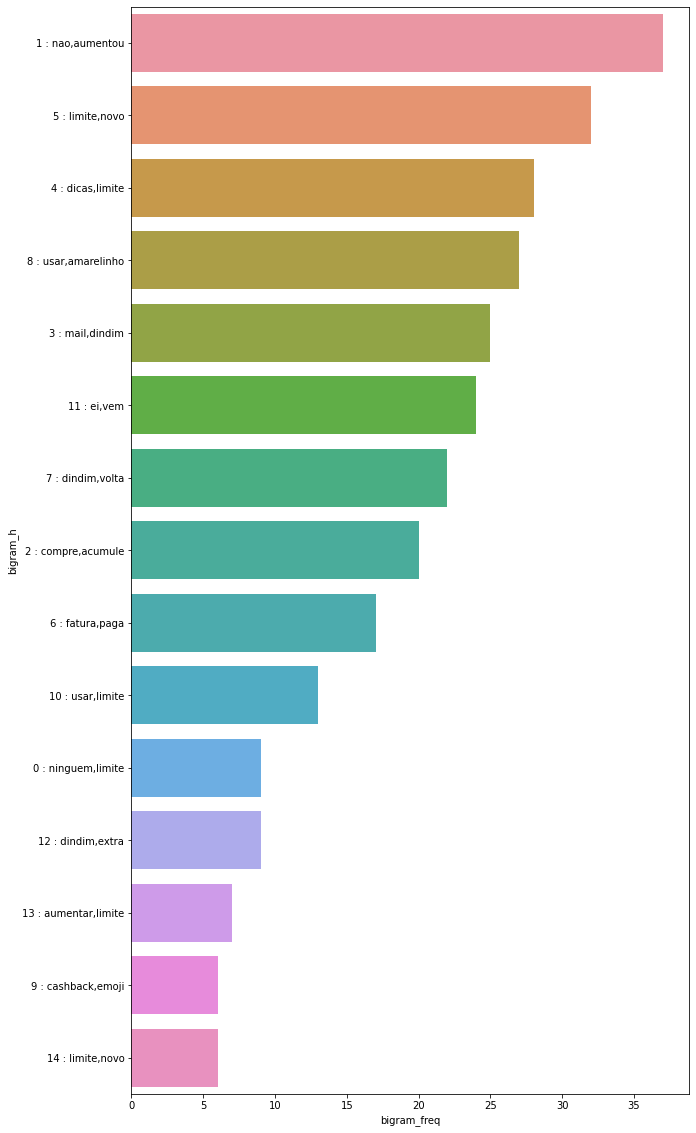

In [141]:
def ranking_cluster(df_clean, cluster, campo_texto, campo_data):
    
    df_agg_ungroup_final = pd.DataFrame([], columns=['unigram', 'unigram_freq',
                                                     'bigram','bigram_freq','trigram','trigram_freq', 'cluster'])
    
    for i in df_clean[cluster].unique():
        try:
            df_clean_tmp = df_clean[df_clean[cluster] == i ]
            df_agg_ungroup_tmp = arabica_freq(
                text = df_clean_tmp[campo_texto],
                time = df_clean_tmp[campo_data],
                time_freq = 'ungroup',           # opção ungroup
                max_words = 10,             
                stopwords = ['portuguese'],   
                skip = [stopwords_will],         
                numbers = True,            
                punct = True,              
                lower_case = True) 
            
            result_temp = pd.DataFrame({'unigram': df_agg_ungroup_tmp['unigram'], 'unigram_freq': df_agg_ungroup_tmp['unigram_freq'],
                                        'bigram': df_agg_ungroup_tmp['bigram'], 'bigram_freq': df_agg_ungroup_tmp['bigram_freq'],
                                        'trigram': df_agg_ungroup_tmp['trigram'], 'trigram_freq': df_agg_ungroup_tmp['trigram_freq']}, index=[0])
            
            result_temp['cluster'] = i
                    
            df_agg_ungroup_final = df_agg_ungroup_final.append(result_temp)

        except IndexError:
            pass
                
    return df_agg_ungroup_final

df_resumo = ranking_cluster(df_clean, 'cluster_hero', 'ds_message_tratada', 'dt_envio')
df_resumo['unigram_freq'] = df_resumo['unigram_freq'].astype('int')
df_resumo['bigram_freq'] = df_resumo['bigram_freq'].astype('int')
df_resumo['trigram_freq'] = df_resumo['trigram_freq'].astype('int')
df_resumo['cluster'] = df_resumo['cluster'].astype('str')

df_resumo['unigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['unigram']
df_resumo['bigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['bigram']
df_resumo['trigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['trigram']

plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='bigram_freq', ascending=False), x = 'bigram_freq', y = 'bigram_h')
plt.show()

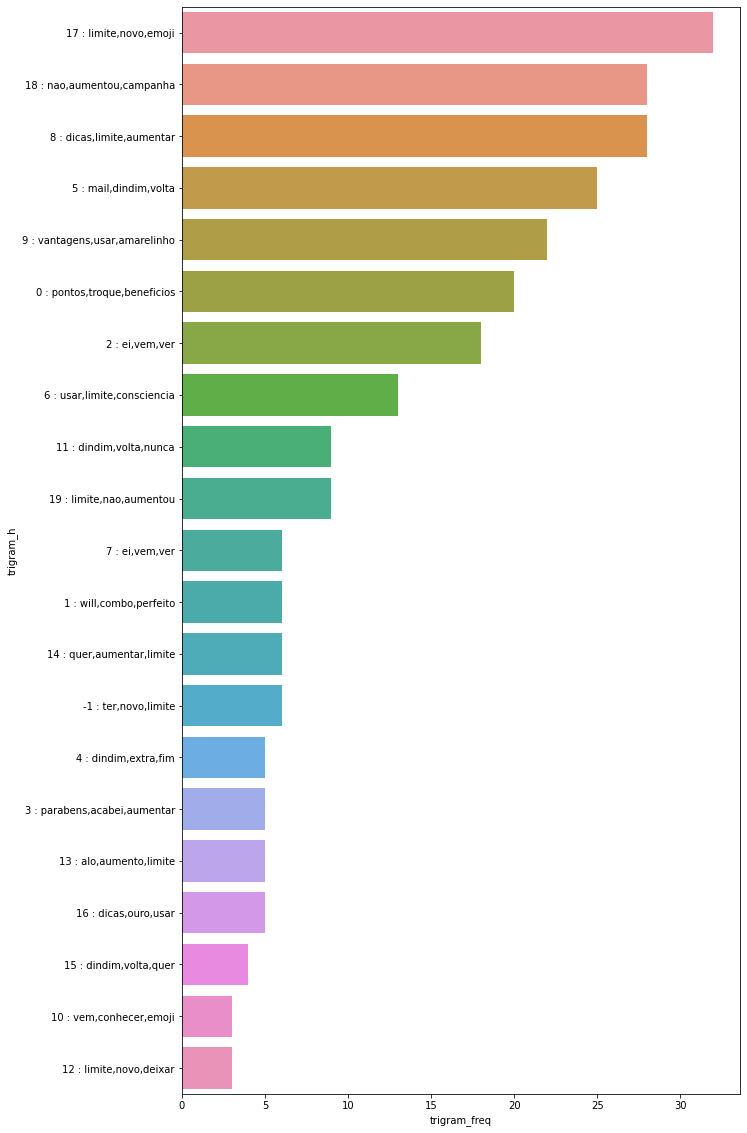

In [142]:
df_resumo = ranking_cluster(df_clean, 'cluster_dbscan', 'ds_message_tratada', 'dt_envio')
df_resumo['unigram_freq'] = df_resumo['unigram_freq'].astype('int')
df_resumo['bigram_freq'] = df_resumo['bigram_freq'].astype('int')
df_resumo['trigram_freq'] = df_resumo['trigram_freq'].astype('int')
df_resumo['cluster'] = df_resumo['cluster'].astype('str')

df_resumo['unigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['unigram']
df_resumo['bigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['bigram']
df_resumo['trigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['trigram']

plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='trigram_freq', ascending=False), x = 'trigram_freq', y = 'trigram_h')
plt.show()

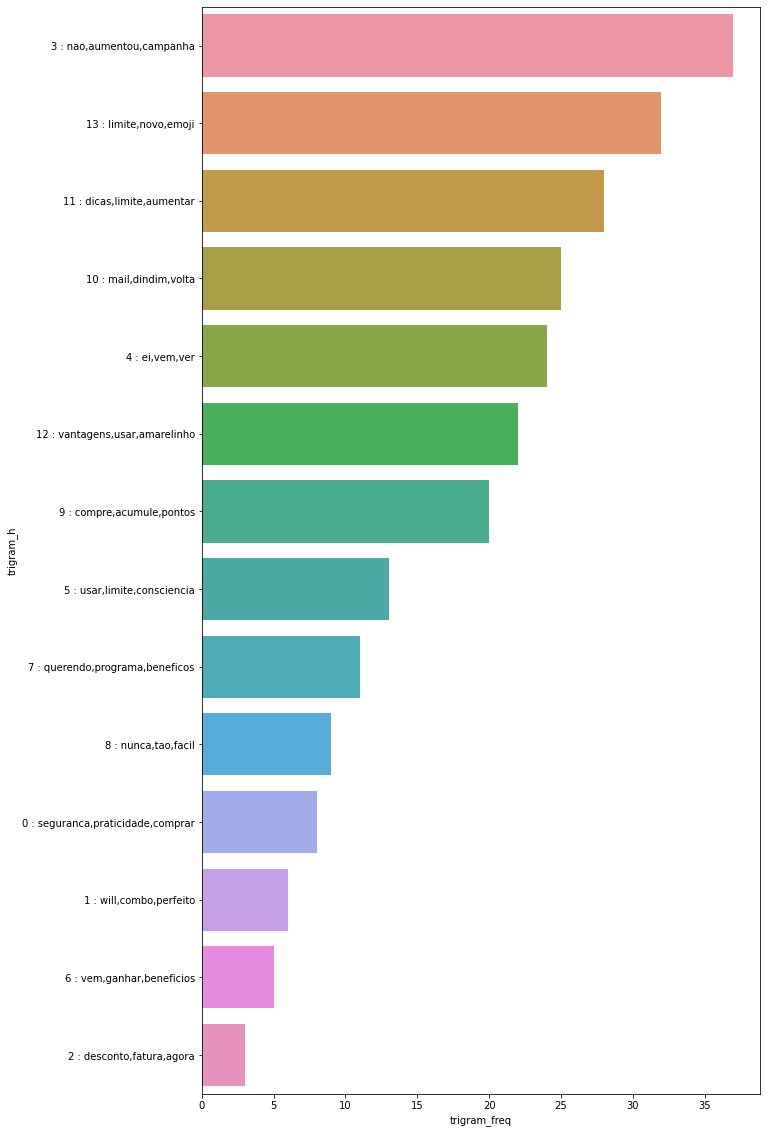

In [143]:
df_resumo = ranking_cluster(df_clean, 'cluster_dbscan_tsne', 'ds_message_tratada', 'dt_envio')
df_resumo['unigram_freq'] = df_resumo['unigram_freq'].astype('int')
df_resumo['bigram_freq'] = df_resumo['bigram_freq'].astype('int')
df_resumo['trigram_freq'] = df_resumo['trigram_freq'].astype('int')
df_resumo['cluster'] = df_resumo['cluster'].astype('str')

df_resumo['unigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['unigram']
df_resumo['bigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['bigram']
df_resumo['trigram_h'] = df_resumo['cluster'] + ' : ' + df_resumo['trigram']

plt.figure(figsize=(10,20))
sns.barplot(data = df_resumo.sort_values(by ='trigram_freq', ascending=False), x = 'trigram_freq', y = 'trigram_h')
plt.show()

## Criando sazonais

In [144]:
df_clean['dt_envio'] = pd.to_datetime(df_clean['dt_envio'])
df_clean['ano'] = df_clean['dt_envio'].map(lambda x: x.strftime('%Y'))
df_clean['dia'] = df_clean['dt_envio'].map(lambda x: x.strftime('%d'))
df_clean['mes'] = df_clean['dt_envio'].map(lambda x: x.strftime('%m'))
df_clean['dia_semana'] = df_clean['dt_envio'].map(lambda x: x.strftime('%A'))
df_clean['hora'] = df_clean['dt_envio'].map(lambda x: x.strftime('%H'))

#'%Y-%m-%d %H:%M:%S'

## Modelo linear simples para explicar a taxa de abertura e cliques

In [145]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [146]:

formula_text = """
taxa_abertura ~
+ C(ano) +C(dia) + C(hora) +C(mes) +C(dia_semana) +
C(cluster_hero) + C(cluster_dbscan) + C(cluster_dbscan_tsne) +
adjective + 
adposition + 
adverb + 
auxiliary + 
determiner + 
interjection +
noun + 
numeral + other +
pronoun +
punctuation + 
space + 
symbol + 
verb +
C(flag_cobranca) + 
C(flag_emoji) +
C(flag_exclamacao) + 
C(flag_dinheiro) +
C(flag_fatura) +
C(flag_limite) + 
C(flag_cashback) + 
C(flag_nome) +
n_palavras + 
sentiment + 
C(sentimento) 


"""
model = ols(formula = formula_text, data = df_clean).fit()
model.summary()
results_as_html = model.summary().tables[1].as_html()
results = pd.read_html(results_as_html, header=0, index_col=0)[0]
results = results[(results['P>|t|'] <= 0.05)]
results = results.reset_index()
results = results[~results['index'].str.contains("dia")]
print(results)

                           index    coef  std err      t  P>|t|  [0.025  \
0                      Intercept  0.2450    0.101  2.415  0.016   0.046   
2                   C(mes)[T.05] -0.0687    0.032 -2.177  0.030  -0.131   
3                   C(mes)[T.06] -0.0653    0.032 -2.031  0.043  -0.128   
4                   C(mes)[T.10]  0.1600    0.059  2.730  0.007   0.045   
5                   C(mes)[T.11]  0.0722    0.036  2.003  0.046   0.001   
6           C(cluster_hero)[T.4]  0.1452    0.063  2.311  0.021   0.022   
7          C(cluster_hero)[T.14]  0.1438    0.071  2.015  0.044   0.004   
8         C(cluster_dbscan)[T.3]  0.2250    0.058  3.863  0.000   0.111   
9         C(cluster_dbscan)[T.6]  0.2284    0.103  2.218  0.027   0.026   
10        C(cluster_dbscan)[T.8]  0.1452    0.063  2.311  0.021   0.022   
11       C(cluster_dbscan)[T.12]  0.2327    0.058  3.986  0.000   0.118   
12       C(cluster_dbscan)[T.13] -0.1367    0.067 -2.028  0.043  -0.269   
13   C(cluster_dbscan_tsn

In [147]:
formula_text = """
taxa_abertura ~
+ C(ano) +C(dia) + C(hora) +C(mes) +C(dia_semana) +
C(flag_cobranca) + 
C(flag_emoji) +
C(flag_exclamacao) + 
C(flag_dinheiro) +
C(flag_fatura) +
C(flag_limite) + 
C(flag_cashback) + 
C(flag_nome) +
n_palavras + 
sentiment +
adjective + 
adposition + 
adverb + 
auxiliary + 
determiner + 
interjection +
noun + 
numeral + other +
pronoun +
punctuation + 
space + 
symbol + 
verb + 
C(sentimento) 


"""
model = ols(formula = formula_text, data = df_clean).fit()
model.summary()
results_as_html = model.summary().tables[1].as_html()
results = pd.read_html(results_as_html, header=0, index_col=0)[0]
results = results[(results['P>|t|'] <= 0.05)]
results = results.reset_index()
results = results[~results['index'].str.contains("dia")]
print(results)

                      index    coef  std err      t  P>|t|  [0.025  0.975]
0                 Intercept  0.1878    0.086  2.191  0.029   0.019   0.356
4              C(mes)[T.12]  0.0625    0.029  2.128  0.034   0.005   0.120
6       C(flag_fatura)[T.1]  0.0675    0.021  3.221  0.001   0.026   0.109
7       C(flag_limite)[T.1]  0.0828    0.012  6.665  0.000   0.058   0.107
8   C(sentimento)[T.neutro]  0.0506    0.020  2.496  0.013   0.011   0.091
9     C(sentimento)[T.ruim]  0.0881    0.032  2.726  0.007   0.025   0.152
10               n_palavras -0.0067    0.003 -2.240  0.025  -0.013  -0.001
11                adjective  0.0030    0.001  3.659  0.000   0.001   0.005
12                  pronoun -0.0043    0.002 -2.055  0.040  -0.008  -0.000
13              punctuation  0.0902    0.029  3.127  0.002   0.034   0.147


In [148]:
formula_text = """
taxa_abertura ~
+ C(ano) +C(dia) + C(hora) +C(mes) +C(dia_semana) +
C(cluster_hero) +
C(flag_cobranca) + 
C(flag_emoji) +
C(flag_exclamacao) + 
C(flag_dinheiro) +
C(flag_fatura) +
C(flag_limite) + 
C(flag_cashback) + 
C(flag_nome) +
n_palavras + 
sentiment +
adjective + 
adposition + 
adverb + 
auxiliary + 
determiner + 
interjection +
noun + 
numeral + other +
pronoun +
punctuation + 
space + 
symbol + 
verb +  
C(sentimento) 


"""
model = ols(formula = formula_text, data = df_clean).fit()
model.summary()
results_as_html = model.summary().tables[1].as_html()
results = pd.read_html(results_as_html, header=0, index_col=0)[0]
results = results[(results['P>|t|'] <= 0.05)]
results = results.reset_index()
results = results[~results['index'].str.contains("dia")]
print(results)

                    index    coef  std err      t  P>|t|    [0.025  0.975]
2            C(mes)[T.05] -0.0631    0.031 -2.027  0.043 -0.124000  -0.002
3            C(mes)[T.06] -0.0641    0.032 -2.003  0.046 -0.127000  -0.001
4            C(mes)[T.12]  0.0610    0.029  2.118  0.035  0.004000   0.118
6    C(cluster_hero)[T.2]  0.1184    0.039  3.029  0.003  0.042000   0.195
7    C(cluster_hero)[T.3]  0.2664    0.066  4.027  0.000  0.136000   0.396
8    C(cluster_hero)[T.4]  0.2864    0.072  3.961  0.000  0.144000   0.428
9    C(cluster_hero)[T.5]  0.2186    0.074  2.959  0.003  0.073000   0.364
10   C(cluster_hero)[T.6]  0.1013    0.032  3.175  0.002  0.039000   0.164
11   C(cluster_hero)[T.7]  0.0823    0.042  1.965  0.050  0.000029   0.165
12   C(cluster_hero)[T.8]  0.1422    0.044  3.218  0.001  0.055000   0.229
13   C(cluster_hero)[T.9]  0.1232    0.033  3.720  0.000  0.058000   0.188
14  C(cluster_hero)[T.10]  0.0932    0.028  3.343  0.001  0.038000   0.148
15  C(cluster_hero)[T.11]

In [150]:
formula_text = """
taxa_abertura ~
+ C(ano) +C(dia) + C(hora) +C(mes) +C(dia_semana) +
C(cluster_dbscan) +
C(flag_cobranca) + 
C(flag_emoji) +
C(flag_exclamacao) + 
C(flag_dinheiro) +
C(flag_fatura) +
C(flag_limite) + 
C(flag_cashback) + 
C(flag_nome) +
n_palavras + 
sentiment +
adjective + 
adposition + 
adverb + 
auxiliary + 
determiner + 
interjection +
noun + 
numeral + other +
pronoun +
punctuation + 
space + 
symbol + 
verb +  
C(fx_sentimento) 


"""
model = ols(formula = formula_text, data = df_clean).fit()
model.summary()
results_as_html = model.summary().tables[1].as_html()
results = pd.read_html(results_as_html, header=0, index_col=0)[0]
results = results[(results['P>|t|'] <= 0.05)]
results = results.reset_index()
results = results[~results['index'].str.contains("dia")]
print(results)

                      index    coef  std err      t  P>|t|  [0.025  0.975]
0                 Intercept  0.3198    0.082  3.879  0.000   0.158   0.482
1              C(mes)[T.10]  0.2677    0.056  4.761  0.000   0.157   0.378
2              C(mes)[T.11]  0.0973    0.036  2.716  0.007   0.027   0.168
3    C(cluster_dbscan)[T.3]  0.1469    0.043  3.394  0.001   0.062   0.232
4    C(cluster_dbscan)[T.7]  0.1452    0.048  3.037  0.003   0.051   0.239
5    C(cluster_dbscan)[T.8]  0.2295    0.107  2.146  0.032   0.019   0.440
6   C(cluster_dbscan)[T.12]  0.3626    0.045  8.022  0.000   0.274   0.451
7   C(cluster_dbscan)[T.14] -0.2793    0.057 -4.919  0.000  -0.391  -0.168
8       C(flag_fatura)[T.1]  0.0619    0.019  3.231  0.001   0.024   0.100
9       C(flag_limite)[T.1]  0.0572    0.028  2.076  0.038   0.003   0.111
10               n_palavras -0.0095    0.003 -3.084  0.002  -0.016  -0.003
11                   adverb  0.0164    0.005  3.009  0.003   0.006   0.027
12                auxilia

In [151]:
formula_text = """
taxa_abertura ~
+ C(ano) +C(dia) + C(hora) +C(mes) + C(dia_semana) +
C(cluster_dbscan_tsne) +
C(flag_cobranca) + 
C(flag_emoji) +
C(flag_exclamacao) + 
C(flag_dinheiro) +
C(flag_fatura) +
C(flag_limite) + 
C(flag_cashback) + 
C(flag_nome) +
n_palavras + 
sentiment +
adjective + 
adposition + 
adverb + 
auxiliary + 
determiner + 
interjection +
noun + 
numeral + other +
pronoun +
punctuation + 
space + 
symbol + 
verb +  
C(fx_sentimento) 

"""
model = ols(formula = formula_text, data = df_clean).fit()
model.summary()
results_as_html = model.summary().tables[1].as_html()
results = pd.read_html(results_as_html, header=0, index_col=0)[0]
results = results[(results['P>|t|'] <= 0.05)]
results = results.reset_index()
results = results[~results['index'].str.contains("dia")]
print(results)

                           index    coef  std err      t  P>|t|  [0.025  \
0                      Intercept  0.2464    0.084  2.933  0.003   0.081   
3                   C(mes)[T.12]  0.0880    0.028  3.182  0.002   0.034   
5    C(cluster_dbscan_tsne)[T.1] -0.1860    0.033 -5.655  0.000  -0.251   
6    C(cluster_dbscan_tsne)[T.3] -0.2241    0.049 -4.563  0.000  -0.321   
7    C(cluster_dbscan_tsne)[T.5] -0.1116    0.041 -2.722  0.007  -0.192   
8    C(cluster_dbscan_tsne)[T.8] -0.0451    0.019 -2.344  0.019  -0.083   
9   C(cluster_dbscan_tsne)[T.10]  0.1422    0.061  2.337  0.020   0.023   
10       C(flag_exclamacao)[T.1]  0.0214    0.010  2.158  0.031   0.002   
11           C(flag_fatura)[T.1]  0.0477    0.021  2.242  0.025   0.006   
12           C(flag_limite)[T.1]  0.1867    0.028  6.717  0.000   0.132   
13                     adjective  0.0030    0.001  2.226  0.026   0.000   
14                        adverb  0.0152    0.003  4.538  0.000   0.009   
15                     au

In [152]:
formula_text = """
taxa_clique ~
+ C(ano) +C(dia) + C(hora) +C(mes) +C(dia_semana) +
C(flag_cobranca) + 
C(flag_emoji) +
C(flag_exclamacao) + 
C(flag_dinheiro) +
C(flag_fatura) +
C(flag_limite) + 
C(flag_cashback) + 
C(flag_nome) +
n_palavras + 
C(fx_sentimento)


"""
model = ols(formula = formula_text, data = df_clean).fit()
model.summary()
results_as_html = model.summary().tables[1].as_html()
results = pd.read_html(results_as_html, header=0, index_col=0)[0]
results = results[(results['P>|t|'] <= 0.05)]
results = results.reset_index()
results = results[~results['index'].str.contains("dia")]
print(results)

                          index    coef  std err       t  P>|t|  [0.025  \
2            C(flag_emoji)[T.1]  0.0982    0.015   6.761  0.000   0.070   
3           C(flag_fatura)[T.1]  0.0884    0.026   3.458  0.001   0.038   
4           C(flag_limite)[T.1]  0.1213    0.012  10.308  0.000   0.098   
5         C(flag_cashback)[T.1] -0.0701    0.026  -2.656  0.008  -0.122   
6    C(fx_sentimento)[T.neutro]  0.1286    0.024   5.360  0.000   0.081   
7  C(fx_sentimento)[T.positivo]  0.0881    0.025   3.454  0.001   0.038   
8                    n_palavras -0.0099    0.003  -3.229  0.001  -0.016   

   0.975]  
2   0.127  
3   0.139  
4   0.144  
5  -0.018  
6   0.176  
7   0.138  
8  -0.004  


In [435]:
df_clean.to_csv('base_modelo')

In [436]:
df_clean.columns

Index(['ds_message_tratada', 'activityname', 'journeyname', 'tema', 'subject',
       'ferramenta', 'clientes', 'cliques', 'aberturas', 'dt_envio',
       'taxa_abertura', 'taxa_clique', 'flag_cobranca', 'flag_emoji',
       'flag_exclamacao', 'flag_dinheiro', 'flag_fatura', 'flag_limite',
       'flag_cashback', 'flag_nome', 'n_palavras', 'sentiment', 'sentimento',
       'sentiment_2', 'classe', 'adjective', 'adposition', 'adverb',
       'auxiliary', 'coordinating conjunction', 'determiner', 'interjection',
       'noun', 'numeral', 'other', 'pronoun', 'proper noun', 'punctuation',
       'space', 'subordinating conjunction', 'symbol', 'verb', 'pca', 'pca_1',
       'pca_2', 'cluster_hero', 'cluster_dbscan', 'pca_1_tsne', 'pca_2_tsne',
       'cluster_dbscan_tsne', 'ano', 'dia', 'mes', 'dia_semana', 'hora'],
      dtype='object')

In [437]:
#df_clean['cluster_hero'] = df_clean['cluster_hero'].astype("string")
#df_clean['cluster_dbscan'] = df_clean['cluster_dbscan'].astype("string")
#df_clean['cluster_dbscan_tsne'] = df_clean['cluster_dbscan_tsne'].astype("string")


In [245]:
ajustes_categoricas = ['sentimento', 'sentiment_2', 'cluster_hero', 'cluster_dbscan', 'cluster_dbscan_tsne', 'ano', 'dia', 'mes', 'dia_semana',
                       'hora', 'fx_sentimento', 'cluster']
""" 

for i in ajustes_categoricas:
    df_clean[i] = df_clean[i].astype("category") """


' \n\nfor i in ajustes_categoricas:\n    df_clean[i] = df_clean[i].astype("category") '

In [154]:
ajustes_categoricas

['sentimento',
 'sentiment_2',
 'cluster_hero',
 'cluster_dbscan',
 'cluster_dbscan_tsne',
 'ano',
 'dia',
 'mes',
 'dia_semana',
 'hora',
 'fx_sentimento']

In [550]:
print(df_clean.columns)

Index(['ds_message_tratada', 'activityname', 'journeyname', 'tema', 'subject',
       'ferramenta', 'clientes', 'cliques', 'aberturas', 'dt_envio',
       'taxa_abertura', 'taxa_clique', 'flag_cobranca', 'flag_emoji',
       'flag_exclamacao', 'flag_dinheiro', 'flag_fatura', 'flag_limite',
       'flag_cashback', 'flag_nome', 'n_palavras', 'sentiment', 'sentimento',
       'sentiment_2', 'classe', 'adjective', 'adposition', 'adverb',
       'auxiliary', 'coordinating conjunction', 'determiner', 'interjection',
       'noun', 'numeral', 'other', 'pronoun', 'proper noun', 'punctuation',
       'space', 'subordinating conjunction', 'symbol', 'verb', 'pca', 'pca_1',
       'pca_2', 'cluster_hero', 'cluster_dbscan', 'pca_1_tsne', 'pca_2_tsne',
       'cluster_dbscan_tsne', 'ano', 'dia', 'mes', 'dia_semana', 'hora',
       'cont', 'fx_clique', 'fx_hora', 'fx_palavras', 'c_flag_cobranca',
       'c_flag_emoji', 'c_flag_exclamacao', 'c_flag_dinheiro', 'c_flag_fatura',
       'c_flag_limite', '

In [155]:
df_clean['taxa_abertura'].describe()

count    654.000000
mean       0.257426
std        0.114001
min        0.062800
25%        0.192839
50%        0.221088
75%        0.290316
max        0.965517
Name: taxa_abertura, dtype: float64

## Teste com XGBOOST

In [442]:
#df_clean = df_clean.query('taxa_abertura <= 0.6')
#tirando outliers

In [246]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

regressor=xgb.XGBRegressor(eval_metric='rmsle')

df_model = pd.get_dummies(df_clean, columns=ajustes_categoricas)
df_model = df_model[df_model['taxa_abertura'].isna() == False]
df_model = df_model[df_model['taxa_abertura'] > 0]
df_model = df_model[df_model['taxa_abertura'] < 1]


preditoras = df_model.columns.drop(['ds_message_tratada', 'activityname', 'journeyname', 'tema', 'subject',
       'ferramenta', 'clientes', 'cliques', 'aberturas', 'dt_envio', 'classe',
       'taxa_abertura', 'taxa_clique', 'pca', 'pca_1','pca_1_tsne', 'pca_2_tsne',
       'pca_2'])

x_train, x_test, y_train, y_test = train_test_split(df_model[preditoras], df_model['taxa_abertura'], random_state=42, test_size = 0.2)

In [247]:
from sklearn.model_selection import GridSearchCV

# set up our search grid
param_grid = {
              "alpha":    [1, 0.016],
              "max_depth":    [4, 7, 10],
              "lambda":    [1.18, 2],
              "gamma":    [0],
              "num_round":    [449],
              "colsample_bytree": [0.98],
              "subsample": [0.99, 0.7],
              "min_child_weight": [0.14],
              "learning_rate": [0.01, 0.015, 0.05, 0.07]
              }

# try out every combination of the above values

#Xy = xgb.DMatrix(x_train, y_train, enable_categorical=True)

search = GridSearchCV(regressor, param_grid, cv=5).fit(x_train, y_train)

print("The best hyperparameters are ",search.best_params_)



[16:56:44] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[16:56:44] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[16:56:44] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[16:56:45] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[16:56:45] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[16:56:45] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[16:56:46] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[16:56:46] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[16:56:46] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[16:56:46] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[16:56:46] WARNING: ../src/learner.cc:767: 
Parameters: { "num_round" } are not used.

[16:56:47] WARNING: ../src/learner.cc:767: 

In [248]:
regressor=xgb.XGBRegressor(  
    learning_rate = search.best_params_["learning_rate"],
                            colsample_bytree = search.best_params_["colsample_bytree"] ,
                            subsample = search.best_params_["subsample"],
                            min_child_weight = search.best_params_["min_child_weight"],
                            num_round = search.best_params_["num_round"],
                           lambda_  = search.best_params_["lambda"],
                           gamma  = search.best_params_["gamma"],
                           alpha  = search.best_params_["alpha"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmse')

regressor.fit(x_train, y_train)

[16:58:59] WARNING: ../src/learner.cc:767: 
Parameters: { "lambda_", "num_round" } are not used.



XGBRegressor(alpha=0.016, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.98, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda_=2, learning_rate=0.07,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=0.14, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
""" for i in df_model.columns:
    print(i)
    print(df_model[i].isna().sum()) """

ds_message_tratada
0
activityname
10
journeyname
10
tema
10
subject
0
ferramenta
0
clientes
0
cliques
115
aberturas
0
dt_envio
0
taxa_abertura
0
taxa_clique
115
flag_cobranca
0
flag_emoji
0
flag_exclamacao
0
flag_dinheiro
0
flag_fatura
0
flag_limite
0
flag_cashback
0
flag_nome
0
n_palavras
0
sentiment
0
sentimento
0
sentiment_2
0
classe
0
adjective
0
adposition
0
adverb
0
auxiliary
0
coordinating conjunction
0
determiner
0
interjection
0
noun
0
numeral
0
other
0
pronoun
0
proper noun
0
punctuation
0
space
0
subordinating conjunction
0
symbol
0
verb
0
pca
0
pca_1
0
pca_2
0
cluster_hero
0
cluster_dbscan
0
pca_1_tsne
0
pca_2_tsne
0
cluster_dbscan_tsne
0
ano
0
dia
0
mes
0
dia_semana
0
hora
0


In [249]:
predictions = regressor.predict(x_test)

In [250]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

print(mean_absolute_percentage_error(y_test, predictions) )
print(r2_score(y_test, predictions) )

0.19813577700074075
0.5788441926855963


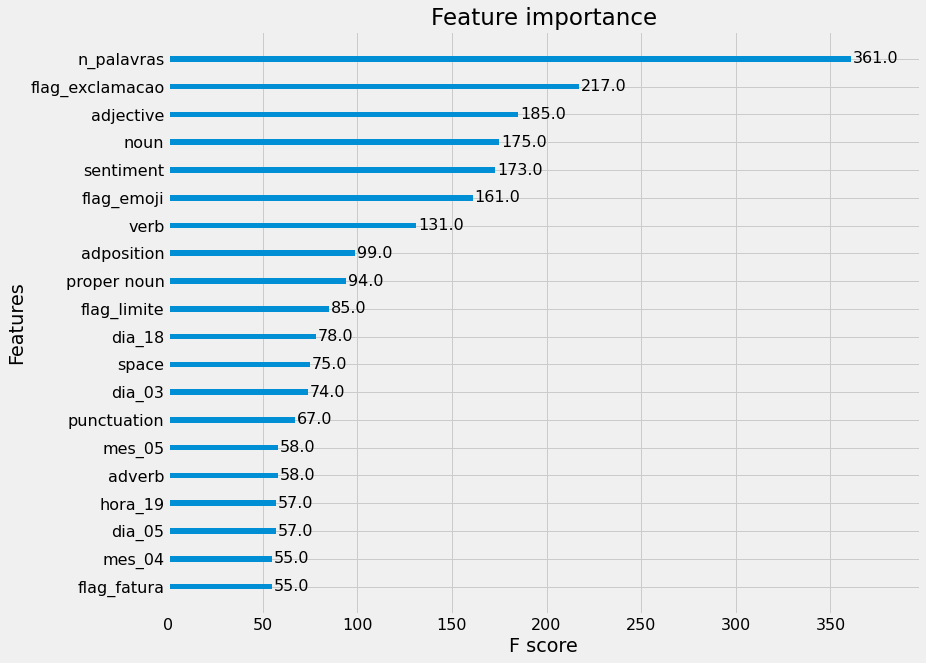

In [251]:
from xgboost import plot_importance

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,10))
plot_importance(regressor, max_num_features=20, ax=ax)
plt.show();

Permutation explainer: 132it [00:10,  2.06s/it]                         


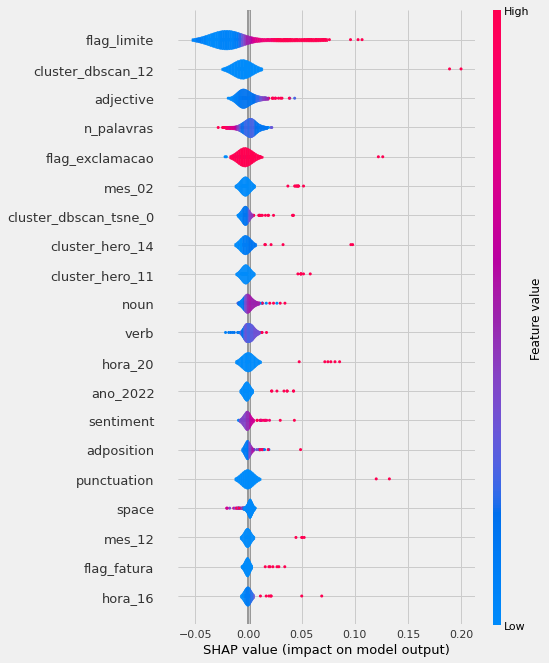

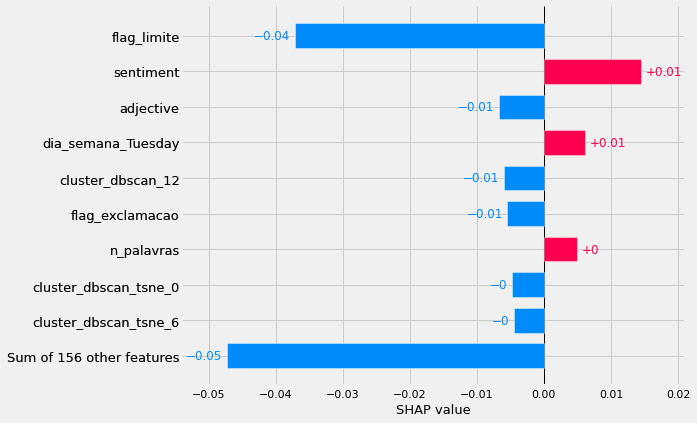

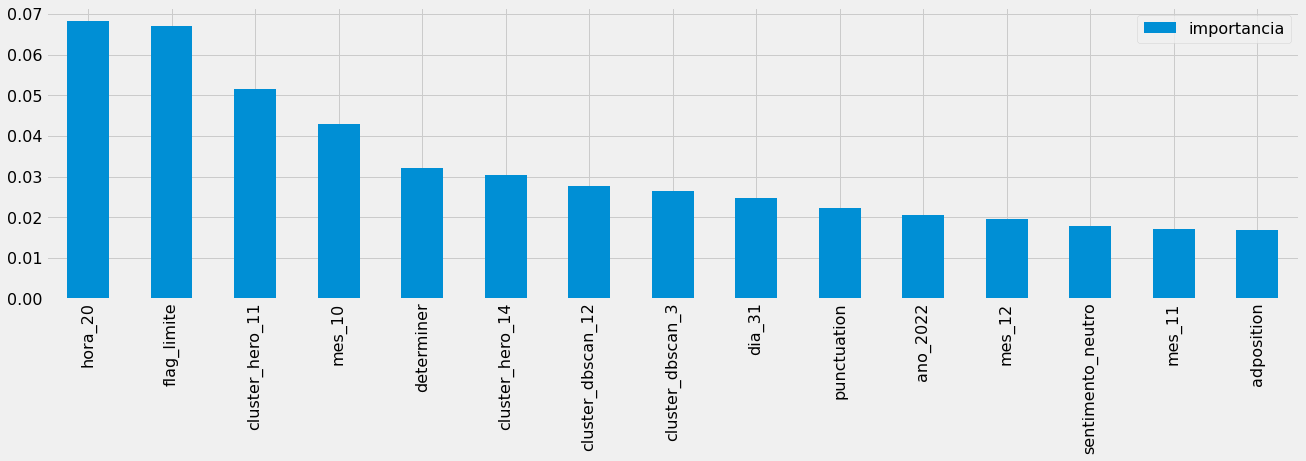

In [252]:

import shap

explainer = shap.Explainer(regressor.predict, x_test)
shap_values = explainer(x_test)
shap.summary_plot(shap_values, plot_type='violin')
shap.plots.bar(shap_values[0])
importance_df = pd.DataFrame(regressor.feature_importances_, columns = ['importancia'], index = preditoras)
importance_df.sort_values(by='importancia', ascending=False).head(15).plot.bar(figsize=(20,5))
features_importantes = importance_df.sort_values(by='importancia', ascending=False).head(10).index



## Função de combinações

In [253]:
#separar por percentis e analisar combinações de hora / dia semana

import funcionalidade as fc

df_comb = df_clean
df_comb['cont'] = 1

In [254]:
## REFAZER FAIXAS DE CLIQUE MANUALMENTE

df_comb['fx_clique'] = np.where(df_comb['taxa_abertura'] <= 0.2, 'baixo',
                        np.where(df_comb['taxa_abertura'] <= 0.25, 'médio-baixo',
                        np.where(df_comb['taxa_abertura'] <= 0.30, 'médio-alto', 'alto')))

#df_comb['fx_clique'] = pd.qcut(df_comb['taxa_abertura'].rank(method='first'), q=4, precision=0, labels = ['baixo', 'medio-baixo', 'medio-alto', 'alto'])
#df_comb['fx_clique'] = df_comb['fx_clique'].astype('string')
df_comb['fx_clique'].value_counts()

médio-baixo    232
baixo          203
alto           153
médio-alto      66
Name: fx_clique, dtype: int64

In [255]:
df_comb['hora'] = df_comb['hora'].astype("int")

In [256]:
df_comb['fx_hora'] = np.where( df_comb.hora <= 11, 1,
                              np.where( df_comb.hora <= 14, 2,
                                       np.where( df_comb.hora <= 16, 3,
                                                np.where( df_comb.hora <= 19, 4,
                                                np.where( df_comb.hora <= 21, 5, 6)))))
df_comb['fx_hora'].value_counts()

4    370
2    140
1     82
3     40
5     17
6      5
Name: fx_hora, dtype: int64

In [257]:
colunas_analise = ['fx_sentimento', 'dia_semana', 'fx_hora']
report_combinacoes = fc.report_perfil_grupos(df_comb, 'fx_clique', 'cont', 0.05, 50, colunas_analise)
report_combinacoes.query('diferenca > 0').head(20)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,segmento,n_seg_grupo,n_seg,n_grupo,total,per_grupo_seg,per_grupo_total,diferenca,diferenca_abs,fx_clique
4,- 2,52,140,153,654,0.371429,0.233945,0.137484,0.137484,alto
4,- neutro,105,347,153,654,0.302594,0.233945,0.068649,0.068649,alto
9,- positivo,93,253,203,654,0.367589,0.310398,0.057191,0.057191,baixo


In [258]:
#faixa de nr de palavras
df_comb['fx_palavras'] = np.where( df_comb.n_palavras <= 3, 1,
                              np.where( df_comb.n_palavras <= 5, 2,
                                       np.where( df_comb.n_palavras <= 7, 3,
                                                np.where( df_comb.n_palavras <= 10, 4,
                                                np.where( df_comb.n_palavras <= 20, 5, 6)))))

df_comb['fx_palavras'] = df_comb['fx_palavras'].astype("string")
df_comb['fx_palavras'] = df_comb['fx_palavras'] + '-nivel_palavras'
df_comb['fx_palavras'].value_counts()

2-nivel_palavras    242
1-nivel_palavras    233
3-nivel_palavras    108
4-nivel_palavras     71
Name: fx_palavras, dtype: Int64

In [259]:
#transformando flags em strings
flags = ['flag_cobranca', 'flag_emoji', 'flag_exclamacao', 'flag_dinheiro', 'flag_fatura', 'flag_limite', 'flag_cashback', 'flag_nome']

for i in flags:
    df_comb["c_" + i] = np.where(df_comb[i] == 1, i + '-SIM', i + '-NÃO')



In [260]:
#noun, proper noun e punctuation

df_comb['fx_noun'] = pd.qcut(df_comb['noun'].rank(method='first'), q=2, precision=0, labels = ['baixo', 'alto'])
df_comb['fx_noun'] = df_comb['fx_noun'].astype('string')
df_comb['fx_noun'].value_counts()


baixo    327
alto     327
Name: fx_noun, dtype: Int64

In [261]:
df_comb['fx_proper noun'] = pd.qcut(df_comb['proper noun'].rank(method='first'), q=2, precision=0, labels = ['baixo', 'alto'])
df_comb['fx_proper noun'] = df_comb['fx_proper noun'].astype('string')
df_comb['fx_proper noun'].value_counts()

alto     327
baixo    327
Name: fx_proper noun, dtype: Int64

In [262]:
df_comb['fx_punctuation'] = pd.qcut(df_comb['punctuation'].rank(method='first'), q=2, precision=0, labels = ['baixo', 'alto'])
df_comb['fx_punctuation'] = df_comb['fx_punctuation'].astype('string')
df_comb['fx_punctuation'].value_counts()

baixo    327
alto     327
Name: fx_punctuation, dtype: Int64

In [263]:
#Ajuste faixas 
vars_sintaxe = ['fx_noun', 'fx_proper noun', 'fx_punctuation']

for i in vars_sintaxe:
    df_comb[i] = i + '-' + df_comb[i] 

In [264]:
colunas_analise = ['fx_sentimento', 'dia_semana','fx_palavras', 'fx_noun', 'fx_proper noun', 'fx_punctuation' , 'c_flag_cobranca', 'c_flag_emoji', 'c_flag_exclamacao', 'c_flag_dinheiro', 'c_flag_fatura', 'c_flag_limite', 'c_flag_cashback', 'c_flag_nome']
report_combinacoes = fc.report_perfil_grupos(df_comb, 'fx_clique', 'cont', 0.05, 50, colunas_analise)
report_combinacoes.set_index('segmento', inplace=True)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [265]:
report_combinacoes.query('diferenca > 0') \
.query('fx_clique == "alto"') \
.head(50)

,n_seg_grupo,n_seg,n_grupo,total,per_grupo_seg,per_grupo_total,diferenca,diferenca_abs,fx_clique
segmento,,,,,,,,,
- flag_limite-SIM,102,218,153,654,0.467890,0.233945,0.233945,0.233945,alto
- flag_emoji-SIM,61,164,153,654,0.371951,0.233945,0.138006,0.138006,alto
- neutro,105,347,153,654,0.302594,0.233945,0.068649,0.068649,alto
- 1-nivel_palavras,68,233,153,654,0.291845,0.233945,0.057901,0.057901,alto


In [267]:
report_combinacoes.query('diferenca > 0') \
.query('fx_clique == "médio-alto"') \
.head(50)

,n_seg_grupo,n_seg,n_grupo,total,per_grupo_seg,per_grupo_total,diferenca,diferenca_abs,fx_clique
segmento,,,,,,,,,


In [272]:
report_combinacoes.query('diferenca > 0') \
.query('fx_clique == "baixo"') \
.head(50)

,n_seg_grupo,n_seg,n_grupo,total,per_grupo_seg,per_grupo_total,diferenca,diferenca_abs,fx_clique
segmento,,,,,,,,,
- flag_limite-NÃO,179,436,203,654,0.410550,0.310398,0.100153,0.100153,baixo
- positivo,93,253,203,654,0.367589,0.310398,0.057191,0.057191,baixo


In [278]:
nome_clusters = ['cluster_dbscan', 'cluster_hero','cluster_dbscan_tsne']

In [289]:
for i in nome_clusters:
    df_comb["c_" + i] = df_comb[i].astype('string') + '-' + i 

colunas_analise = ['c_cluster_dbscan', 'c_cluster_hero','c_cluster_dbscan_tsne']

report_combinacoes = fc.report_perfil_grupos(df_comb, 'fx_clique', 'cont', 0.05, 10, colunas_analise)
report_combinacoes.set_index('segmento', inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [290]:
report_combinacoes.head(50)

,n_seg_grupo,n_seg,n_grupo,total,per_grupo_seg,per_grupo_total,diferenca,diferenca_abs,fx_clique
segmento,,,,,,,,,
- 2-cluster_dbscan 11-cluster_hero,18,18,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 2-cluster_dbscan 11-cluster_hero 4-cluster_dbscan_tsne,18,18,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 11-cluster_hero,24,24,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 2-cluster_dbscan,18,18,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 4-cluster_dbscan_tsne,24,24,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 17-cluster_dbscan 5-cluster_hero,28,32,153,654,0.875000,0.233945,0.641055,0.641055,alto
- 17-cluster_dbscan 5-cluster_hero 13-cluster_dbscan_tsne,28,32,153,654,0.875000,0.233945,0.641055,0.641055,alto
- 17-cluster_dbscan,28,32,153,654,0.875000,0.233945,0.641055,0.641055,alto
- 5-cluster_hero,28,32,153,654,0.875000,0.233945,0.641055,0.641055,alto


In [291]:
report_combinacoes.query('diferenca > 0') \
.query('fx_clique == "alto"') \
.head(50)

,n_seg_grupo,n_seg,n_grupo,total,per_grupo_seg,per_grupo_total,diferenca,diferenca_abs,fx_clique
segmento,,,,,,,,,
- 2-cluster_dbscan 11-cluster_hero,18,18,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 2-cluster_dbscan 11-cluster_hero 4-cluster_dbscan_tsne,18,18,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 11-cluster_hero,24,24,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 2-cluster_dbscan,18,18,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 4-cluster_dbscan_tsne,24,24,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 17-cluster_dbscan 5-cluster_hero,28,32,153,654,0.875000,0.233945,0.641055,0.641055,alto
- 17-cluster_dbscan 5-cluster_hero 13-cluster_dbscan_tsne,28,32,153,654,0.875000,0.233945,0.641055,0.641055,alto
- 17-cluster_dbscan,28,32,153,654,0.875000,0.233945,0.641055,0.641055,alto
- 5-cluster_hero,28,32,153,654,0.875000,0.233945,0.641055,0.641055,alto


In [282]:
report_combinacoes.query('diferenca > 0') \
.query('fx_clique == "médio-alto"') \
.head(50)

,n_seg_grupo,n_seg,n_grupo,total,per_grupo_seg,per_grupo_total,diferenca,diferenca_abs,fx_clique
segmento,,,,,,,,,


In [292]:
report_combinacoes.query('diferenca > 0') \
.query('fx_clique == "baixo"') \
.head(50)

,n_seg_grupo,n_seg,n_grupo,total,per_grupo_seg,per_grupo_total,diferenca,diferenca_abs,fx_clique
segmento,,,,,,,,,
- 7-cluster_hero,17,23,203,654,0.739130,0.310398,0.428733,0.428733,baixo
- 0-cluster_dbscan 2-cluster_hero 9-cluster_dbscan_tsne,23,39,203,654,0.589744,0.310398,0.279346,0.279346,baixo
- 9-cluster_dbscan_tsne,23,39,203,654,0.589744,0.310398,0.279346,0.279346,baixo
- 0-cluster_dbscan 2-cluster_hero,42,73,203,654,0.575342,0.310398,0.264945,0.264945,baixo
- 2-cluster_hero,42,74,203,654,0.567568,0.310398,0.257170,0.257170,baixo
- 0-cluster_dbscan 2-cluster_hero 7-cluster_dbscan_tsne,19,34,203,654,0.558824,0.310398,0.248426,0.248426,baixo
- 8-cluster_dbscan_tsne,32,58,203,654,0.551724,0.310398,0.241327,0.241327,baixo
- 7-cluster_dbscan_tsne,20,39,203,654,0.512821,0.310398,0.202423,0.202423,baixo
- 4-cluster_dbscan 12-cluster_hero 8-cluster_dbscan_tsne,15,35,203,654,0.428571,0.310398,0.118174,0.118174,baixo


In [297]:
colunas_analise = ['c_cluster_dbscan_tsne', 'c_flag_emoji', 'c_flag_exclamacao', 'c_flag_dinheiro', 'c_flag_fatura', 'c_flag_limite', 'c_flag_cashback']

report_combinacoes = fc.report_perfil_grupos(df_comb, 'fx_clique', 'cont', 0.05, 10, colunas_analise)
report_combinacoes.set_index('segmento', inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [306]:
report_combinacoes.query('diferenca > 0') \
.query('fx_clique == "alto"') \
.head(50)

,n_seg_grupo,n_seg,n_grupo,total,per_grupo_seg,per_grupo_total,diferenca,diferenca_abs,fx_clique
segmento,,,,,,,,,
- 4-cluster_dbscan_tsne flag_emoji-SIM,18,18,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 4-cluster_dbscan_tsne flag_emoji-SIM flag_exclamacao-NÃO flag_dinheiro-NÃO flag_fatura-NÃO,18,18,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 4-cluster_dbscan_tsne flag_emoji-SIM flag_exclamacao-NÃO flag_dinheiro-NÃO flag_fatura-NÃO flag_limite-SIM,18,18,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 4-cluster_dbscan_tsne,24,24,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 4-cluster_dbscan_tsne flag_emoji-SIM flag_exclamacao-NÃO flag_dinheiro-NÃO,18,18,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 4-cluster_dbscan_tsne flag_emoji-SIM flag_exclamacao-NÃO,18,18,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 4-cluster_dbscan_tsne flag_emoji-SIM flag_exclamacao-NÃO flag_dinheiro-NÃO flag_fatura-NÃO flag_limite-SIM flag_cashback-NÃO,18,18,153,654,1.000000,0.233945,0.766055,0.766055,alto
- 13-cluster_dbscan_tsne flag_emoji-SIM flag_exclamacao-NÃO flag_dinheiro-NÃO flag_fatura-NÃO flag_limite-SIM,28,32,153,654,0.875000,0.233945,0.641055,0.641055,alto
- 13-cluster_dbscan_tsne,28,32,153,654,0.875000,0.233945,0.641055,0.641055,alto


In [313]:
report_combinacoes.query('diferenca > 0') \
.query('fx_clique == "médio-alto"') \
.head(50)

,n_seg_grupo,n_seg,n_grupo,total,per_grupo_seg,per_grupo_total,diferenca,diferenca_abs,fx_clique
segmento,,,,,,,,,
- 11-cluster_dbscan_tsne,13,28,66,654,0.464286,0.100917,0.363368,0.363368,médio-alto
- 11-cluster_dbscan_tsne flag_emoji-NÃO,13,28,66,654,0.464286,0.100917,0.363368,0.363368,médio-alto
- flag_limite-SIM,40,218,66,654,0.183486,0.100917,0.082569,0.082569,médio-alto


In [311]:
pd.crosstab(df_clean.flag_limite, df_clean.flag_emoji)

flag_emoji,0,1
flag_limite,,
0,369,67
1,121,97


In [312]:
pd.crosstab(df_clean.flag_limite, df_clean.flag_emoji, normalize  = 'columns')

flag_emoji,0,1
flag_limite,,
0,0.753061,0.408537
1,0.246939,0.591463


## Investigação Vars

In [268]:
df_comb['fx_clique_alto'] = np.where(df_comb['fx_clique'] == "alto", 1, 0)

In [ ]:
df_comb.columns

Index(['ds_message_tratada', 'activityname', 'journeyname', 'tema', 'subject',
       'ferramenta', 'clientes', 'cliques', 'aberturas', 'dt_envio',
       'taxa_abertura', 'taxa_clique', 'flag_cobranca', 'flag_emoji',
       'flag_exclamacao', 'flag_dinheiro', 'flag_fatura', 'flag_limite',
       'flag_cashback', 'flag_nome', 'n_palavras', 'sentiment', 'sentimento',
       'sentiment_2', 'classe', 'adjective', 'adposition', 'adverb',
       'auxiliary', 'coordinating conjunction', 'determiner', 'interjection',
       'noun', 'numeral', 'other', 'pronoun', 'proper noun', 'punctuation',
       'space', 'subordinating conjunction', 'symbol', 'verb', 'pca', 'pca_1',
       'pca_2', 'cluster_hero', 'cluster_dbscan', 'pca_1_tsne', 'pca_2_tsne',
       'cluster_dbscan_tsne', 'ano', 'dia', 'mes', 'dia_semana', 'hora',
       'cont', 'fx_clique', 'fx_hora', 'fx_palavras', 'c_flag_cobranca',
       'c_flag_emoji', 'c_flag_exclamacao', 'c_flag_dinheiro', 'c_flag_fatura',
       'c_flag_limite', '

,fx_clique_alto,cluster,fx_hora,fx_sentimento_negativo,fx_sentimento_neutro,fx_sentimento_positivo,sentimento_bom,sentimento_neutro,sentimento_ruim,c_flag_cobranca_flag_cobranca-NÃO,...,c_flag_dinheiro_flag_dinheiro-NÃO,c_flag_dinheiro_flag_dinheiro-SIM,c_flag_fatura_flag_fatura-NÃO,c_flag_fatura_flag_fatura-SIM,c_flag_limite_flag_limite-NÃO,c_flag_limite_flag_limite-SIM,c_flag_cashback_flag_cashback-NÃO,c_flag_cashback_flag_cashback-SIM,c_flag_nome_flag_nome-NÃO,c_flag_nome_flag_nome-SIM
0,0,1.614770,3.171657,0.085828,0.483034,0.431138,0.063872,0.878244,0.057884,1.0,...,0.99002,0.00998,0.920160,0.079840,0.768463,0.231537,0.952096,0.047904,0.998004,0.001996
1,1,1.679739,3.189542,0.071895,0.686275,0.241830,0.006536,0.928105,0.065359,1.0,...,1.00000,0.00000,0.986928,0.013072,0.333333,0.666667,1.000000,0.000000,1.000000,0.000000


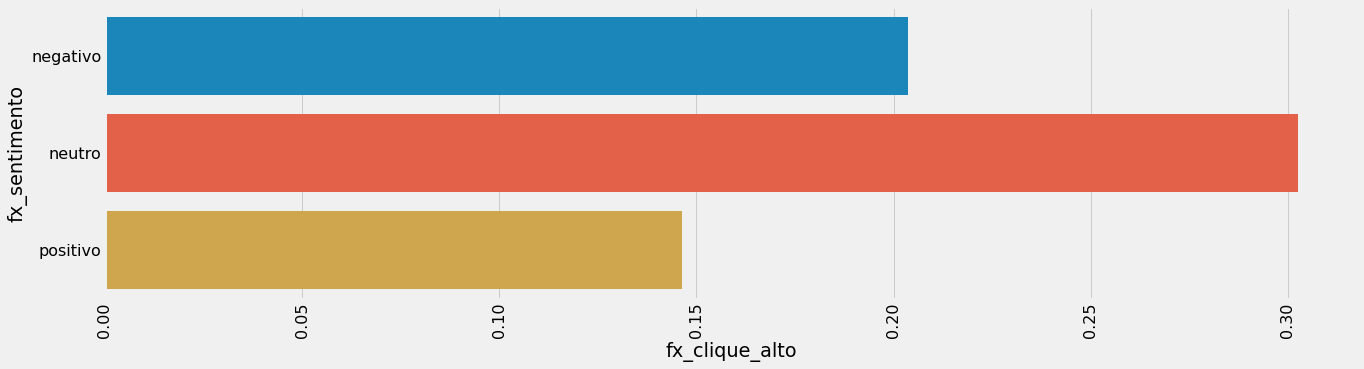

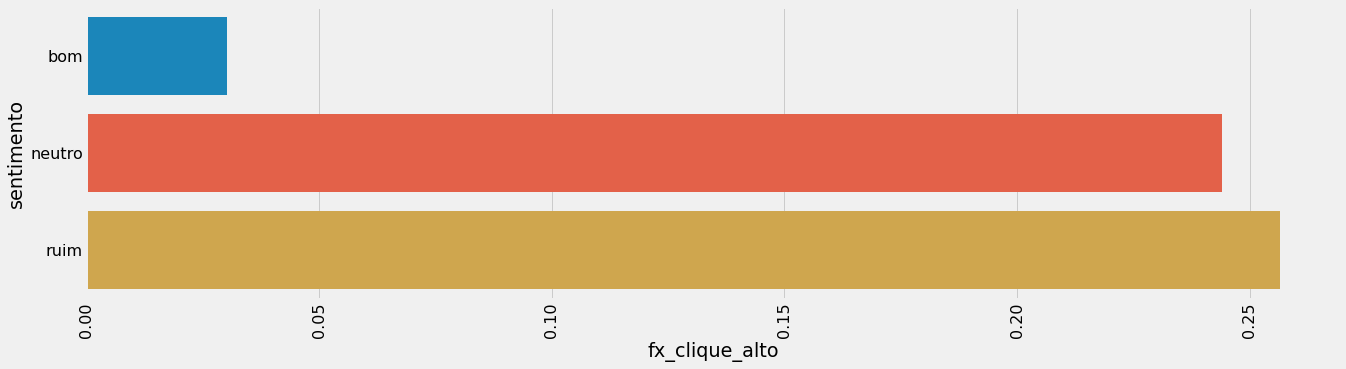

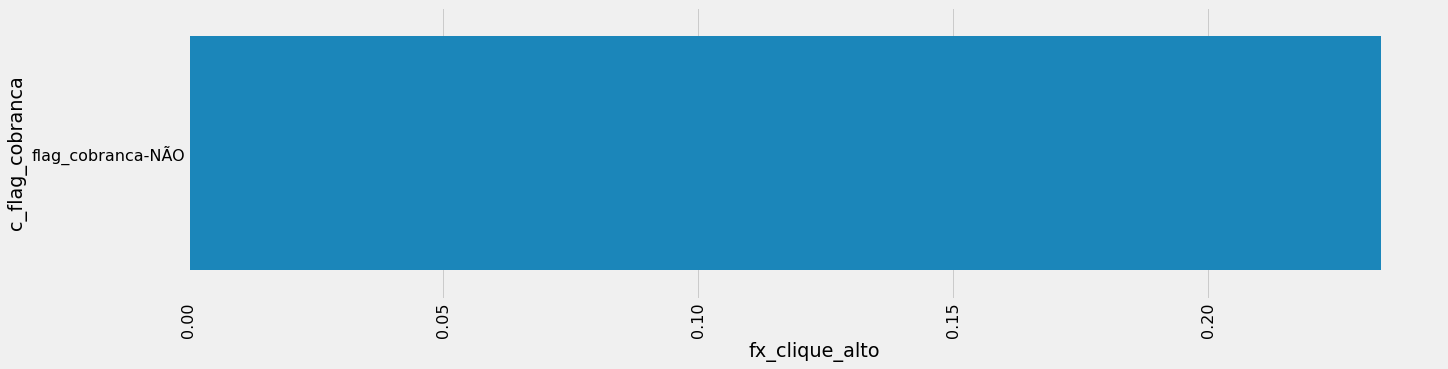

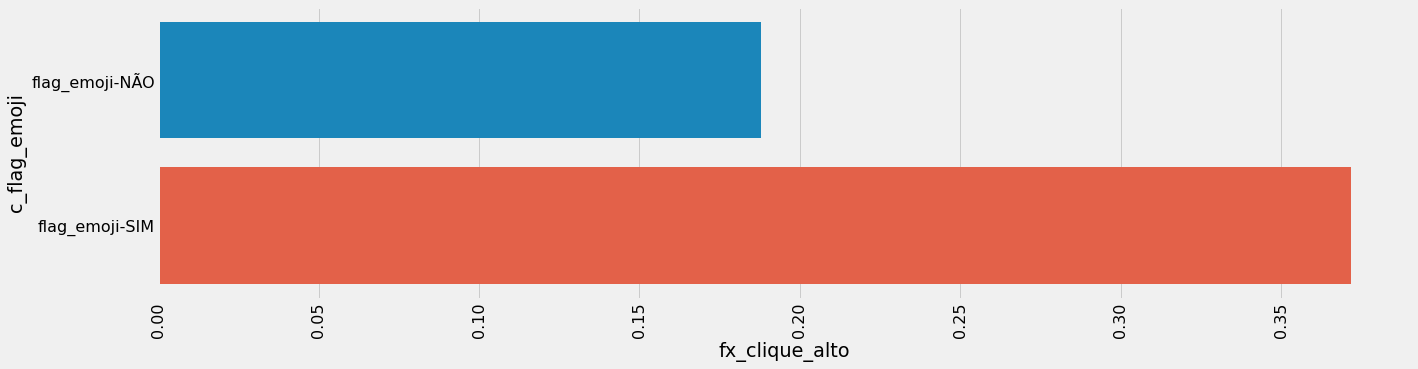

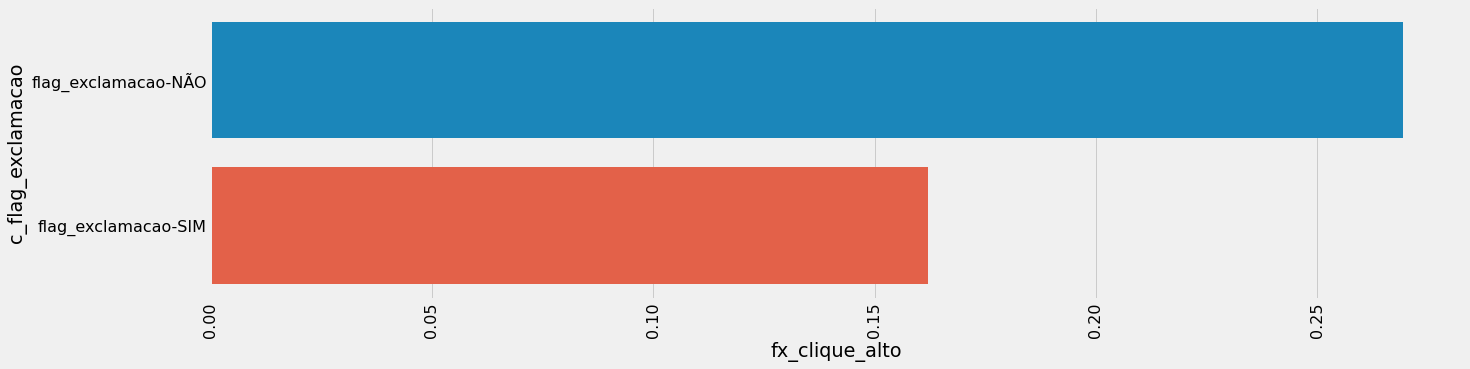

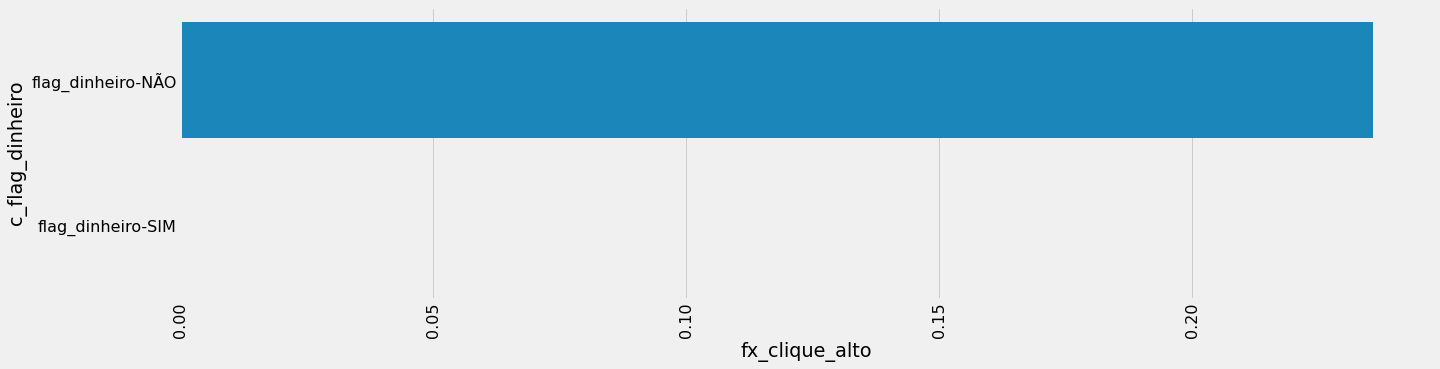

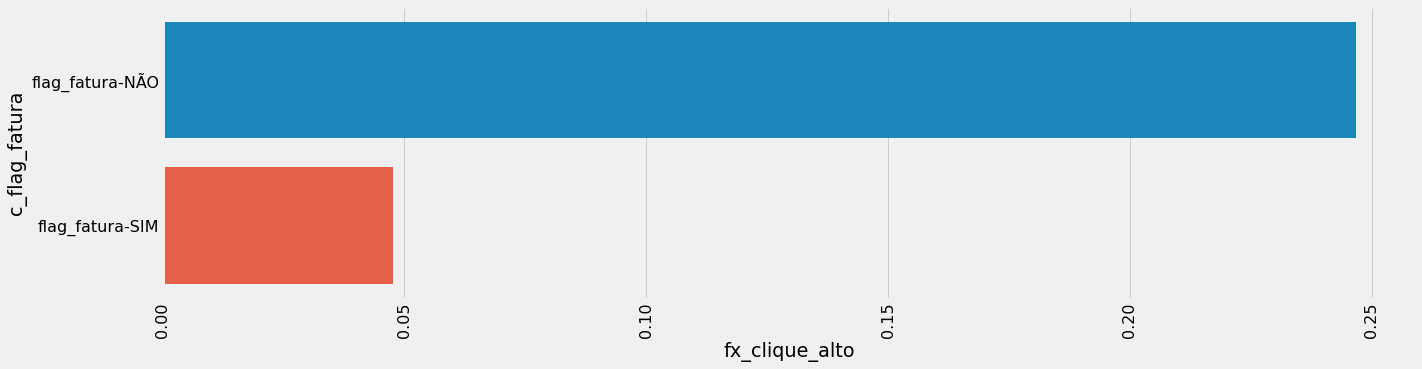

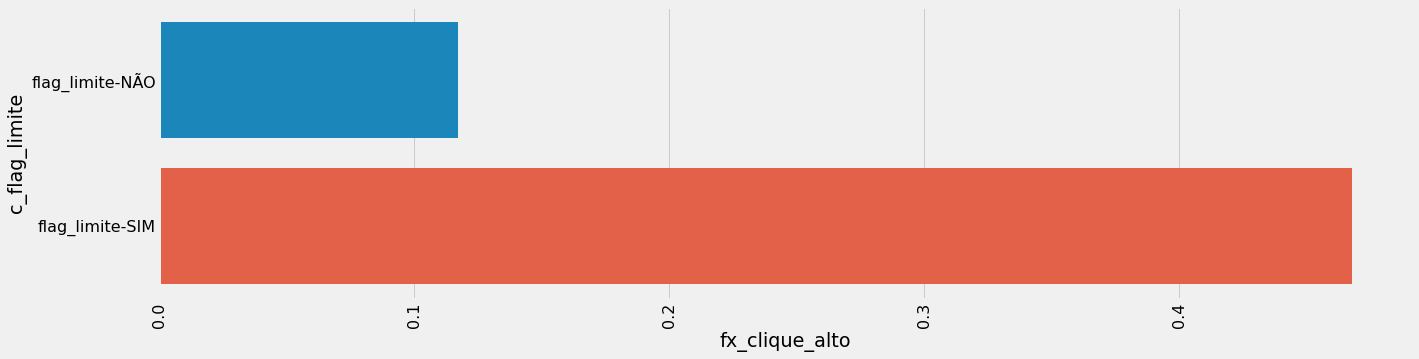

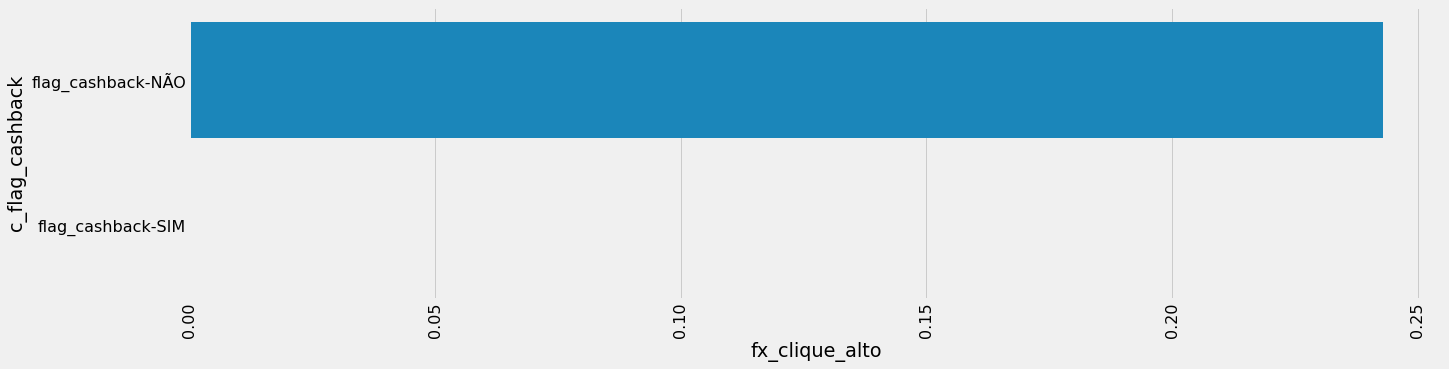

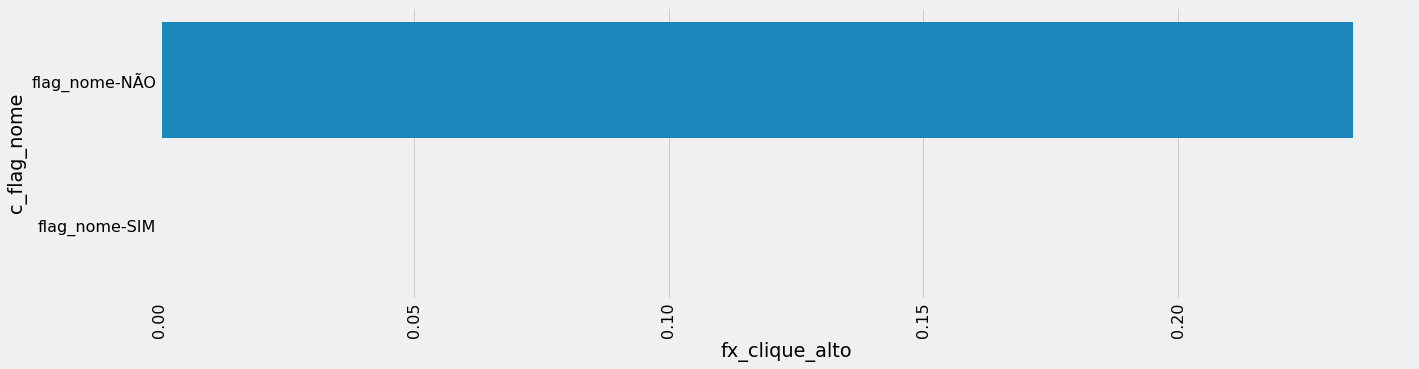

<Figure size 720x360 with 0 Axes>

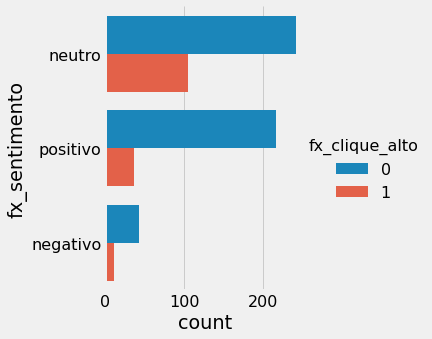

<Figure size 720x360 with 0 Axes>

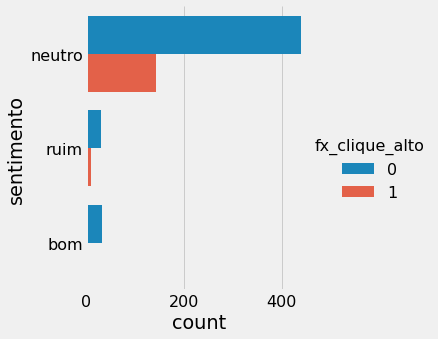

<Figure size 720x360 with 0 Axes>

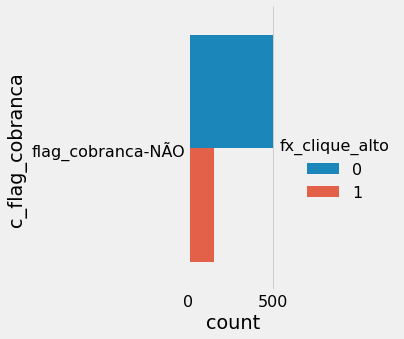

<Figure size 720x360 with 0 Axes>

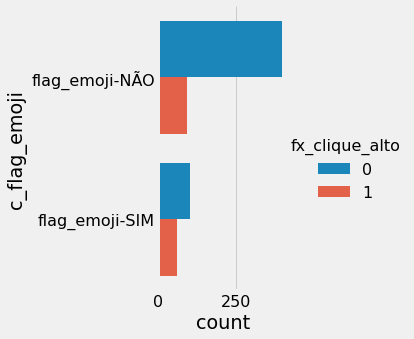

<Figure size 720x360 with 0 Axes>

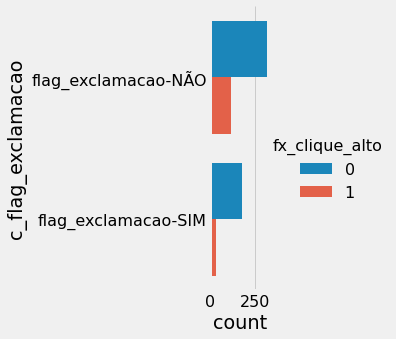

<Figure size 720x360 with 0 Axes>

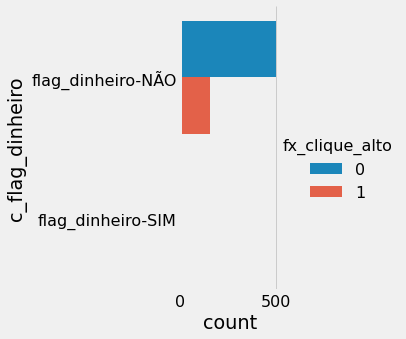

<Figure size 720x360 with 0 Axes>

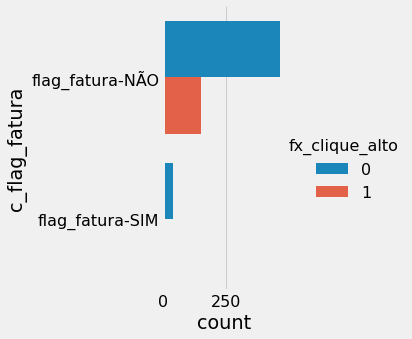

<Figure size 720x360 with 0 Axes>

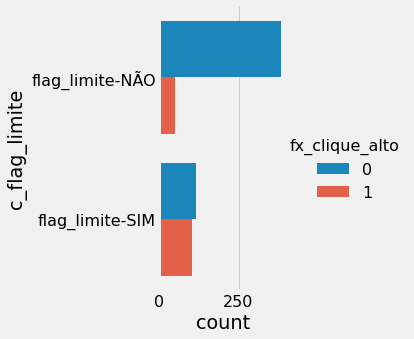

<Figure size 720x360 with 0 Axes>

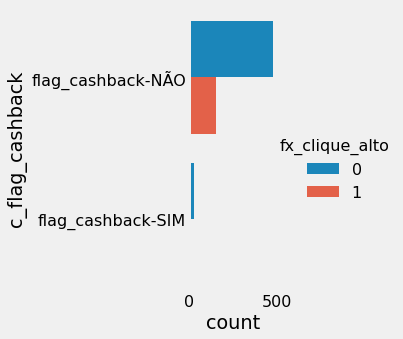

<Figure size 720x360 with 0 Axes>

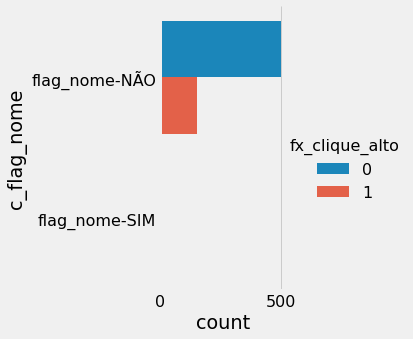

In [269]:
#análise de variável de interesse binária (exemplo atraso)
import aed

drop_col = ['ds_message_tratada', 'activityname', 'journeyname', 'tema', 'subject',
       'ferramenta', 'clientes', 'cliques', 'aberturas', 'dt_envio',
       'taxa_abertura', 'taxa_clique', 'flag_cobranca', 'flag_emoji',
       'flag_exclamacao', 'flag_dinheiro', 'flag_fatura', 'flag_limite',
       'flag_cashback', 'flag_nome', 'n_palavras', 'sentiment', 
       'sentiment_2', 'classe', 'adjective', 'adposition', 'adverb',
       'auxiliary', 'coordinating conjunction', 'determiner', 'interjection',
       'noun', 'numeral', 'other', 'pronoun', 'proper noun', 'punctuation',
       'space', 'subordinating conjunction', 'symbol', 'verb', 'pca', 'pca_1',
       'pca_2', 'cluster_hero', 'cluster_dbscan', 'pca_1_tsne', 'pca_2_tsne',
       'cluster_dbscan_tsne', 'ano', 'dia', 'mes', 'dia_semana', 'hora',
       'cont', 'fx_clique']

#criar variável binária para investigar
aed.vi(df_comb, drop_col, 'fx_clique_alto')

,fx_clique_m_alto,cluster,fx_hora,fx_clique_alto,fx_sentimento_negativo,fx_sentimento_neutro,fx_sentimento_positivo,sentimento_bom,sentimento_neutro,sentimento_ruim,...,c_flag_dinheiro_flag_dinheiro-NÃO,c_flag_dinheiro_flag_dinheiro-SIM,c_flag_fatura_flag_fatura-NÃO,c_flag_fatura_flag_fatura-SIM,c_flag_limite_flag_limite-NÃO,c_flag_limite_flag_limite-SIM,c_flag_cashback_flag_cashback-NÃO,c_flag_cashback_flag_cashback-SIM,c_flag_nome_flag_nome-NÃO,c_flag_nome_flag_nome-SIM
0,0,1.532313,3.139456,0.260204,0.071429,0.542517,0.386054,0.051020,0.896259,0.052721,...,0.991497,0.008503,0.931973,0.068027,0.697279,0.302721,0.960884,0.039116,0.998299,0.001701
1,1,2.500000,3.500000,0.000000,0.181818,0.424242,0.393939,0.045455,0.833333,0.121212,...,1.000000,0.000000,0.969697,0.030303,0.393939,0.606061,0.984848,0.015152,1.000000,0.000000


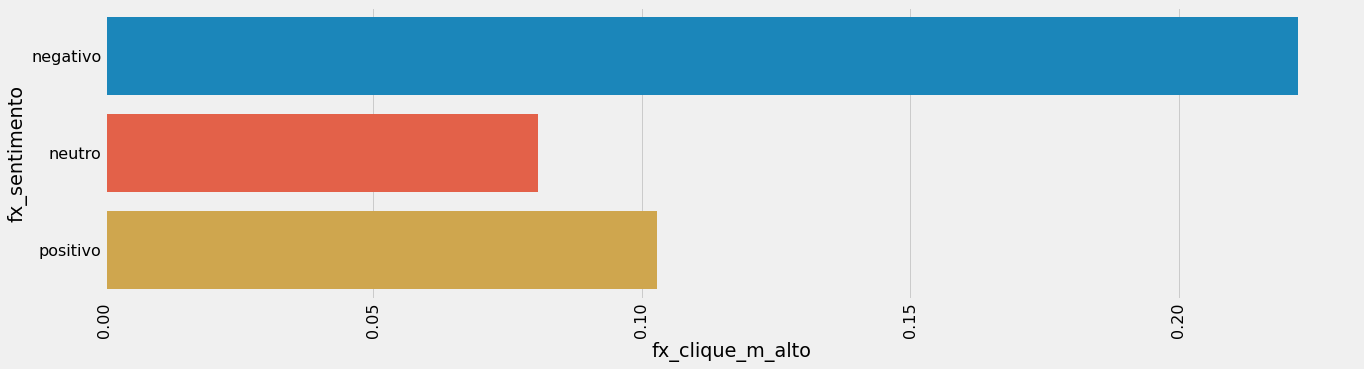

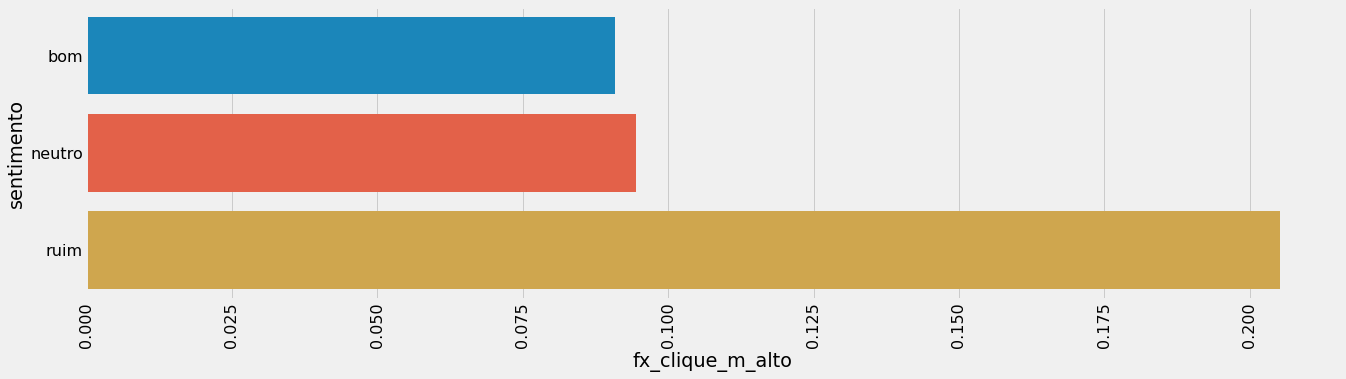

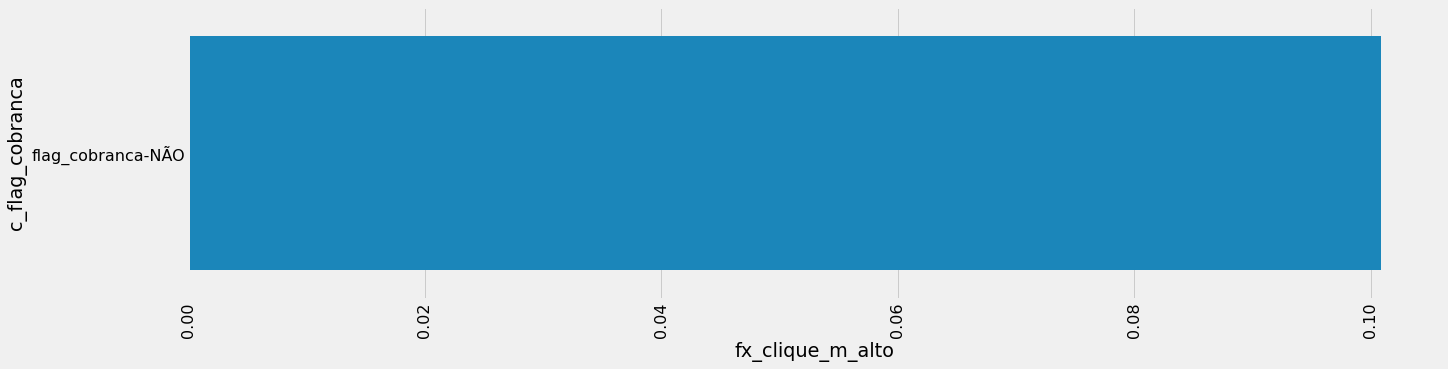

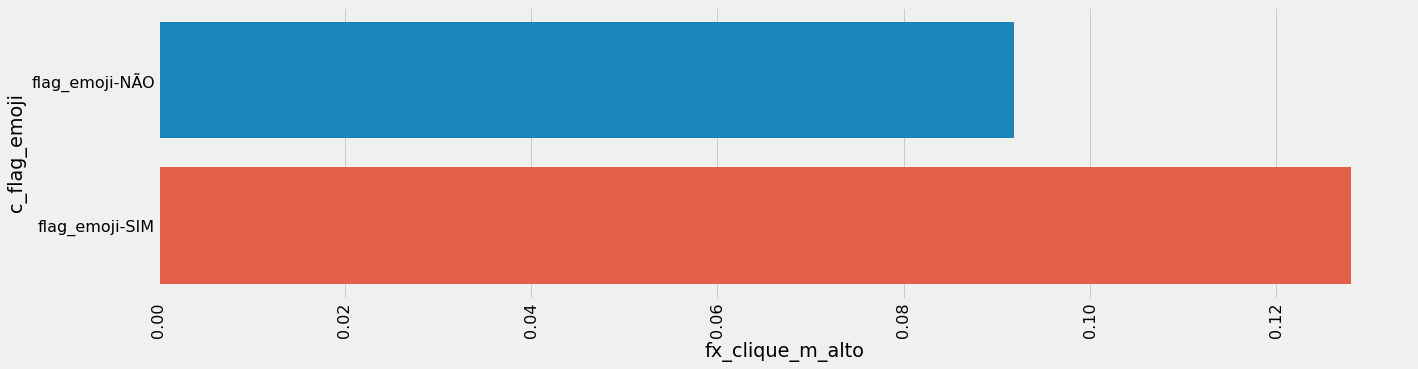

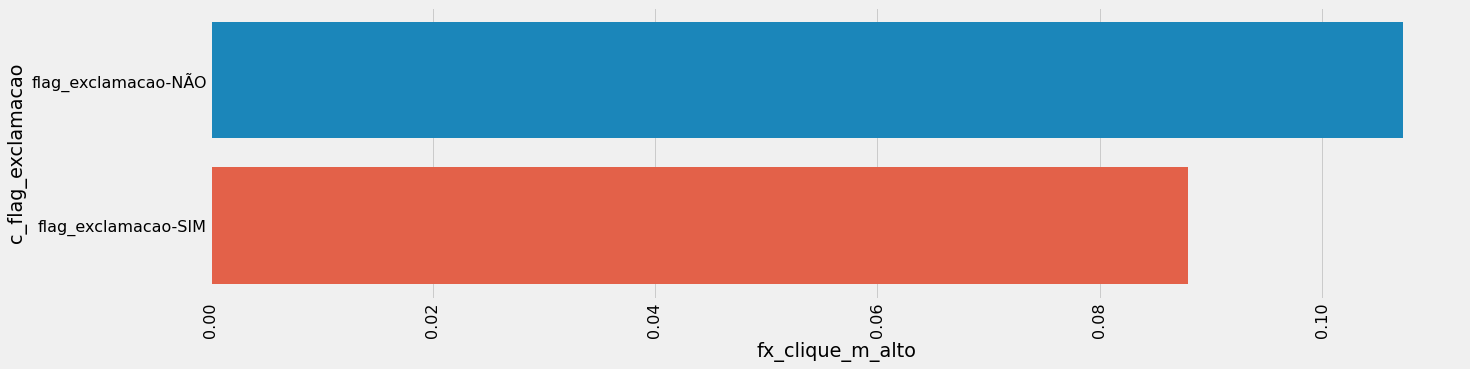

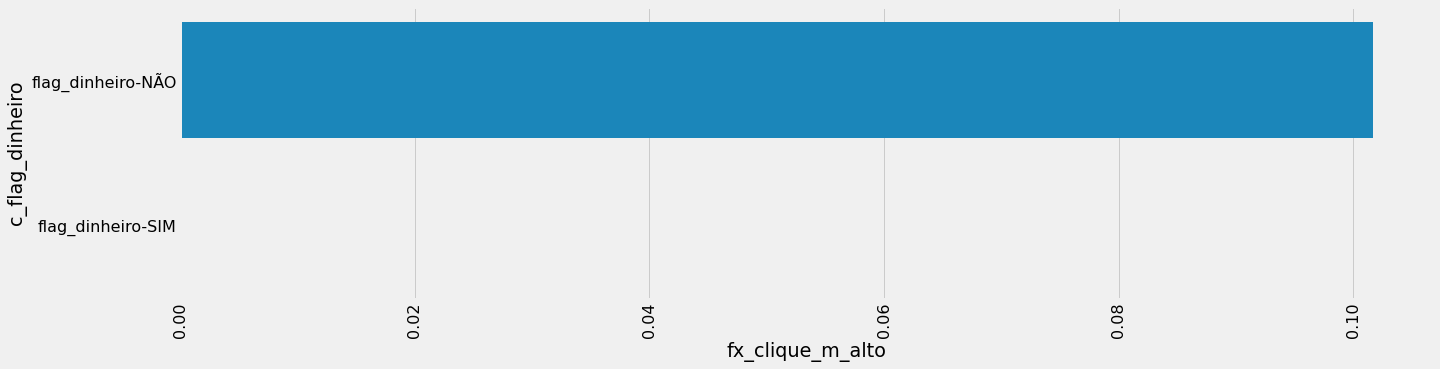

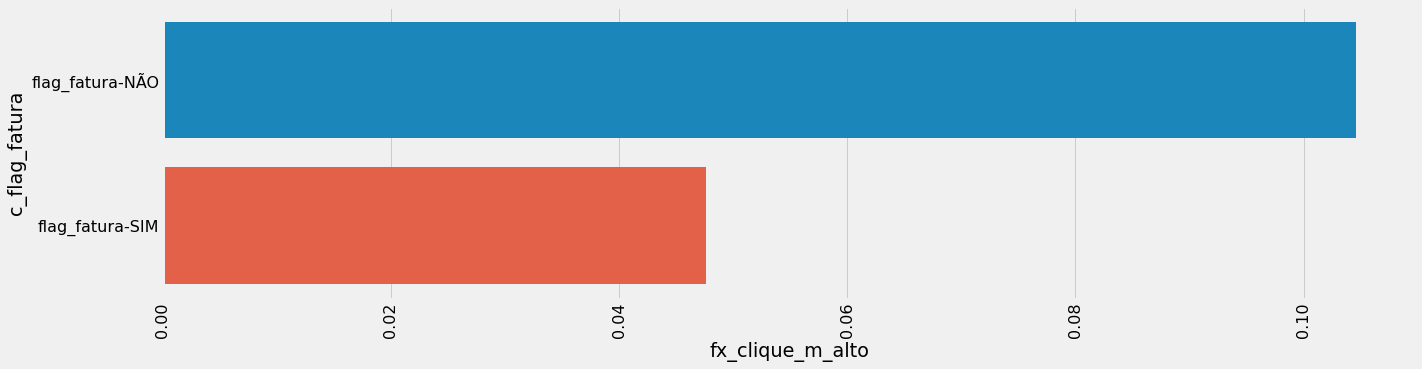

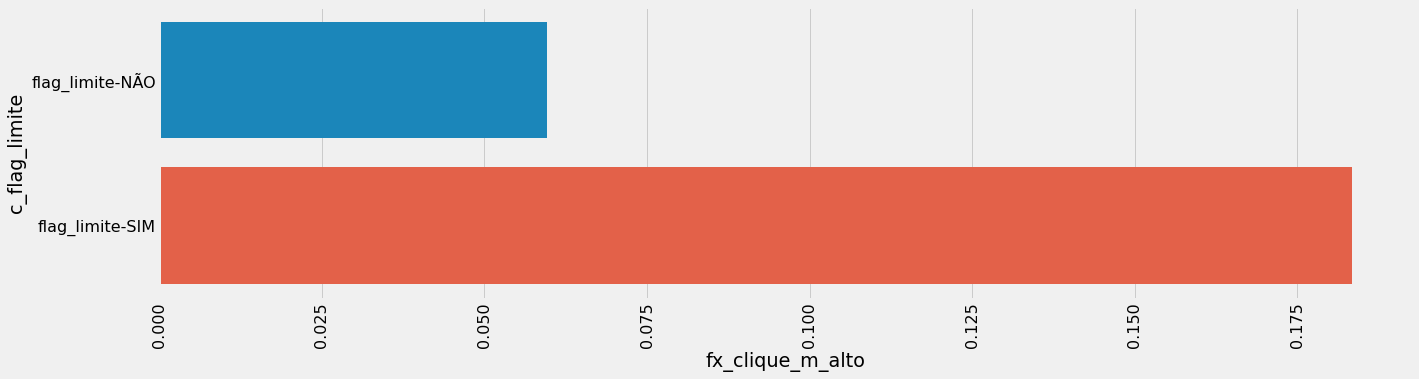

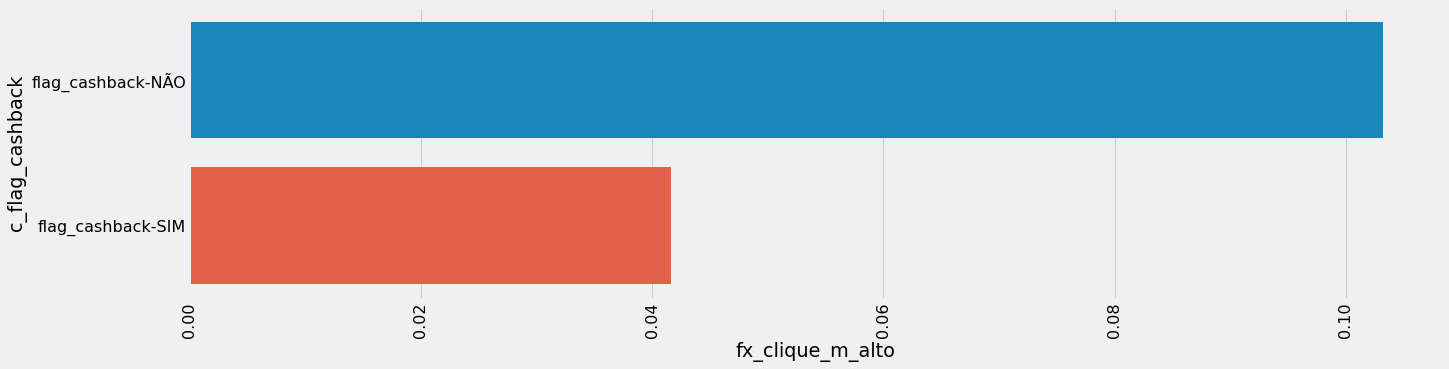

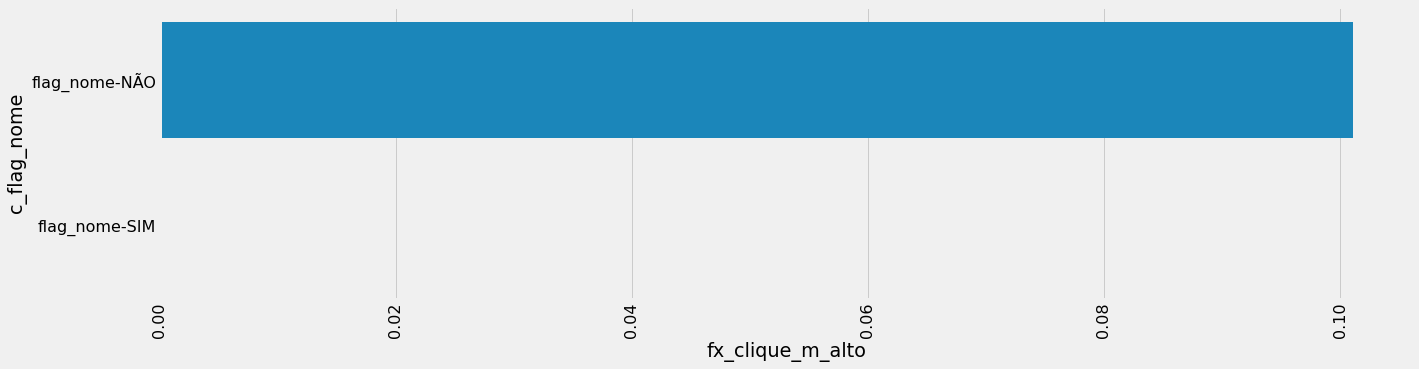

<Figure size 720x360 with 0 Axes>

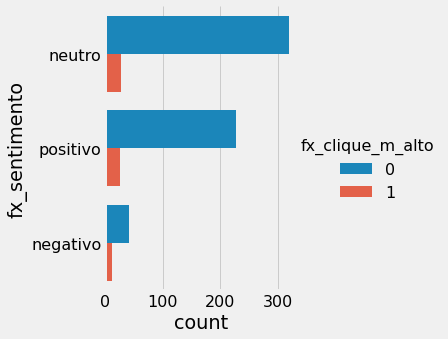

<Figure size 720x360 with 0 Axes>

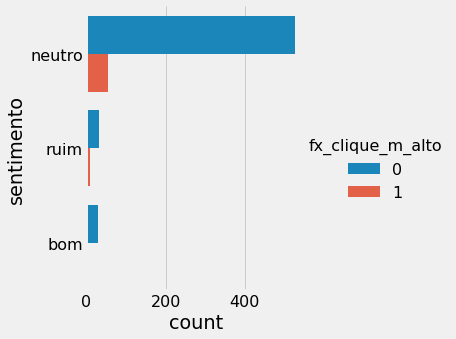

<Figure size 720x360 with 0 Axes>

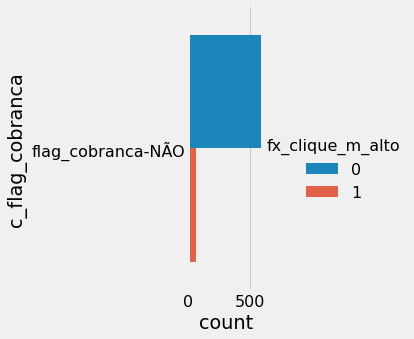

<Figure size 720x360 with 0 Axes>

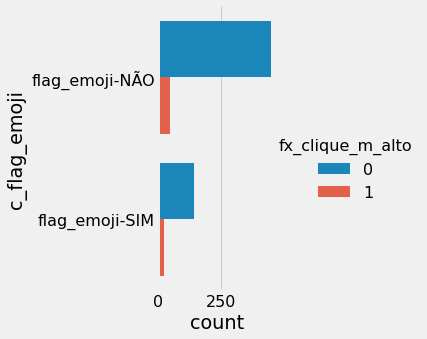

<Figure size 720x360 with 0 Axes>

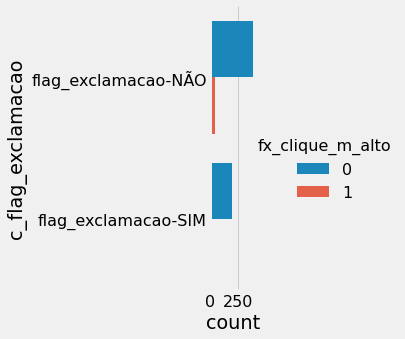

<Figure size 720x360 with 0 Axes>

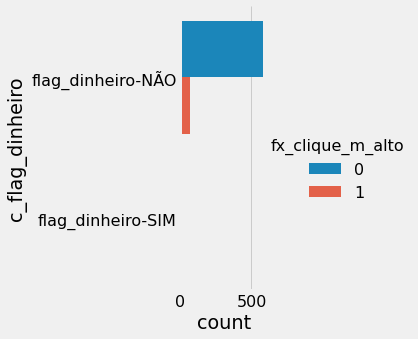

<Figure size 720x360 with 0 Axes>

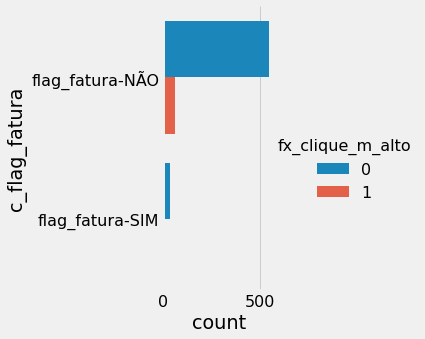

<Figure size 720x360 with 0 Axes>

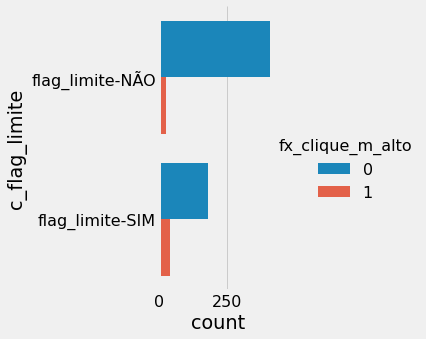

<Figure size 720x360 with 0 Axes>

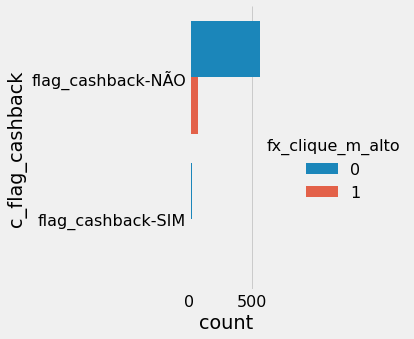

<Figure size 720x360 with 0 Axes>

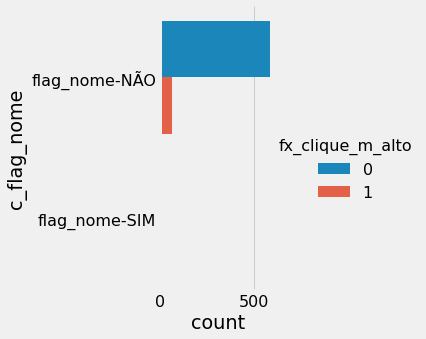

In [270]:
df_comb['fx_clique_m_alto'] = np.where(df_comb['fx_clique'] == "médio-alto", 1, 0)

aed.vi(df_comb, drop_col, 'fx_clique_m_alto')

,fx_clique_baixo,cluster,fx_hora,fx_clique_alto,fx_clique_m_alto,fx_sentimento_negativo,fx_sentimento_neutro,fx_sentimento_positivo,sentimento_bom,sentimento_neutro,...,c_flag_dinheiro_flag_dinheiro-NÃO,c_flag_dinheiro_flag_dinheiro-SIM,c_flag_fatura_flag_fatura-NÃO,c_flag_fatura_flag_fatura-SIM,c_flag_limite_flag_limite-NÃO,c_flag_limite_flag_limite-SIM,c_flag_cashback_flag_cashback-NÃO,c_flag_cashback_flag_cashback-SIM,c_flag_nome_flag_nome-NÃO,c_flag_nome_flag_nome-SIM
0,0,1.745011,3.150776,0.339246,0.146341,0.093126,0.552106,0.354767,0.044346,0.878049,...,0.988914,0.011086,0.929047,0.070953,0.569845,0.430155,0.975610,0.024390,0.997783,0.002217
1,1,1.374384,3.231527,0.000000,0.000000,0.059113,0.482759,0.458128,0.064039,0.916256,...,1.000000,0.000000,0.950739,0.049261,0.881773,0.118227,0.935961,0.064039,1.000000,0.000000


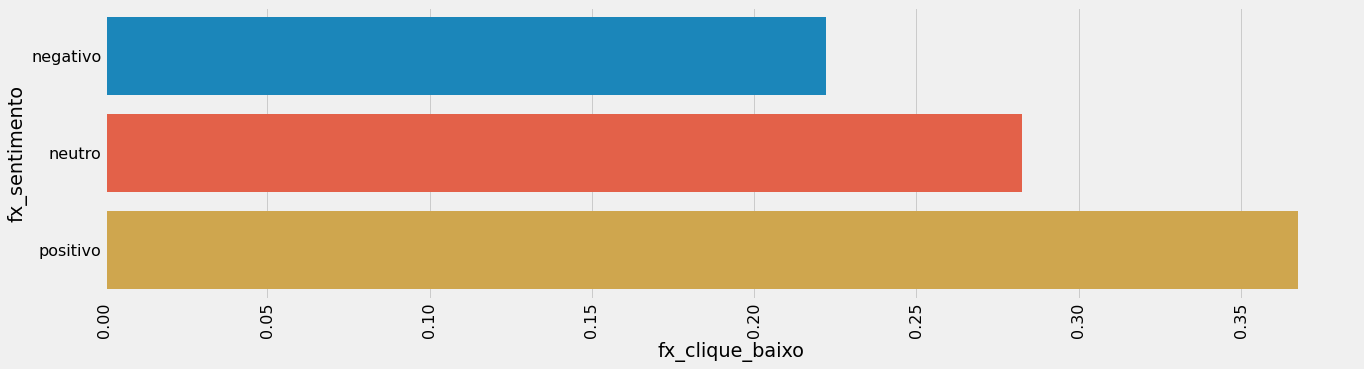

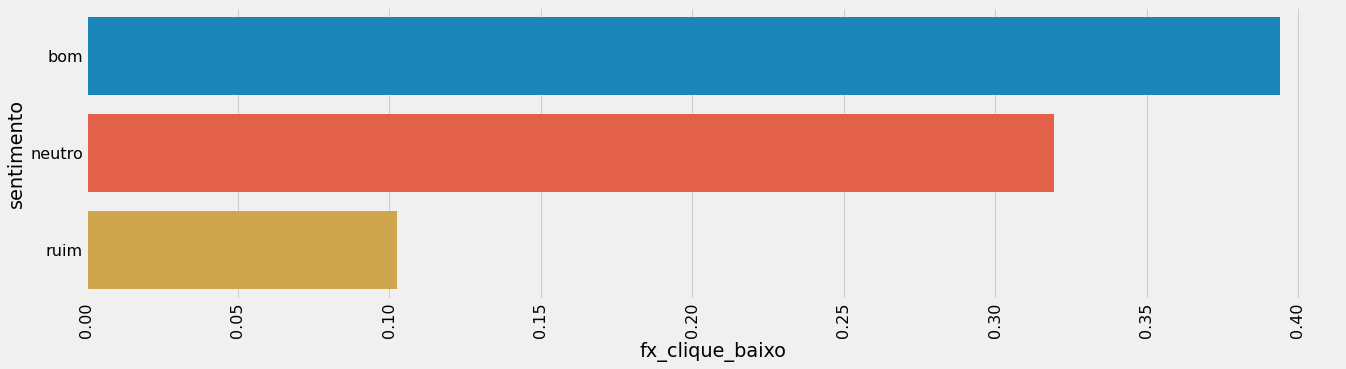

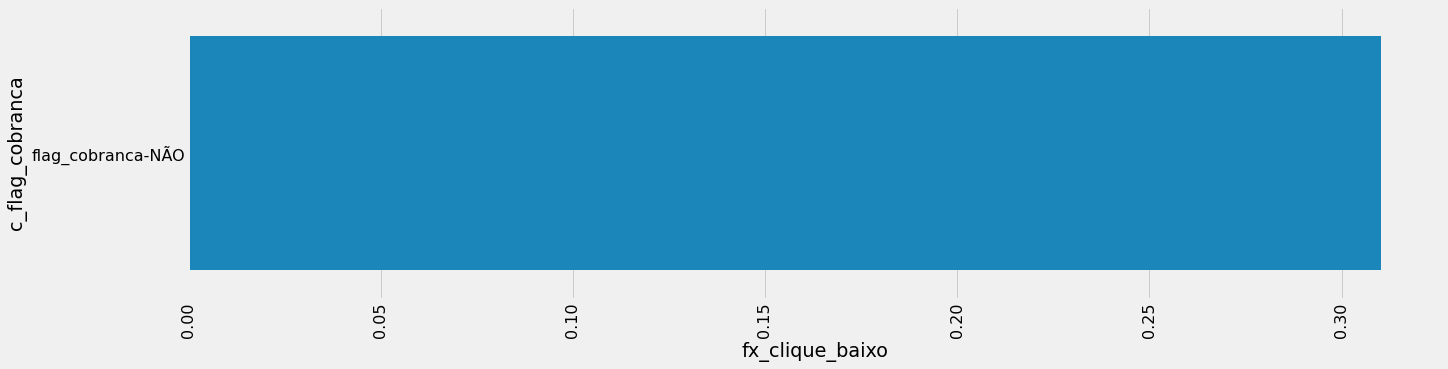

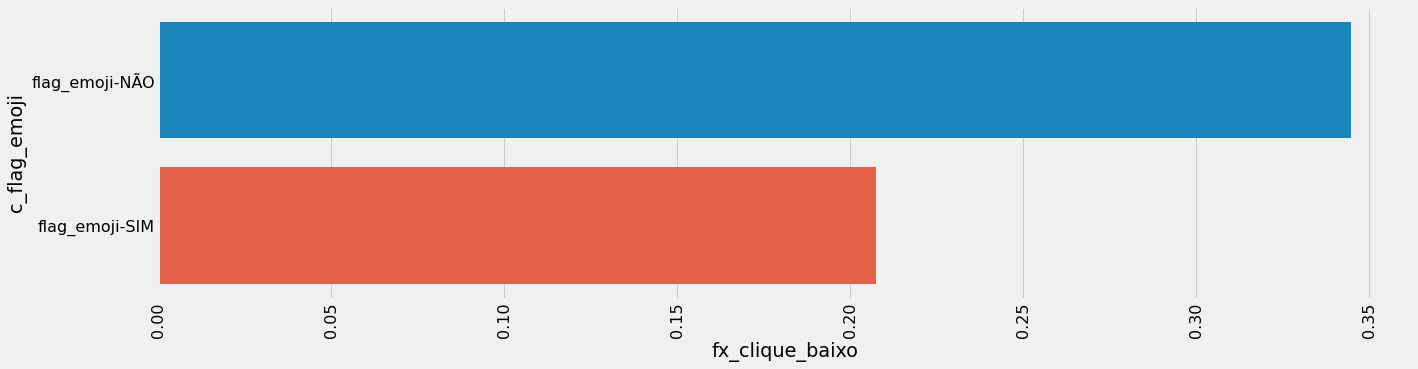

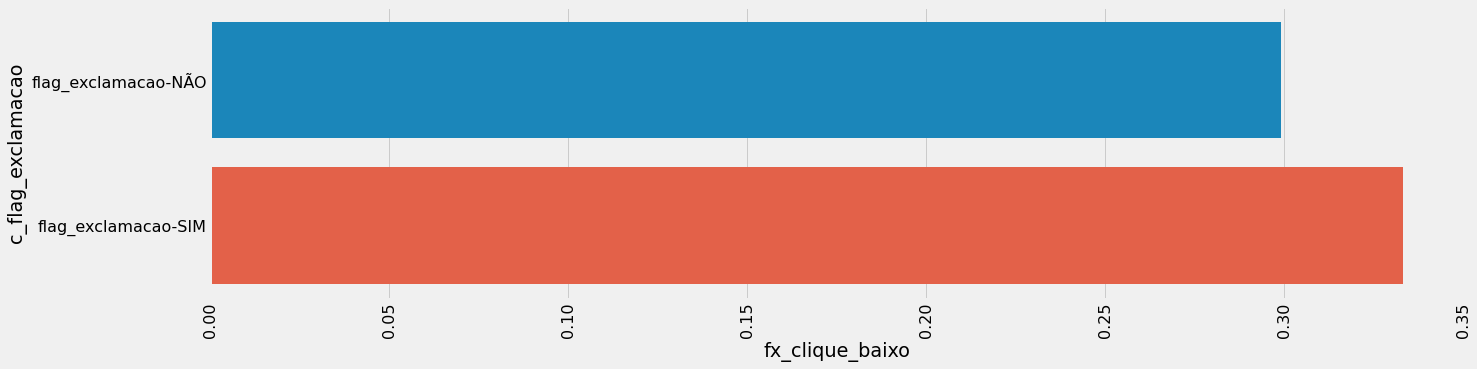

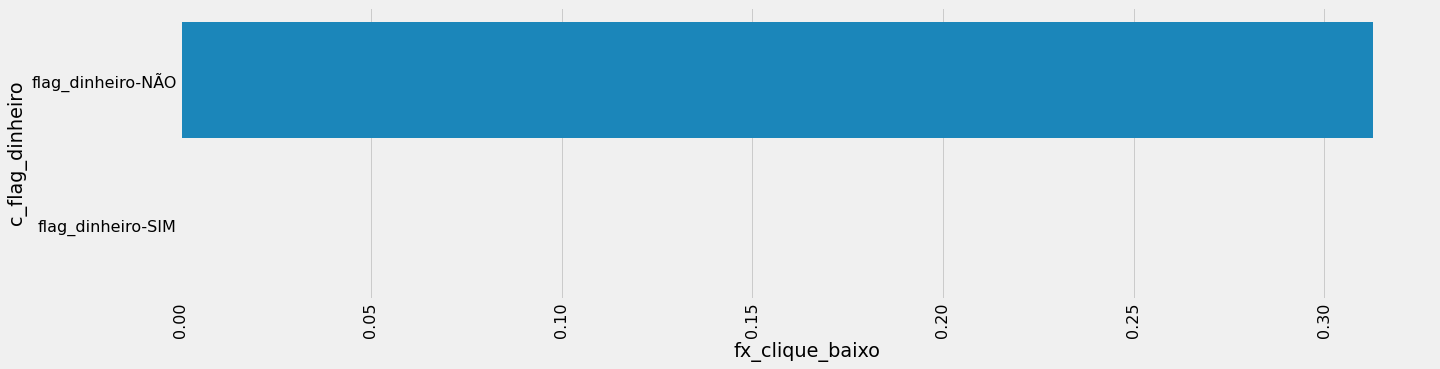

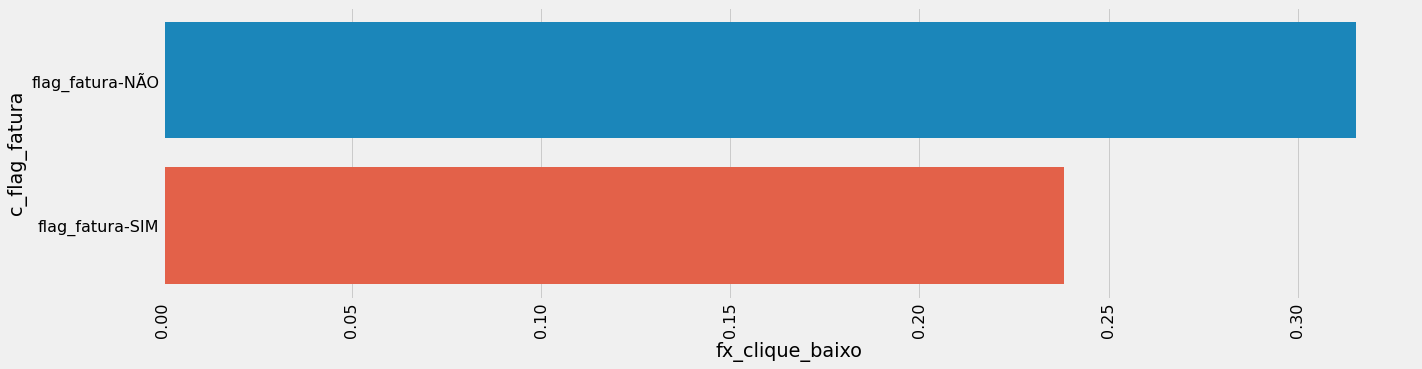

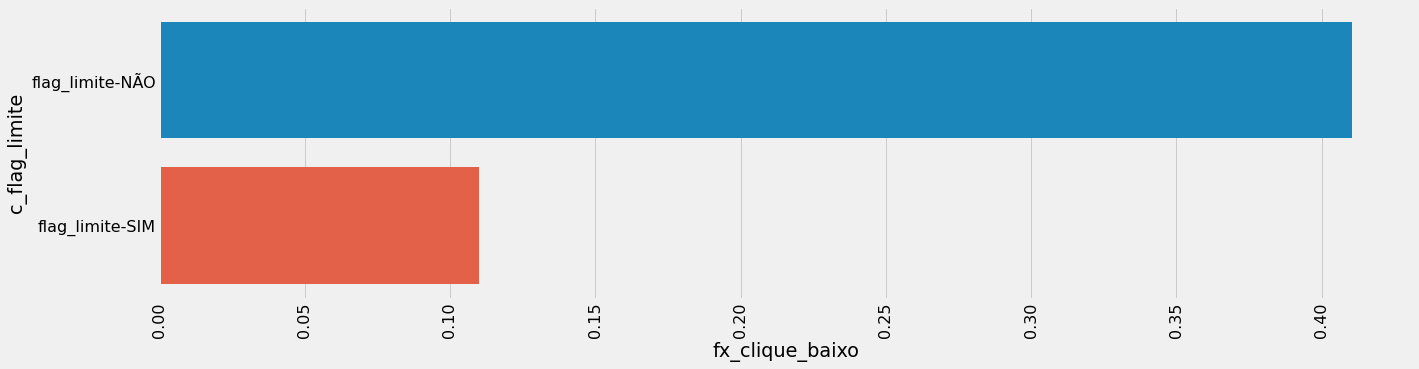

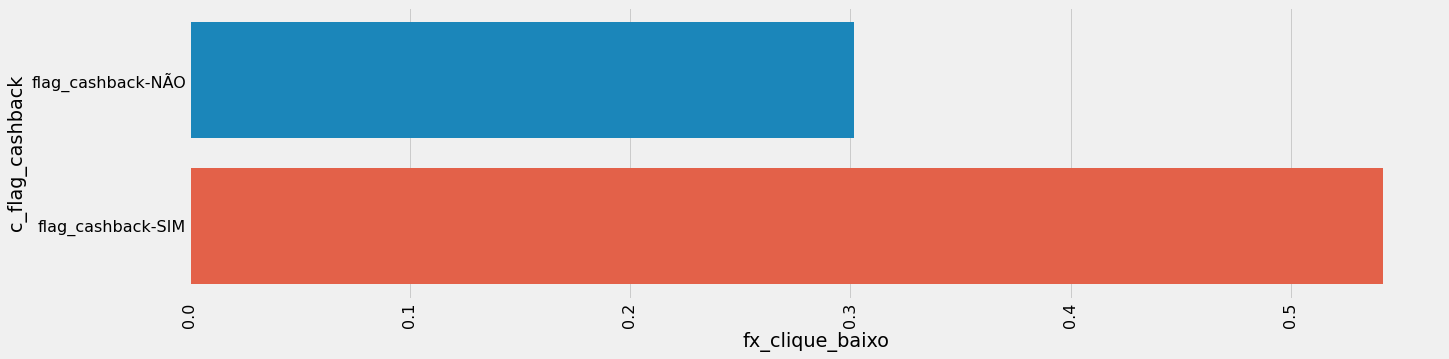

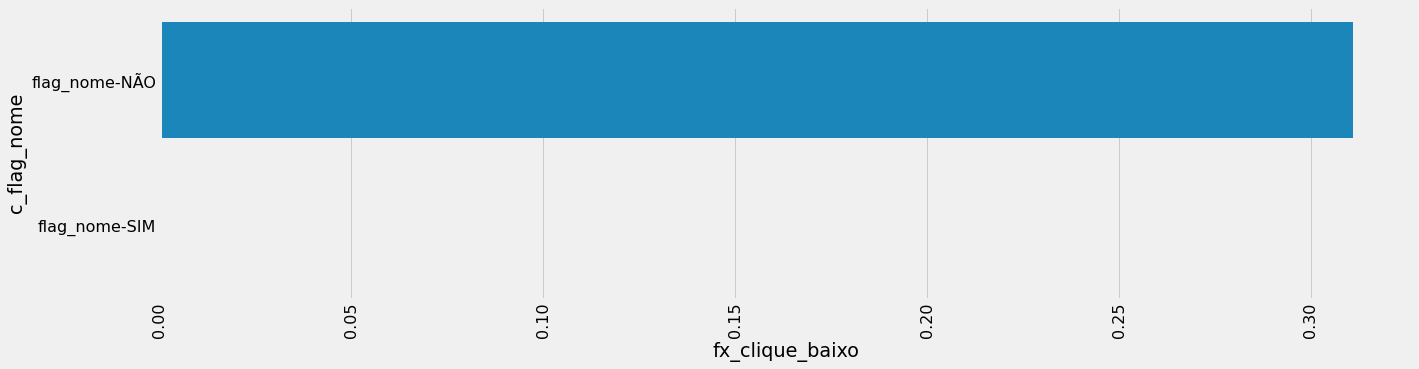

<Figure size 720x360 with 0 Axes>

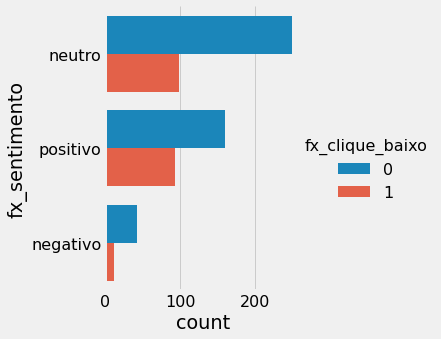

<Figure size 720x360 with 0 Axes>

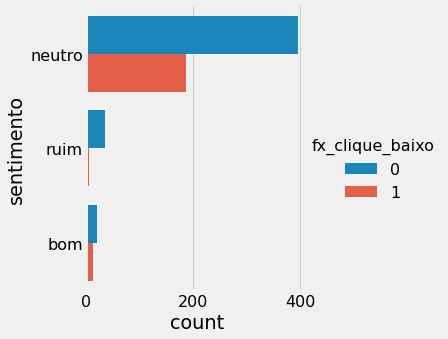

<Figure size 720x360 with 0 Axes>

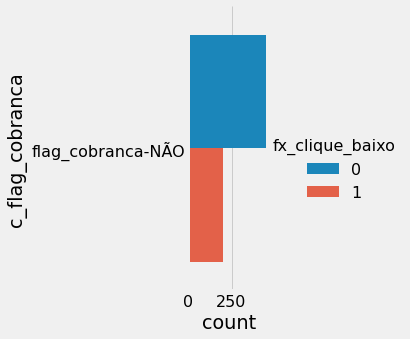

<Figure size 720x360 with 0 Axes>

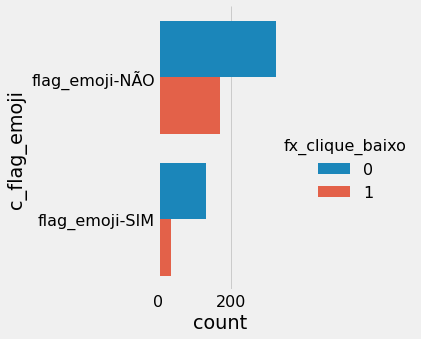

<Figure size 720x360 with 0 Axes>

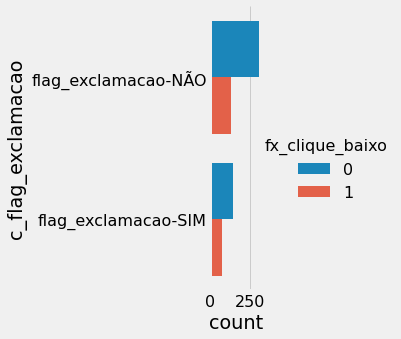

<Figure size 720x360 with 0 Axes>

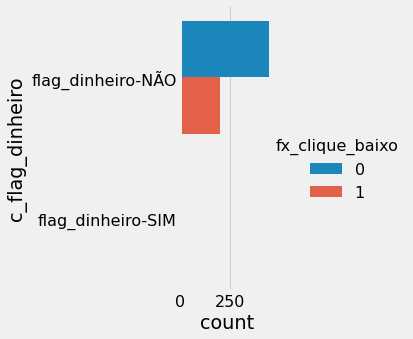

<Figure size 720x360 with 0 Axes>

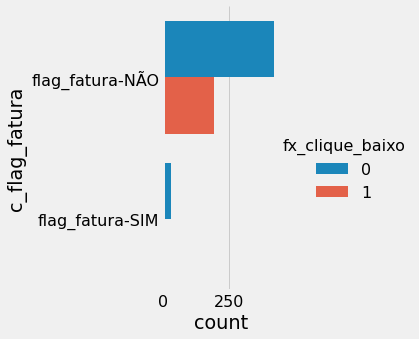

<Figure size 720x360 with 0 Axes>

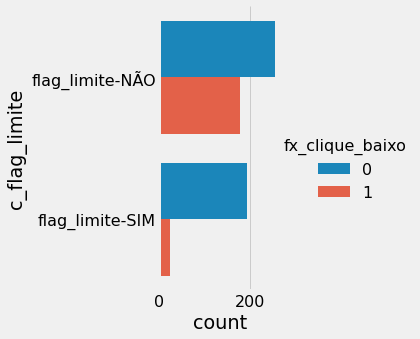

<Figure size 720x360 with 0 Axes>

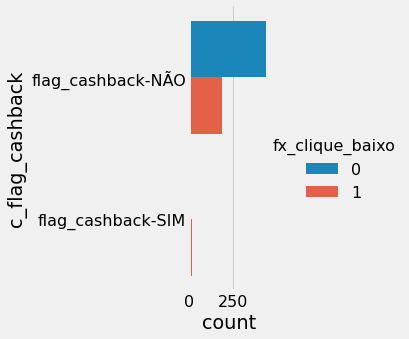

<Figure size 720x360 with 0 Axes>

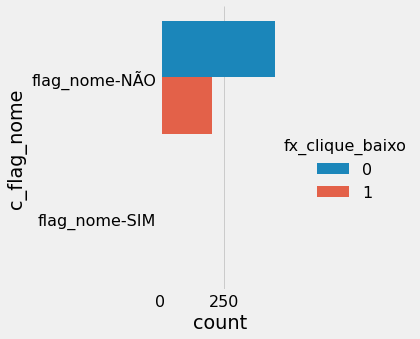

In [271]:
df_comb['fx_clique_baixo'] = np.where(df_comb['fx_clique'] == "baixo", 1, 0)

aed.vi(df_comb, drop_col, 'fx_clique_baixo')